<a href="https://colab.research.google.com/github/KodakV/Case_cup/blob/master/Cup_image_segmentation_Unet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# необходимые модули
import torch
import random
import numpy as np
import pandas as pd
import json
import base64
import os
import pylab
import torchvision
import shutil
import matplotlib.pyplot as plt
from torchvision import transforms, models
from tqdm import tqdm
import cv2
import pylab
import cv2
from google.colab.patches import cv2_imshow
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
train_dir = '/content/drive/My Drive/dataset_its/train/'
test_dir='/content/drive/My Drive/dataset_its/test/'

In [ ]:
!rm -rf 'train_json'
!rm -rf 'train_png'
!rm -rf 'val_json'
!rm -rf 'val_png'
os.makedirs('/content/train_json')
os.makedirs('/content/train_png')
os.makedirs('/content/val_json')
os.makedirs('/content/val_png')

In [ ]:
# number_train_photo=int(len(os.listdir(train_dir))/2)
# FILE_FILTER=['.png','.json']
# for index in range(1,number_train_photo+1): 
#     if index<10:
#       number="00{index}".format(index=index)
#       current='/content/drive/My Drive/dataset_its/train/'+number
#       print(current)
#     elif index<100 and index>=10:
#       number="0{index}".format(index=index)
#       current='/content/drive/My Drive/dataset_its/train/'+number
#       print(current)
#     elif index>=100:
#       number='{index}'.format(index=index)
#       current='/content/drive/My Drive/dataset_its/train/'+number
#       print(current)

#     with open(current+FILE_FILTER[1], 'r', encoding='utf-8') as fh: #открываем файл на чтение
#       data = json.load(fh) #загружаем из файл а данные в словарь data
#       class_photo=data['shapes'][0]['label']
#       train_path='/content/train/'+'{path}/'.format(path=class_photo)
#       train_png_path='/content/train_png'
#       train_json_path='/content/train_json'
#       shutil.copy(train_dir+number+FILE_FILTER[0], train_png_path)
#       shutil.copy(train_dir+number+FILE_FILTER[1], train_json_path)

In [ ]:
# gpuid=0
# if(torch.cuda.is_available()):
#     print(torch.cuda.get_device_properties(gpuid))
#     torch.cuda.set_device(gpuid)
#     device = torch.device(f'cuda:{gpuid}')
# else:
#     device = torch.device(f'cpu')

In [ ]:
val_part=20
number_train_photo=int(len(os.listdir(train_dir))/2)
FILE_FILTER=['.png','.json']
for index in range(1,number_train_photo+1): 
    if index<10:
      number="00{index}".format(index=index)
      current='/content/drive/My Drive/dataset_its/train/'+number
      print(current)
    elif index<100 and index>=10:
      number="0{index}".format(index=index)
      current='/content/drive/My Drive/dataset_its/train/'+number
      print(current)
    elif index>=100:
      number='{index}'.format(index=index)
      current='/content/drive/My Drive/dataset_its/train/'+number
      print(current)

    if index%val_part!=0:
      train_png_path='/content/train_png'
      train_json_path='/content/train_json'
      shutil.copy(train_dir+number+FILE_FILTER[0], train_png_path)
      shutil.copy(train_dir+number+FILE_FILTER[1], train_json_path)
    else:
      val_png_path='/content/val_png'
      val_json_path='/content/val_json'
      shutil.copy(train_dir+number+FILE_FILTER[0], val_png_path)
      shutil.copy(train_dir+number+FILE_FILTER[1], val_json_path)



/content/drive/My Drive/dataset_its/train/001
/content/drive/My Drive/dataset_its/train/002
/content/drive/My Drive/dataset_its/train/003
/content/drive/My Drive/dataset_its/train/004
/content/drive/My Drive/dataset_its/train/005
/content/drive/My Drive/dataset_its/train/006
/content/drive/My Drive/dataset_its/train/007
/content/drive/My Drive/dataset_its/train/008
/content/drive/My Drive/dataset_its/train/009
/content/drive/My Drive/dataset_its/train/010
/content/drive/My Drive/dataset_its/train/011
/content/drive/My Drive/dataset_its/train/012
/content/drive/My Drive/dataset_its/train/013
/content/drive/My Drive/dataset_its/train/014
/content/drive/My Drive/dataset_its/train/015
/content/drive/My Drive/dataset_its/train/016
/content/drive/My Drive/dataset_its/train/017
/content/drive/My Drive/dataset_its/train/018
/content/drive/My Drive/dataset_its/train/019
/content/drive/My Drive/dataset_its/train/020
/content/drive/My Drive/dataset_its/train/021
/content/drive/My Drive/dataset_it

In [ ]:
train_json_path='/content/train_json/'
val_json_path='/content/val_json/'
json_path=[train_json_path, val_json_path]
train_mask=[]
val_mask=[]
for path in json_path:
  for filename in sorted(os.listdir(path)):
      with open(os.path.join(path, filename), 'r') as f:
        layout = json.load(f)
      h, w = layout['imageHeight'], layout['imageWidth']
      true_mask = np.zeros((h, w), np.uint8)
      label = layout['shapes'][0]['label']
      for shape in layout['shapes']:
        polygon = np.array([point[::-1] for point in shape['points']])
        cv2.fillPoly(true_mask, [polygon[:, [1, 0]]], 255)
      # cv2_imshow(true_mask)
      if path==train_json_path:
        train_mask.append(true_mask)
      else:
        val_mask.append(true_mask)
train_mask=np.array(train_mask)
val_mask=np.array(val_mask)

In [ ]:
dataname="epistroma"
ignore_index = -100 
gpuid=0

# --- unet params

n_classes= 1    #number of classes in the data mask that we'll aim to predict
in_channels= 1  #input channel of the data, RGB = 3
padding= True   #should levels be padded
depth= 6       #depth of the network 
wf= 6           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size=2
patch_size=(512,640)
num_epochs = 100
edge_weight = 1.1 
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models


from unet import UNet #code borrowed from https://github.com/jvanvugt/pytorch-unet

import PIL
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

# from tensorboardX import SummaryWriter

import scipy.ndimage 

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix



In [ ]:
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')

_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [ ]:
train_png_path='/content/train_png/'
val_png_path='/content/val_png/'
png_path=[train_png_path, val_png_path]
train_set=[]
val_set=[]
iter=0
for path in png_path:
  for file in sorted(os.listdir(path)):
    
    iter+=1
    print(iter)
    image = cv2.imread(path+'{file}'.format(file=file),0)
    image_rgb = image.astype(np.uint8)
    if path==train_png_path:
      train_set.append(image) 
    else:
      val_set.append(image)
train_set=np.array(train_set)
val_set=np.array(val_set)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261


In [ ]:
print(len(train_set))
print(len(train_mask))

209
209


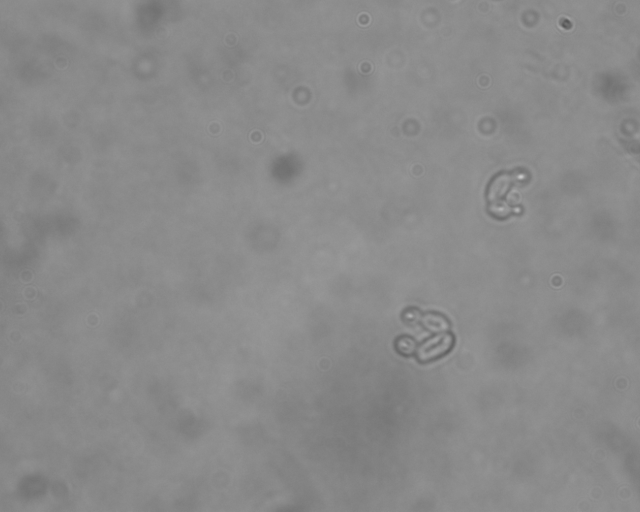

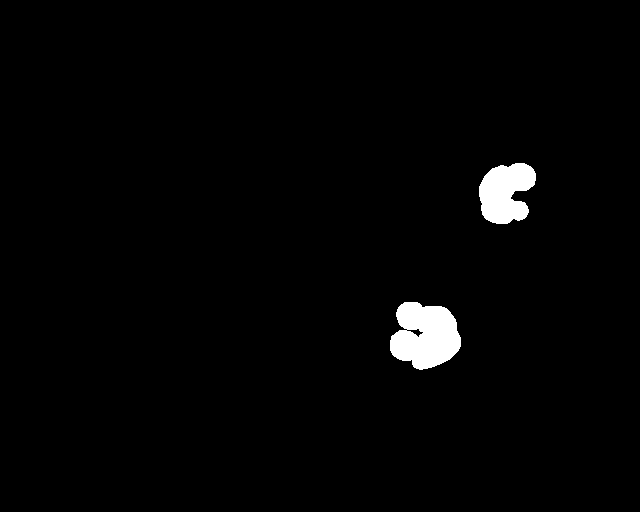

In [ ]:
cv2_imshow(train_set[10])
cv2_imshow(train_mask[10])

In [ ]:
print(train_set.shape)
print(train_mask.shape)
print(val_set.shape)
print(val_mask.shape)

(209, 512, 640)
(209, 512, 640)
(52, 512, 640)
(52, 512, 640)


In [ ]:

class SimDataset(Dataset):
  def __init__(self, input_image, input_mask=None, transform_image=None, transform_mask=None):
    self.transform_image = transform_image
    self.transform_mask=transform_mask
    self.input_images = input_image
    self.target_masks = input_mask


  def __len__(self):
    return len(self.input_images)

  def __getitem__(self, idx):
    image = self.input_images[idx]
    if self.target_masks is not None:
      mask = self.target_masks[idx]
    if self.transform_image is not None:
      image = self.transform_image(image)
    if self.transform_mask is not None:
      mask=self.transform_mask(mask)
    if self.target_masks is not None:
      return [image, mask]
    else:  
      return image

# use the same transformations for train/val in this example
trans = transforms.Compose([
  # transforms.ToPILImage(),
  transforms.ToTensor(),
  # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])
img_transform = transforms.Compose([
     transforms.ToPILImage(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    # transforms.RandomResizedCrop(size=patch_size),
    # transforms.RandomRotation(180),
    # transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
    # transforms.RandomGrayscale(),
    transforms.ToTensor()
    ])

mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    # transforms.RandomResizedCrop(size=patch_size,interpolation=PIL.Image.NEAREST),
    # transforms.RandomRotation(180),
    transforms.ToTensor()
    ])
train_dataset = SimDataset(train_set,train_mask, transform_image = img_transform, transform_mask = mask_transform)
val_dataset = SimDataset(val_set,val_mask, transform_image = img_transform, transform_mask=mask_transform)

# batch_size = 25
image_datasets = {
  'train': train_set, 'val': val_set
}

dataloaders = {
  'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
  'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
}


In [ ]:
# img_transform = transforms.Compose([
#      transforms.ToPILImage(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
#     transforms.RandomResizedCrop(size=patch_size),
#     transforms.RandomRotation(180),
#     transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
#     transforms.RandomGrayscale(),
#     transforms.ToTensor()
#     ])


# mask_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
#     transforms.RandomResizedCrop(size=patch_size,interpolation=PIL.Image.NEAREST),
#     transforms.RandomRotation(180),
#     ])


In [ ]:
# import torch
# import torch.optim as optim
# from torch.optim import lr_scheduler
# import time
# import copy

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

# num_class = 6
# model = ResNetUNet(num_class).to(device)

# # freeze backbone layers
# #for l in model.base_layers:
# #    for param in l.parameters():
# #        param.requires_grad = False

# optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

# model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)

In [ ]:

model = UNet(n_classes=n_classes, in_channels=in_channels, padding=padding,depth=depth,wf=wf, up_mode=up_mode, batch_norm=batch_norm).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	124385089


In [ ]:
import torch
import torch.nn as nn

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [ ]:
from collections import defaultdict
import torch.nn.functional as F


def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

In [ ]:
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=32)

Epoch 0/31
----------
LR 0.0001


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.640846, dice: 0.934570, loss: 0.787708
val: bce: 0.729077, dice: 0.919748, loss: 0.824412
saving best model
5m 5s
Epoch 1/31
----------
LR 0.0001
train: bce: 0.559916, dice: 0.926616, loss: 0.743266
val: bce: 0.523118, dice: 0.912731, loss: 0.717924
saving best model
5m 8s
Epoch 2/31
----------
LR 0.0001
train: bce: 0.508350, dice: 0.920275, loss: 0.714312
val: bce: 0.461503, dice: 0.908211, loss: 0.684857
saving best model
5m 8s
Epoch 3/31
----------
LR 0.0001
train: bce: 0.456474, dice: 0.912855, loss: 0.684665
val: bce: 0.384800, dice: 0.890664, loss: 0.637732
saving best model
5m 8s
Epoch 4/31
----------
LR 0.0001
train: bce: 0.401155, dice: 0.903853, loss: 0.652504
val: bce: 0.386979, dice: 0.879257, loss: 0.633118
saving best model
5m 8s
Epoch 5/31
----------
LR 0.0001
train: bce: 0.344404, dice: 0.890633, loss: 0.617519
val: bce: 0.369379, dice: 0.878708, loss: 0.624043
saving best model
5m 8s
Epoch 6/31
----------
LR 0.0001
train: bce: 0.308495, dice: 0.882452, lo

In [ ]:
test_png_path='/content/drive/My Drive/dataset_its/test/'
test_set=[]
iter=0
for file in sorted(os.listdir(test_png_path)):

    iter+=1
    image = cv2.imread(test_png_path+'{file}'.format(file=file),0)
    image_rgb = image.astype(np.uint8)
    test_set.append(image)
test_set=np.array(test_set)


In [ ]:
import math

model.eval()   # Set model to the evaluation mode
# Create another simulation dataset for test
test_dataset = SimDataset(input_image=test_set,transform_image = img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_dataset = SimDataset(input_image=val_set,transform_image = img_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(2, 1, 512, 640)
(1, 512, 640)


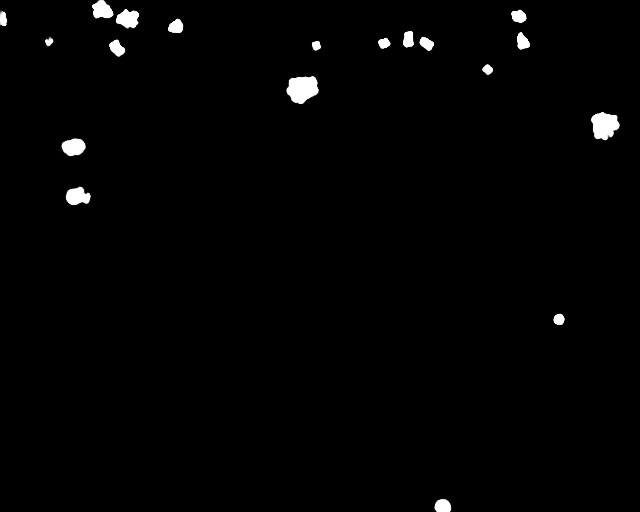

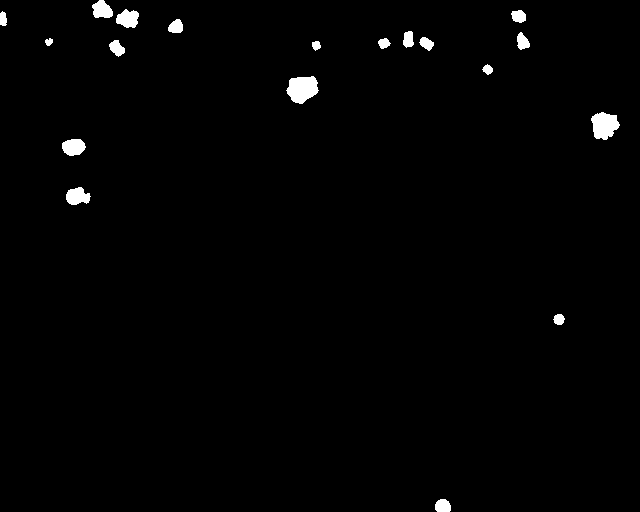

(2, 1, 512, 640)
(1, 512, 640)


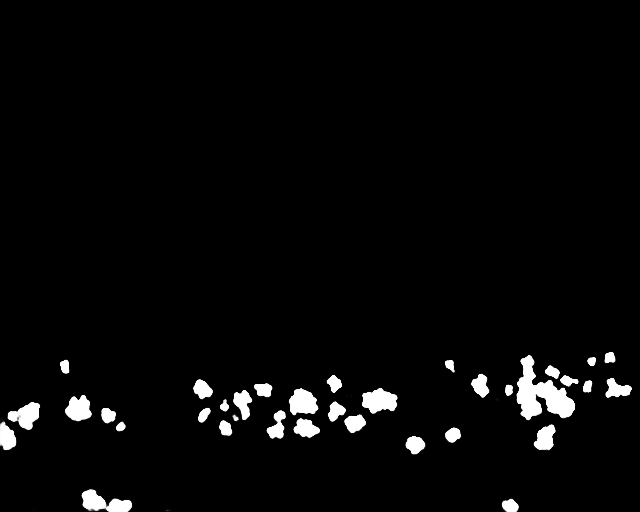

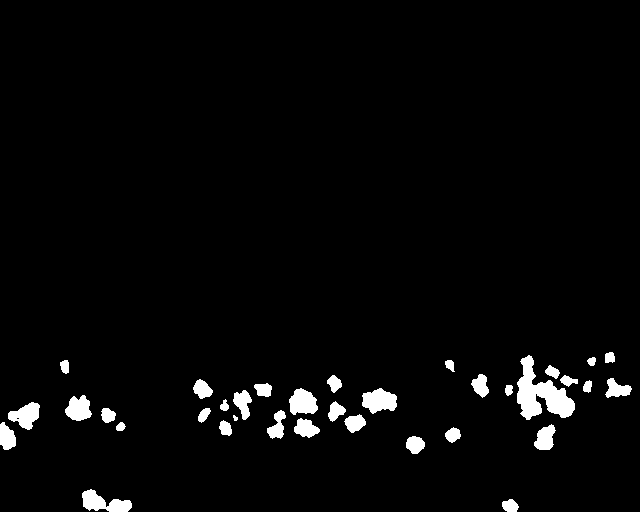

(2, 1, 512, 640)
(1, 512, 640)


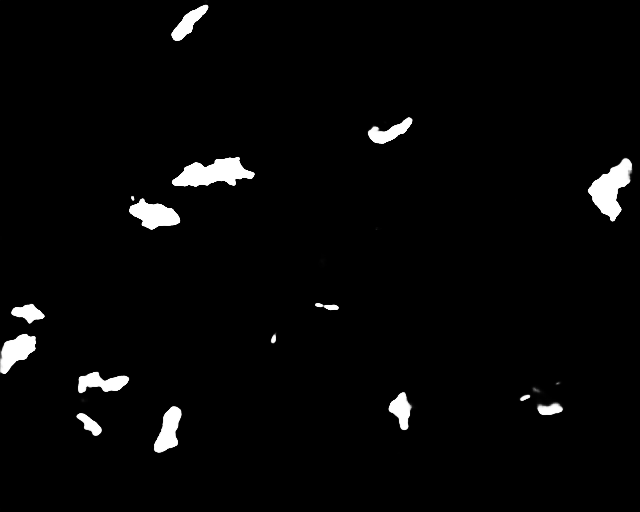

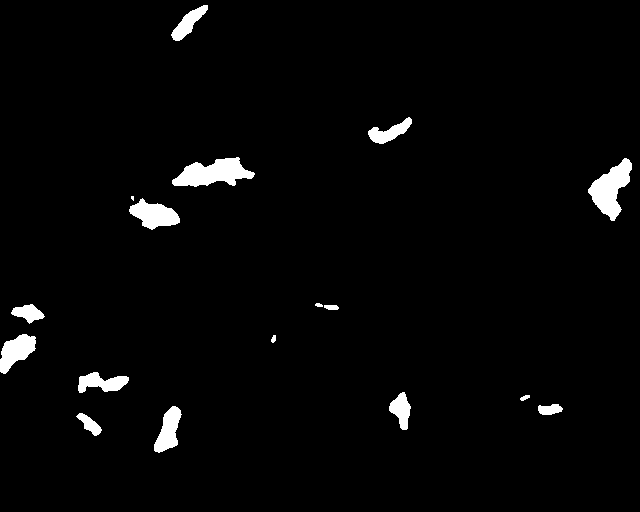

(2, 1, 512, 640)
(1, 512, 640)


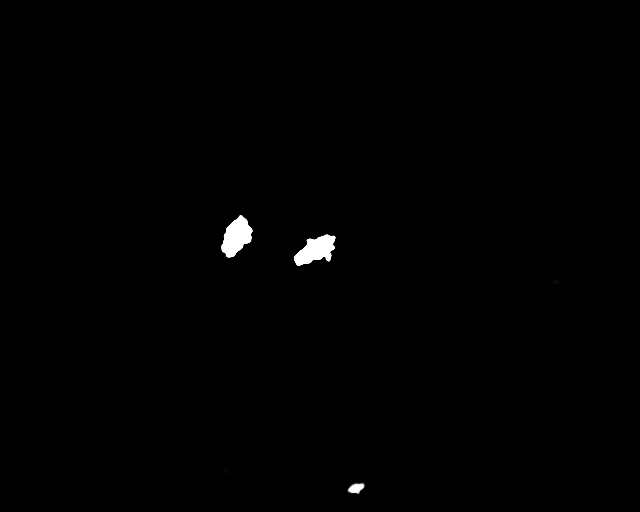

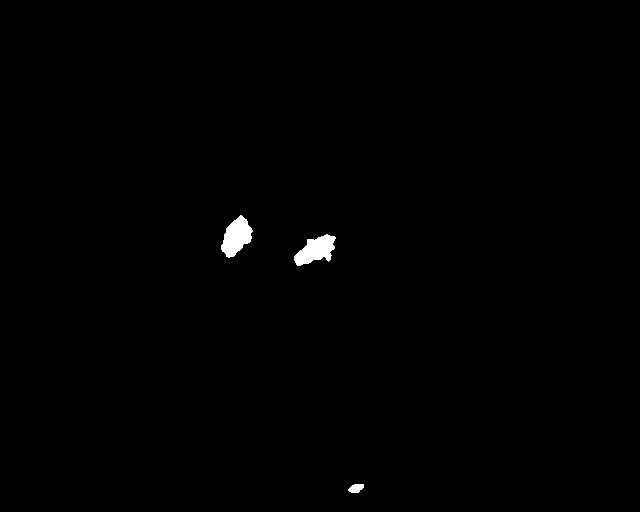

(2, 1, 512, 640)
(1, 512, 640)


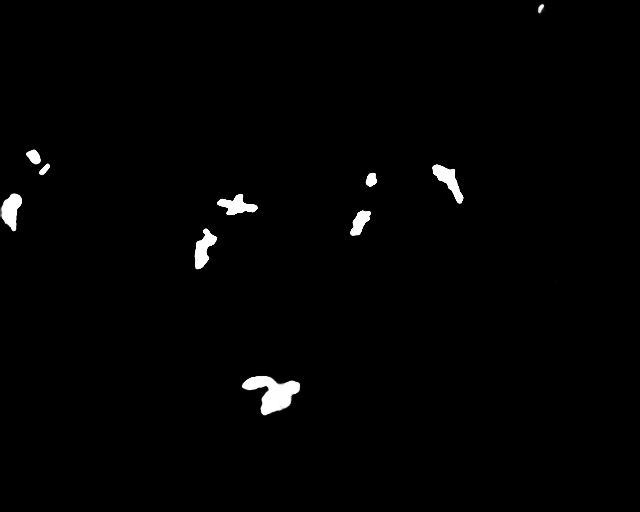

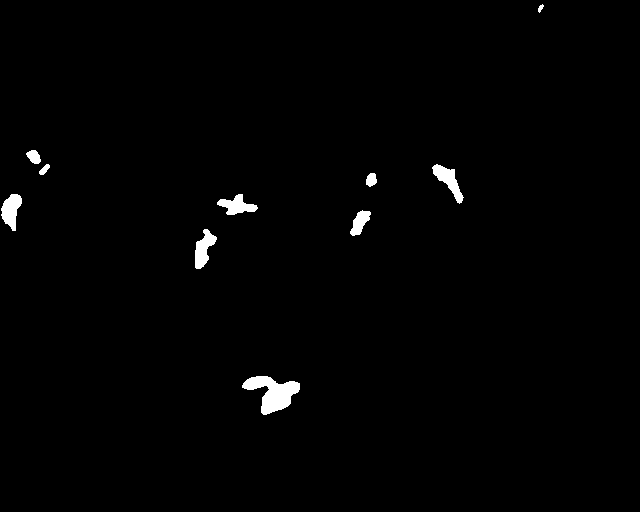

(2, 1, 512, 640)
(1, 512, 640)


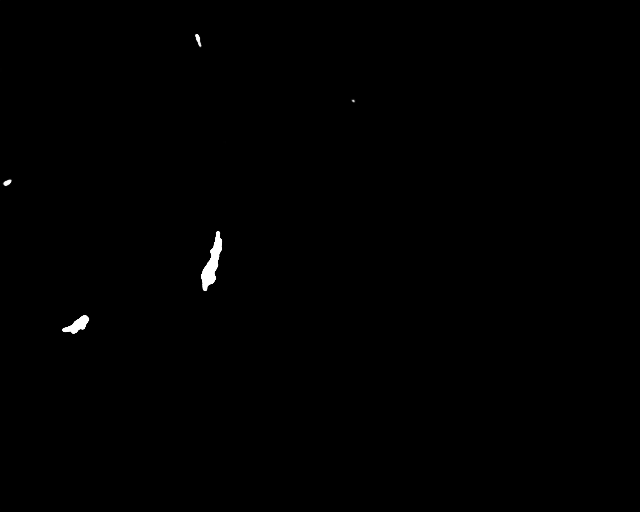

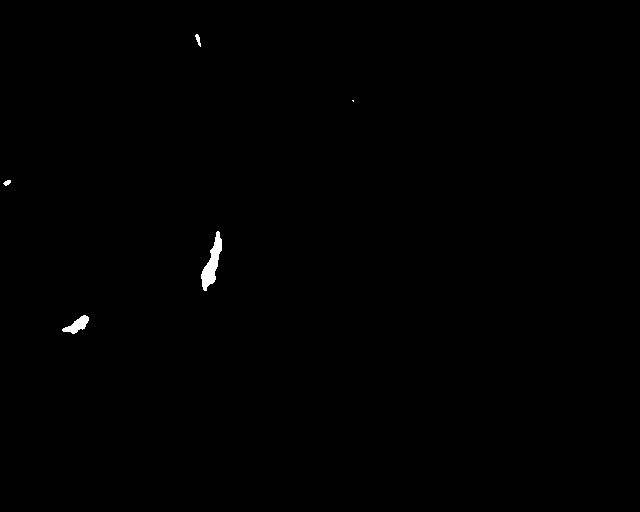

(2, 1, 512, 640)
(1, 512, 640)


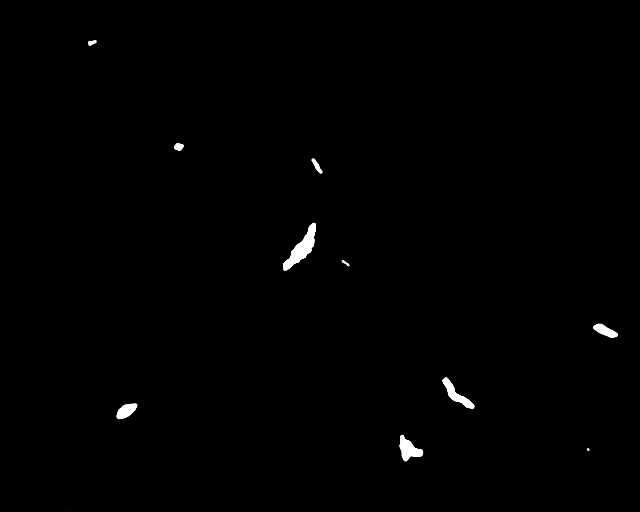

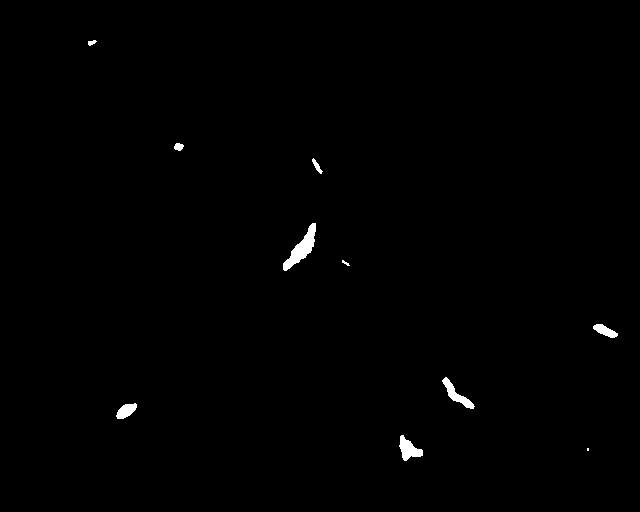

(2, 1, 512, 640)
(1, 512, 640)


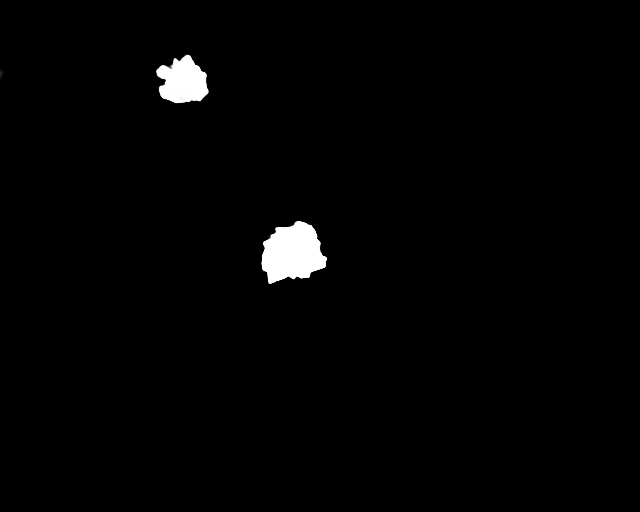

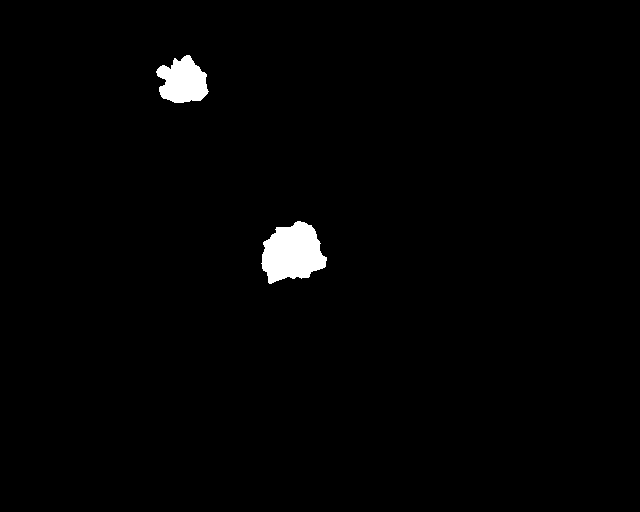

(2, 1, 512, 640)
(1, 512, 640)


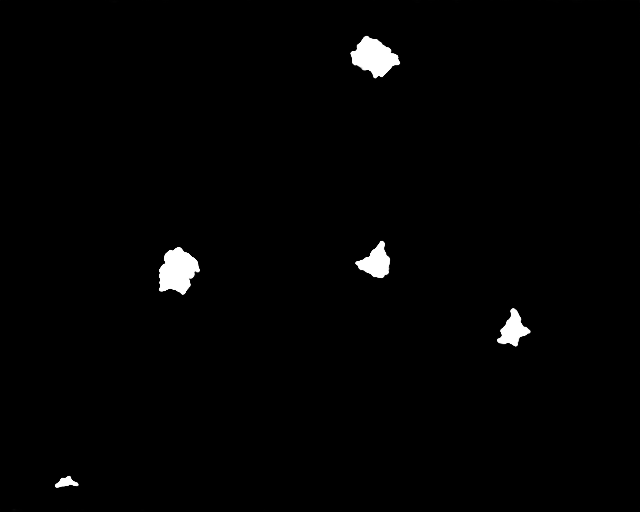

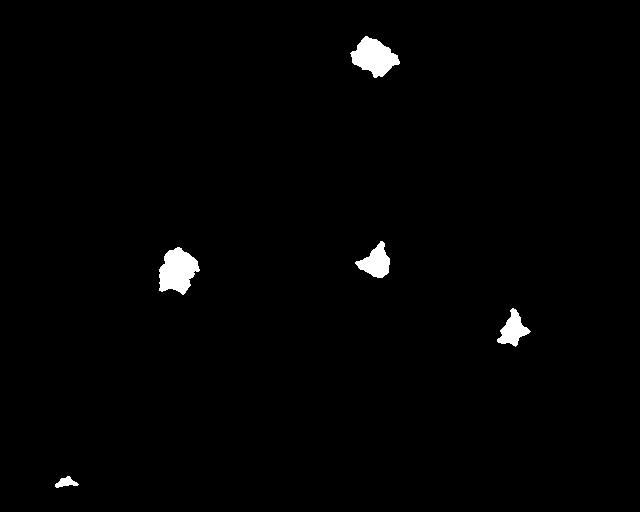

(2, 1, 512, 640)
(1, 512, 640)


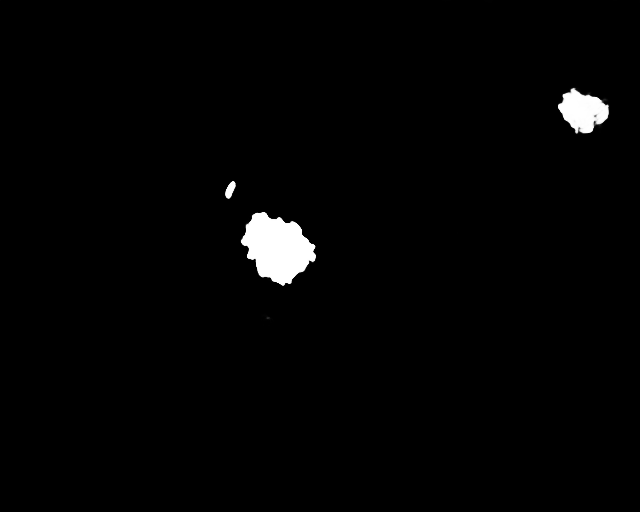

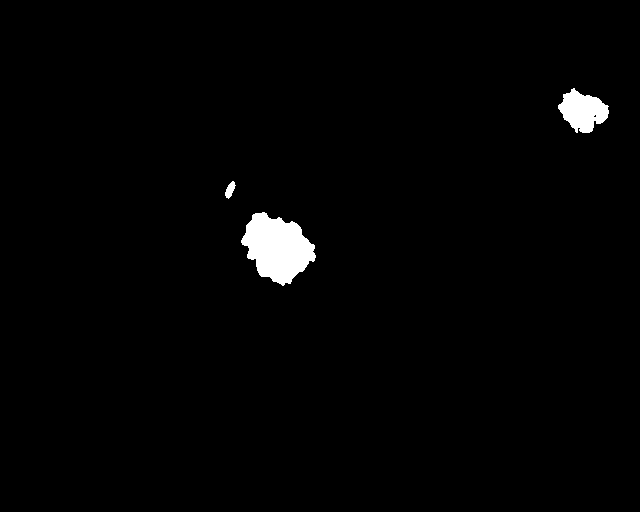

(2, 1, 512, 640)
(1, 512, 640)


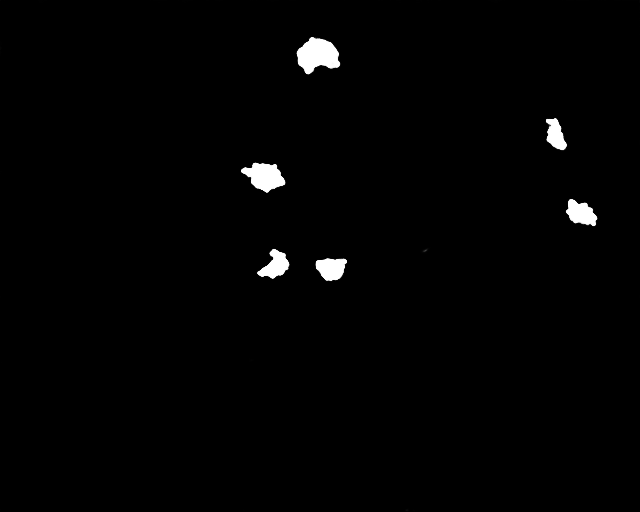

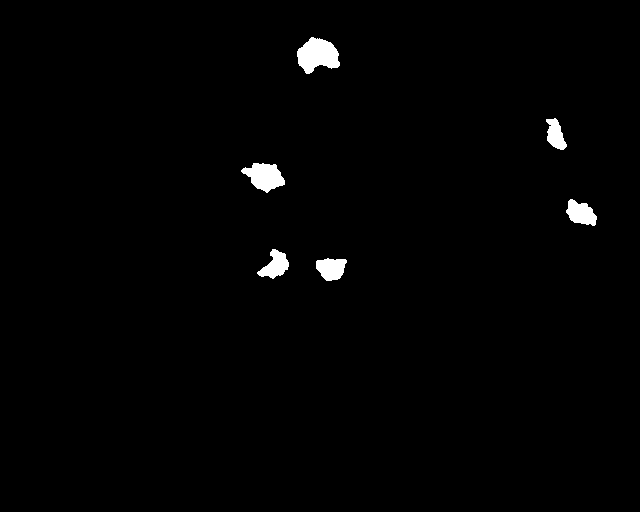

(2, 1, 512, 640)
(1, 512, 640)


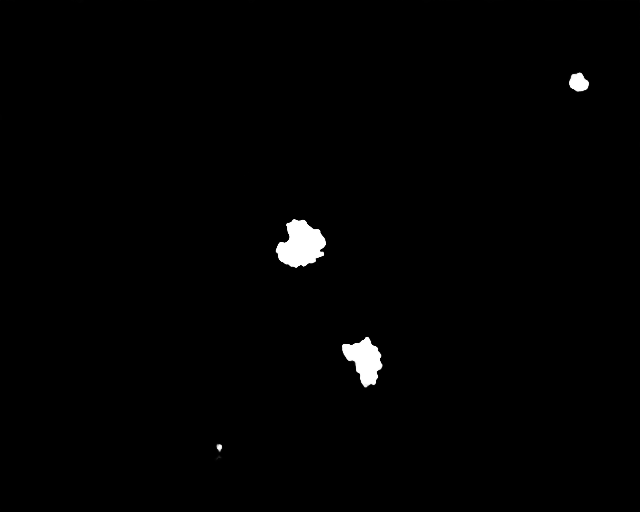

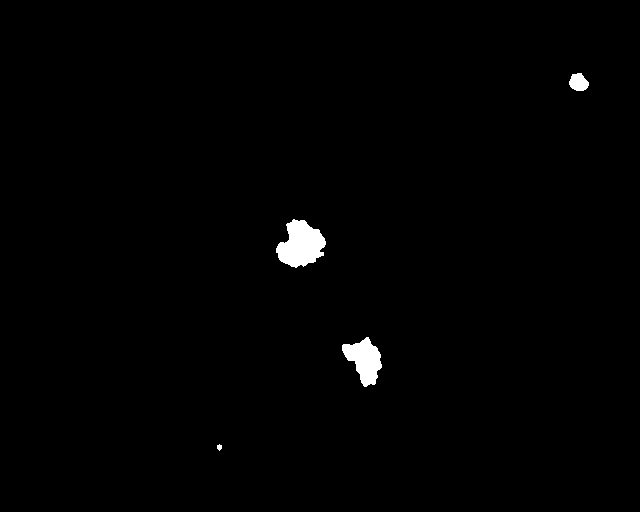

(2, 1, 512, 640)
(1, 512, 640)


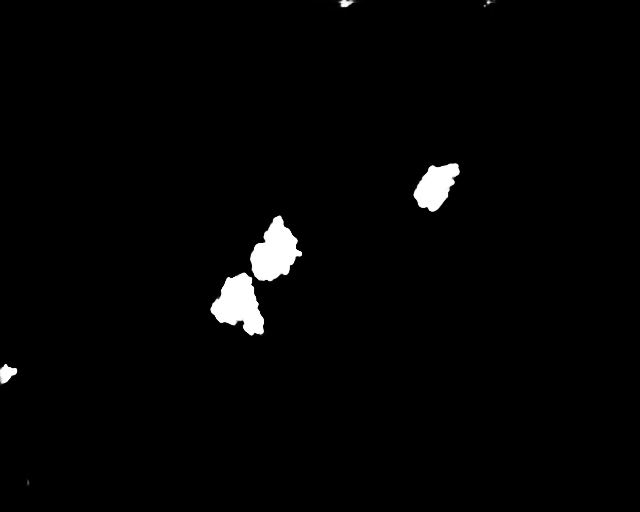

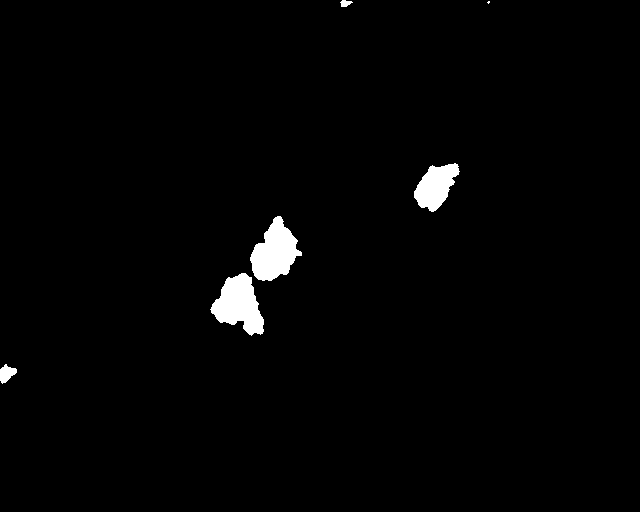

(2, 1, 512, 640)
(1, 512, 640)


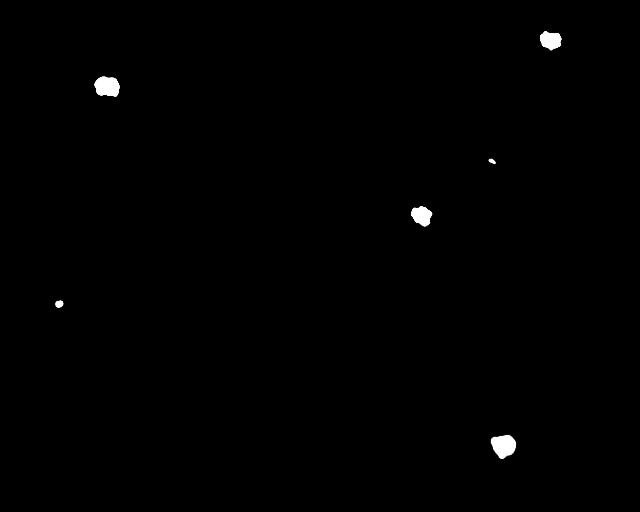

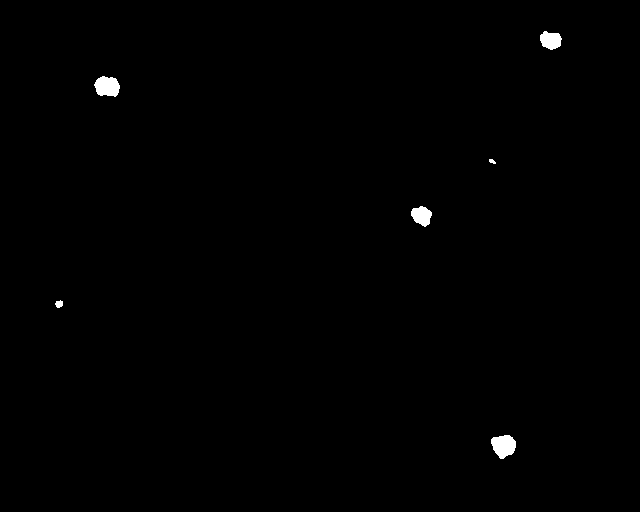

(2, 1, 512, 640)
(1, 512, 640)


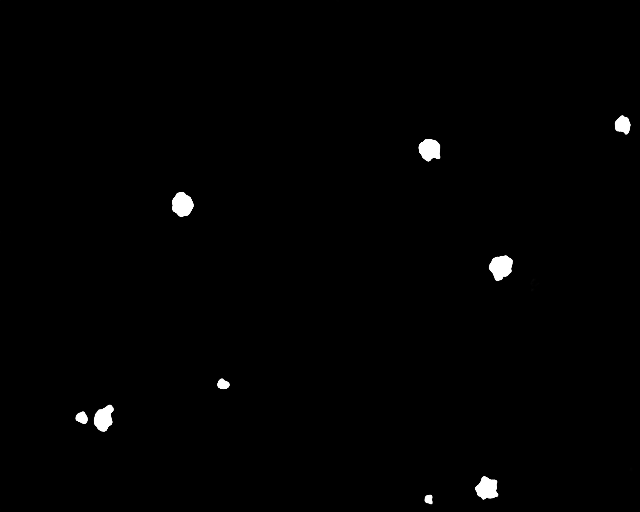

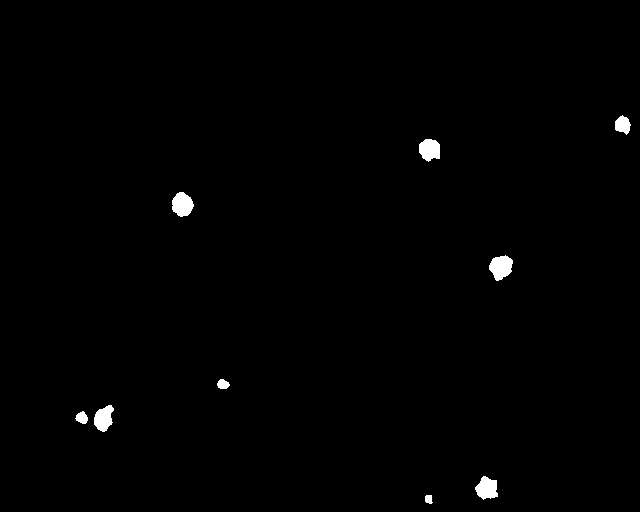

(2, 1, 512, 640)
(1, 512, 640)


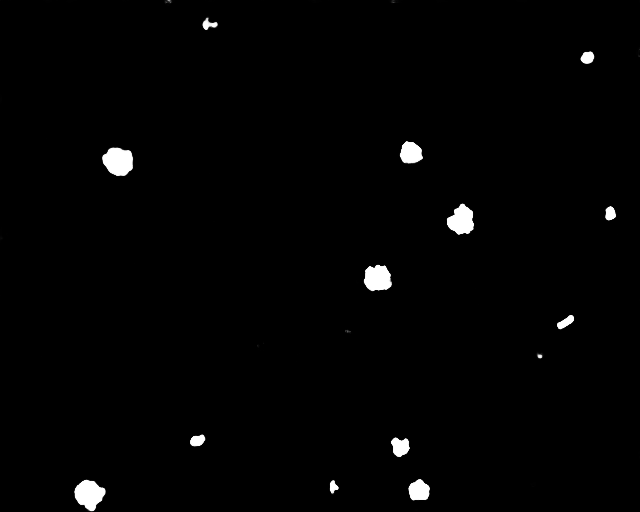

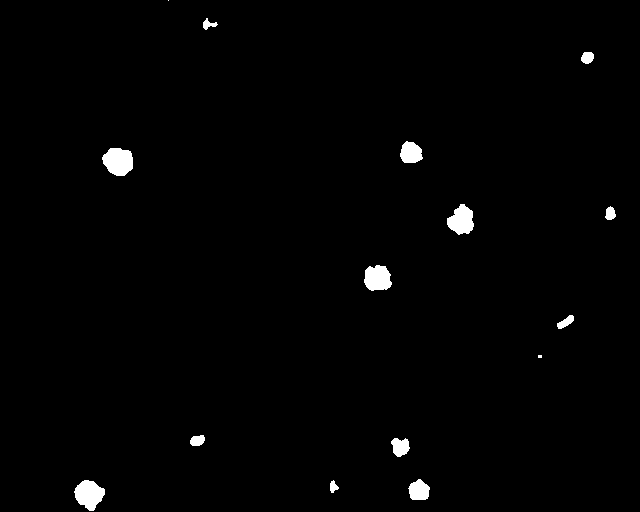

(2, 1, 512, 640)
(1, 512, 640)


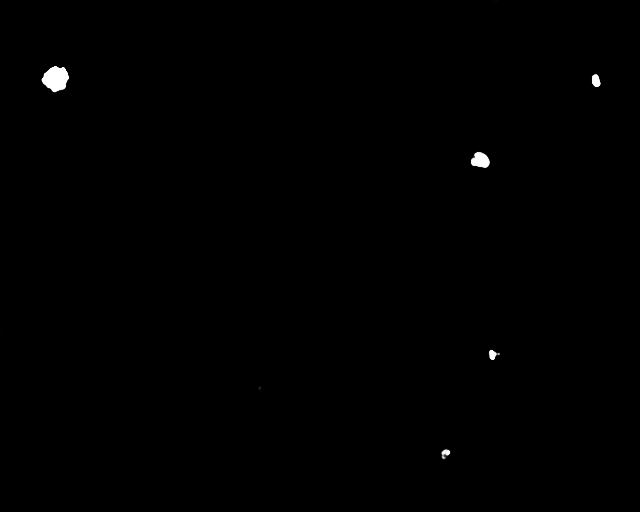

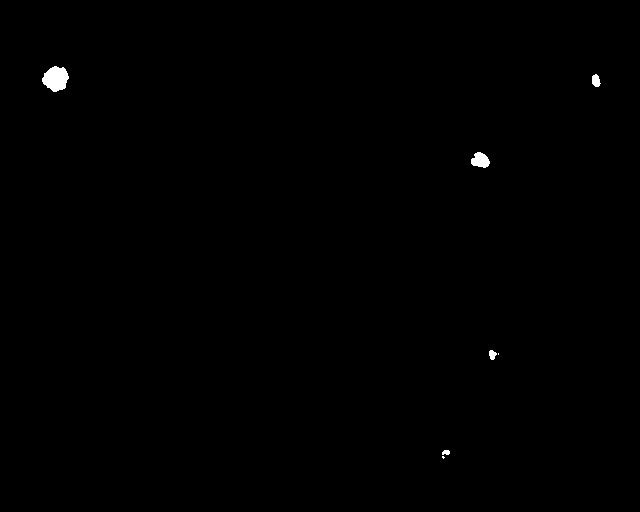

(2, 1, 512, 640)
(1, 512, 640)


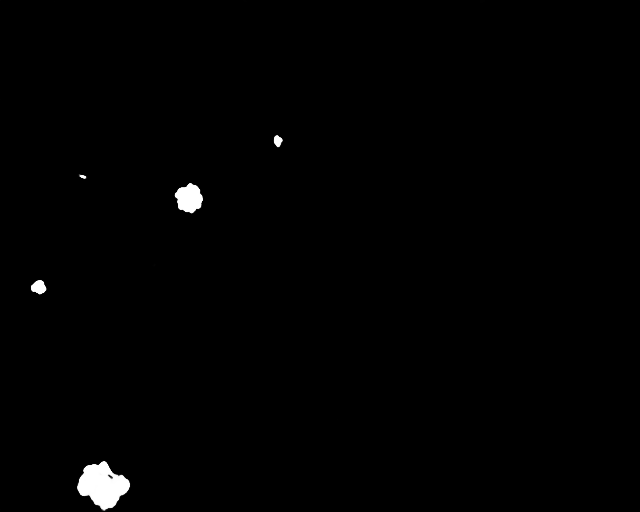

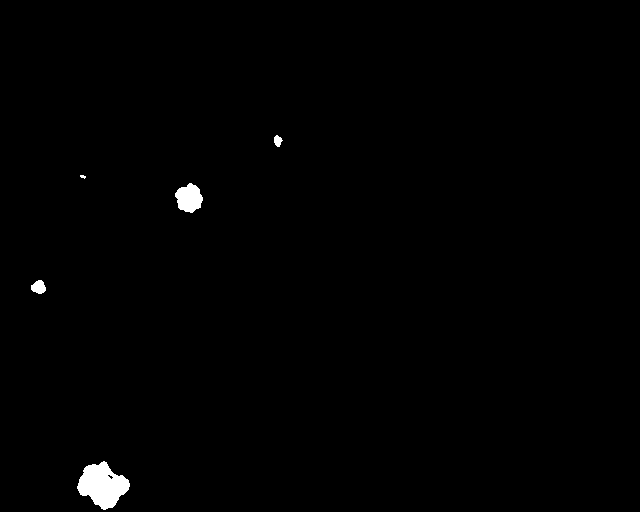

(2, 1, 512, 640)
(1, 512, 640)


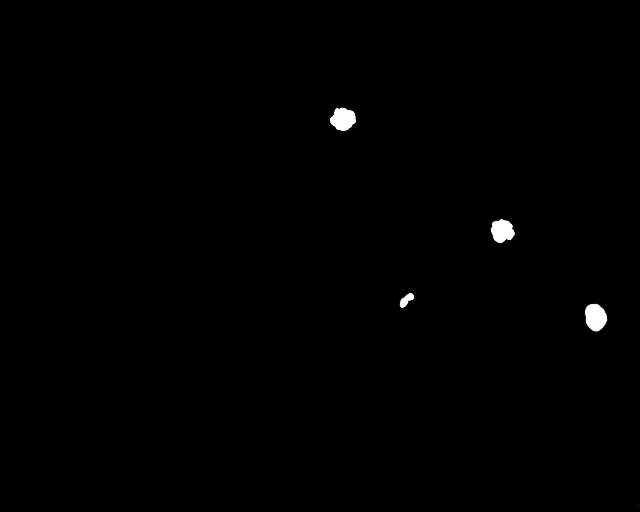

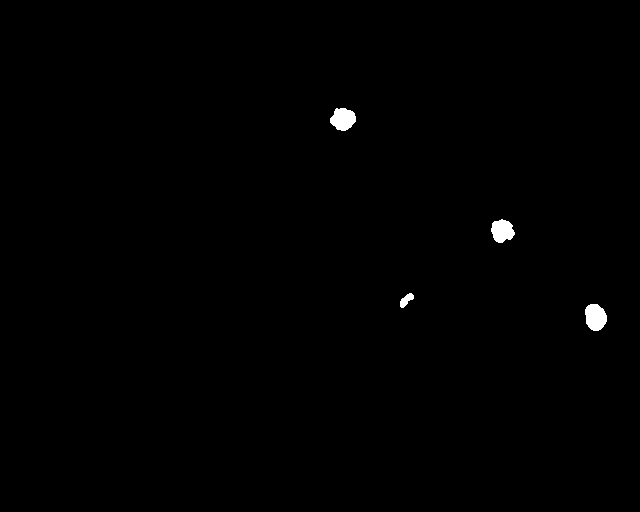

(2, 1, 512, 640)
(1, 512, 640)


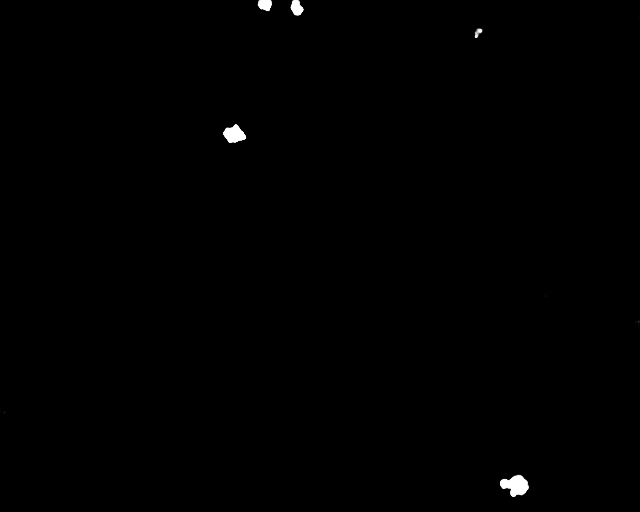

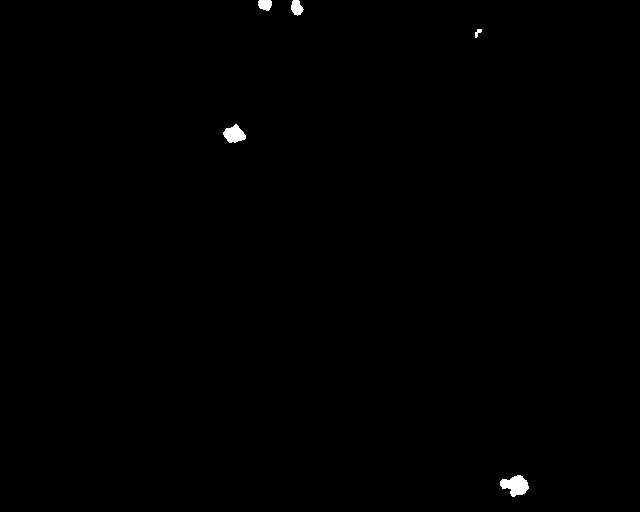

(2, 1, 512, 640)
(1, 512, 640)


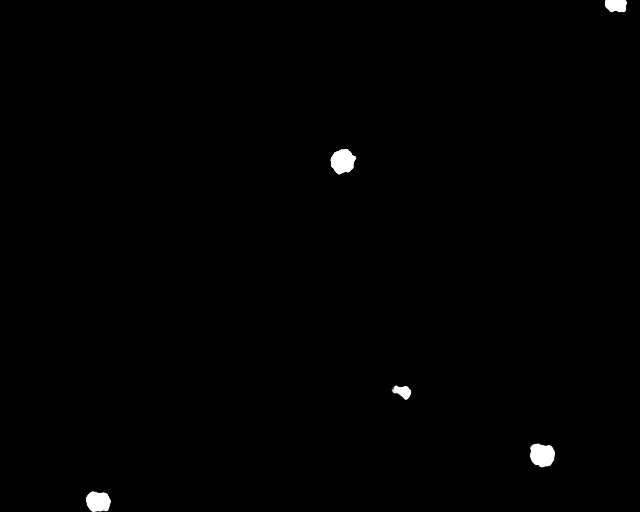

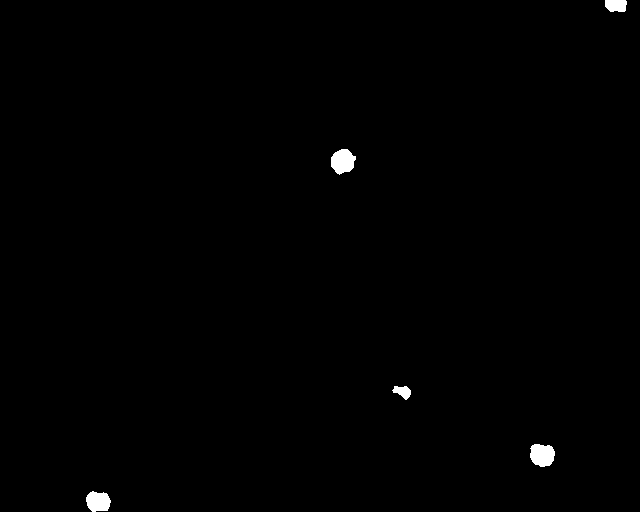

(2, 1, 512, 640)
(1, 512, 640)


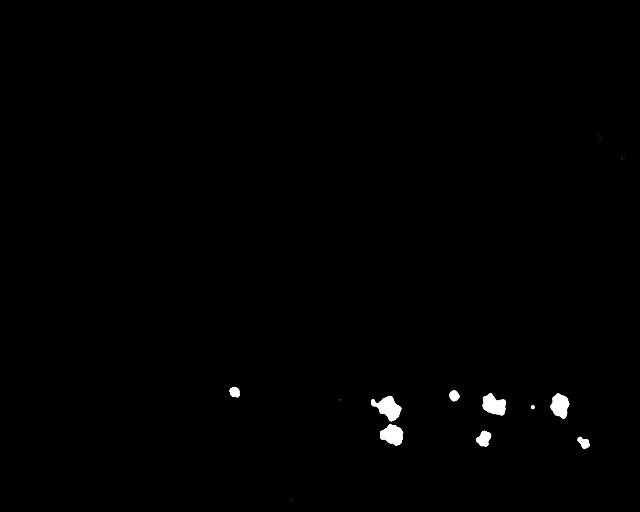

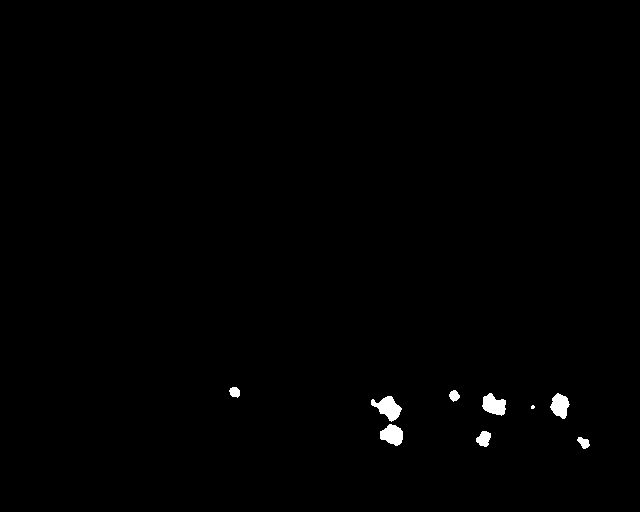

(2, 1, 512, 640)
(1, 512, 640)


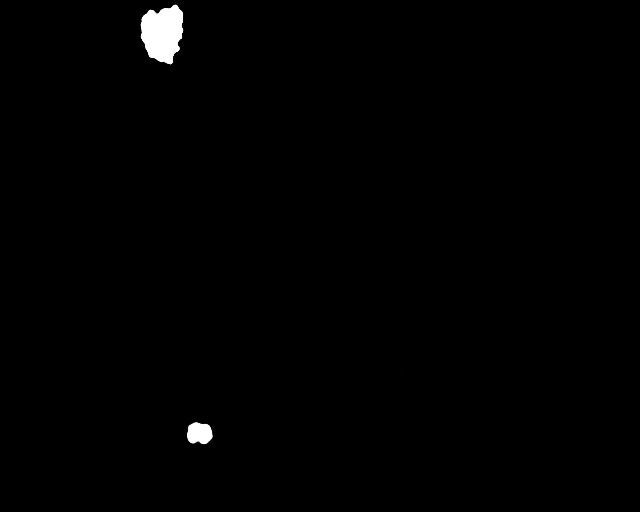

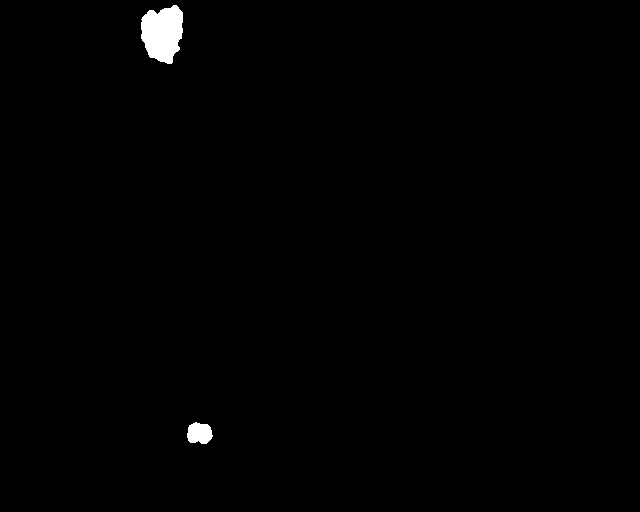

(2, 1, 512, 640)
(1, 512, 640)


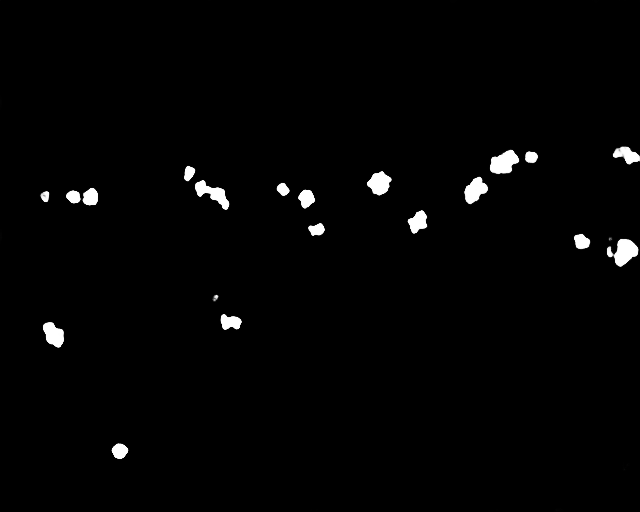

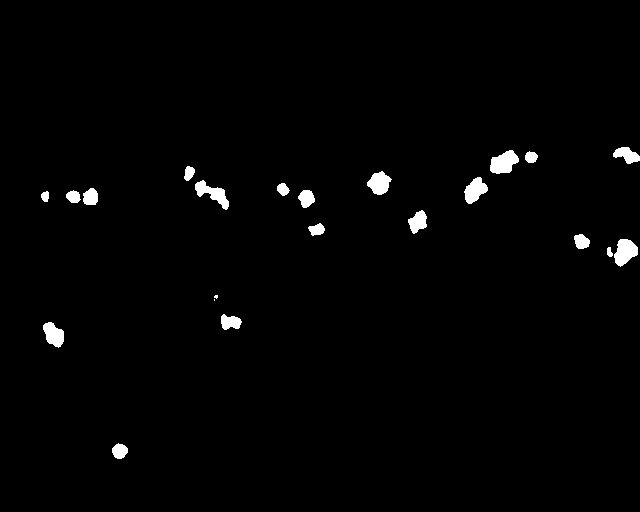

(2, 1, 512, 640)
(1, 512, 640)


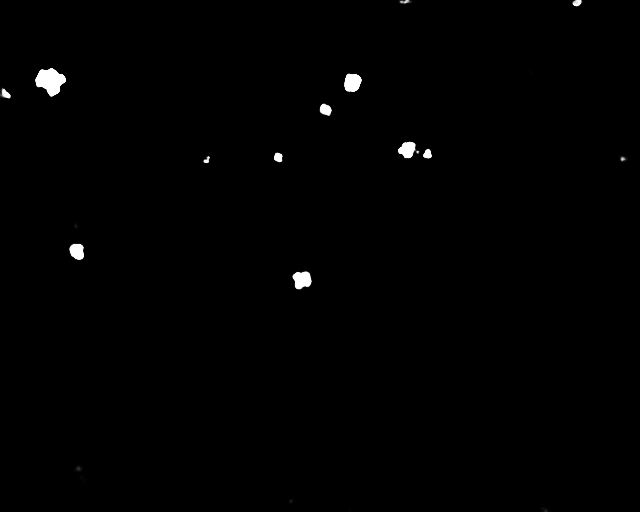

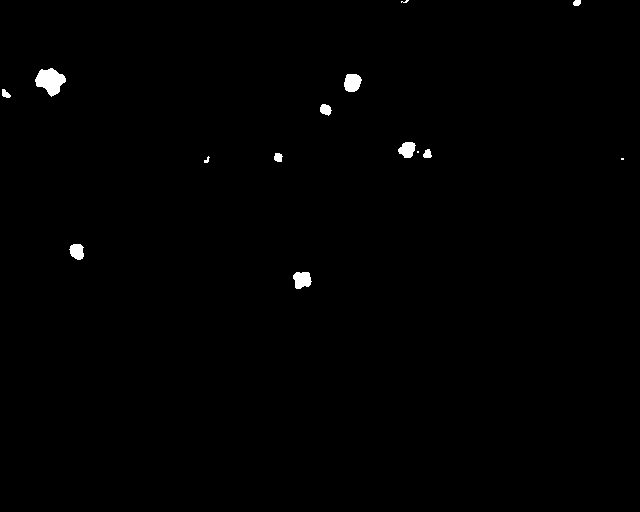

(2, 1, 512, 640)
(1, 512, 640)


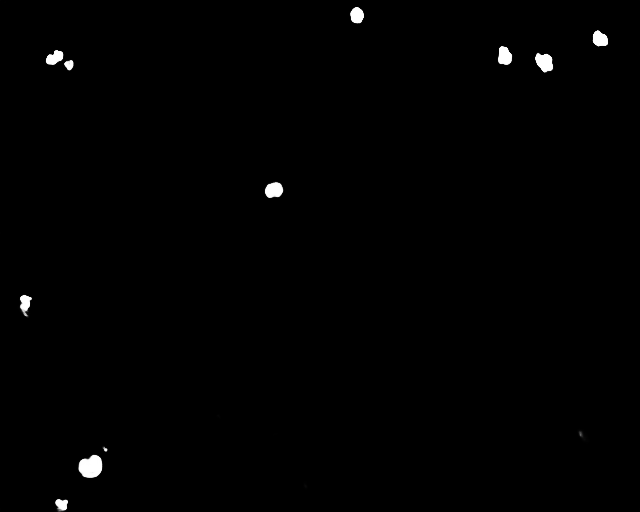

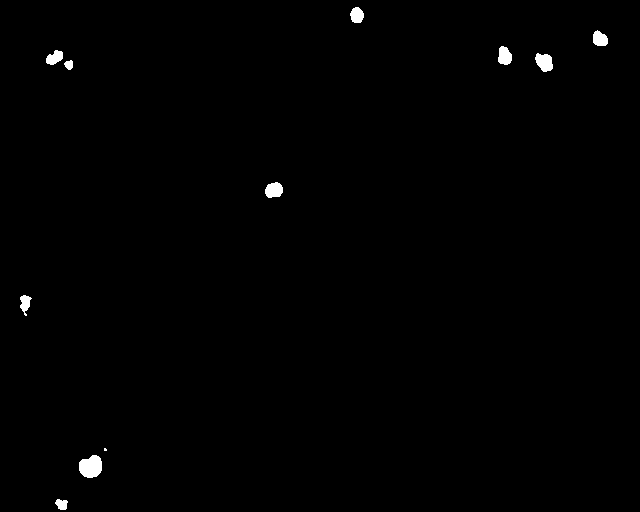

(2, 1, 512, 640)
(1, 512, 640)


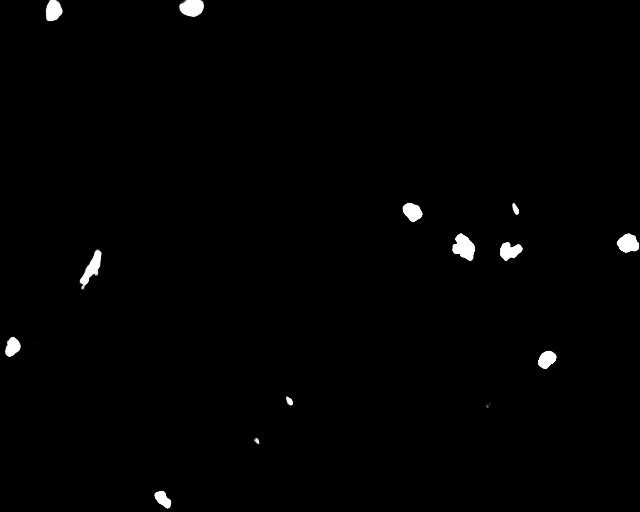

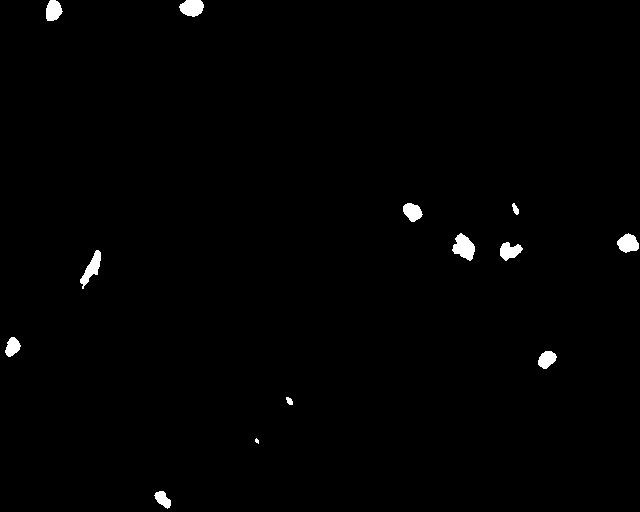

(2, 1, 512, 640)
(1, 512, 640)


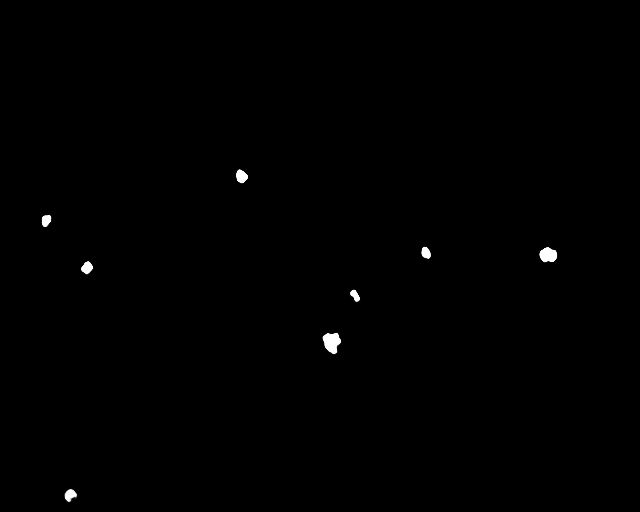

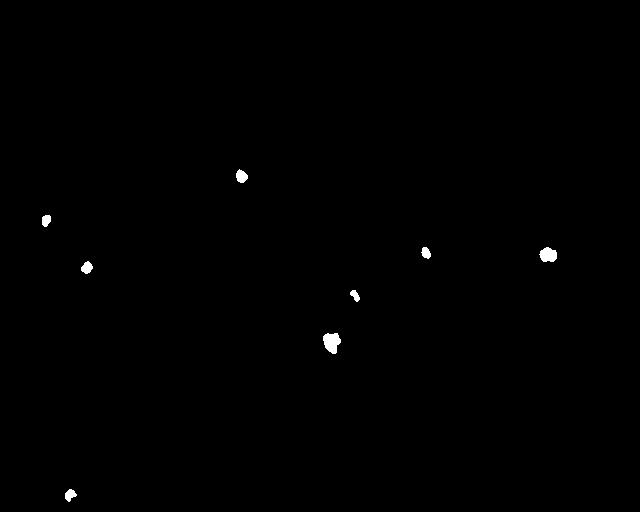

(2, 1, 512, 640)
(1, 512, 640)


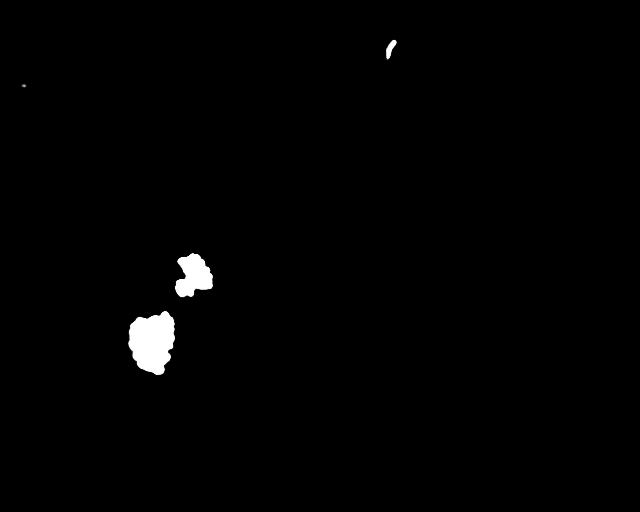

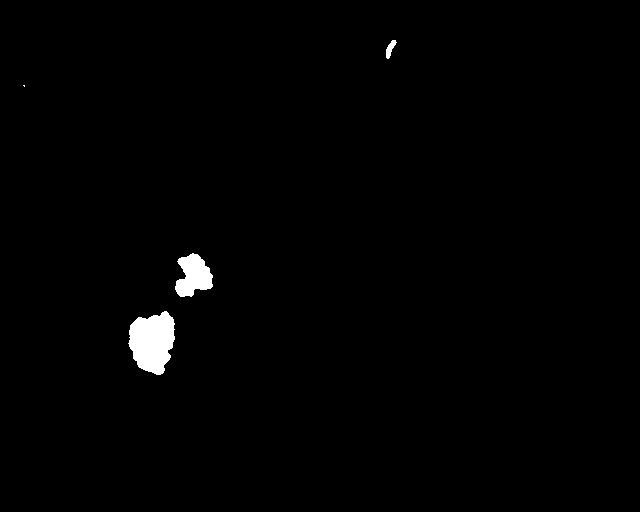

(2, 1, 512, 640)
(1, 512, 640)


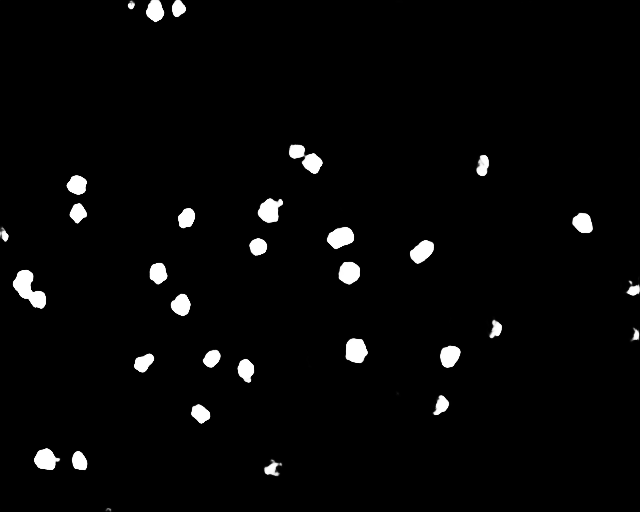

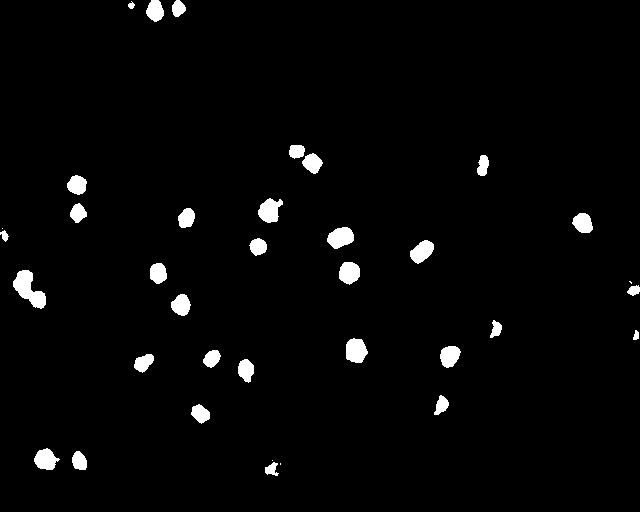

(2, 1, 512, 640)
(1, 512, 640)


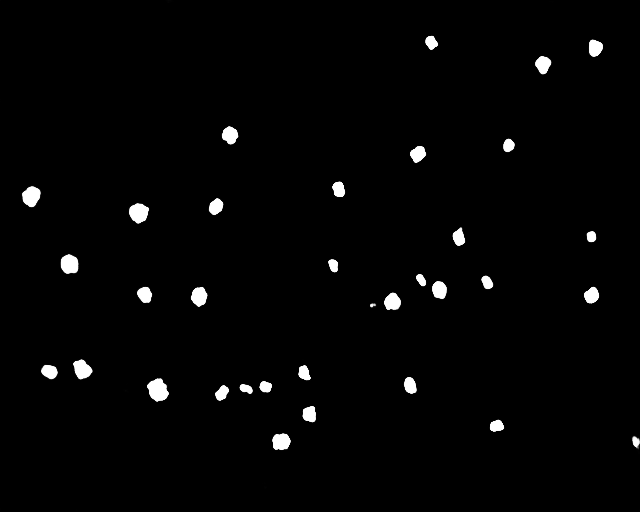

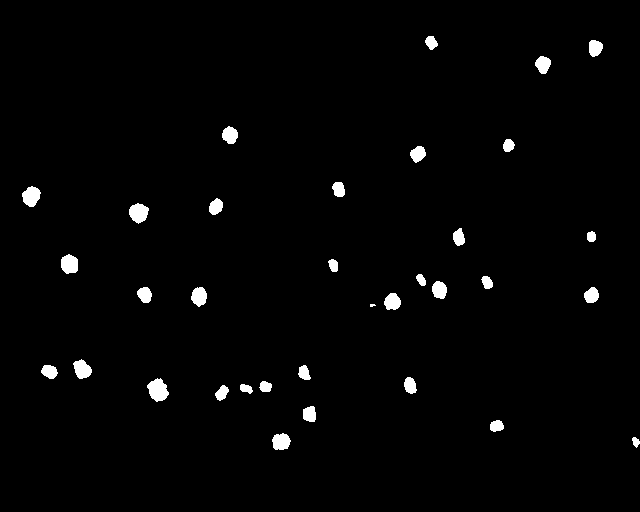

(2, 1, 512, 640)
(1, 512, 640)


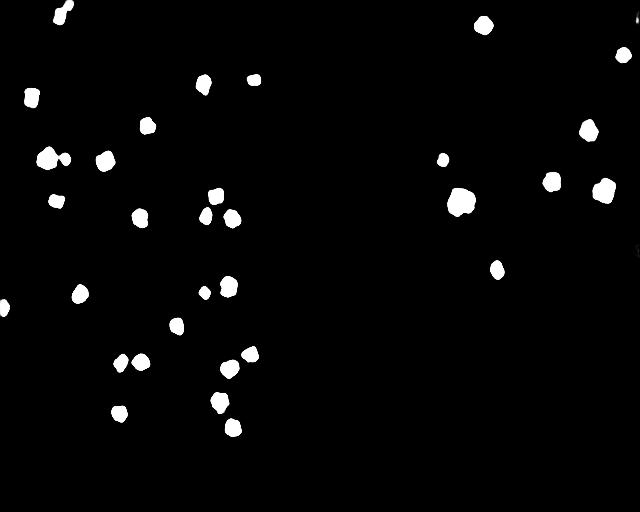

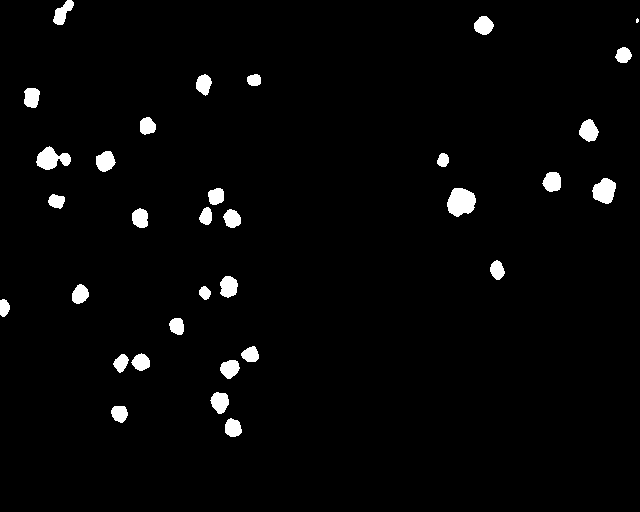

(2, 1, 512, 640)
(1, 512, 640)


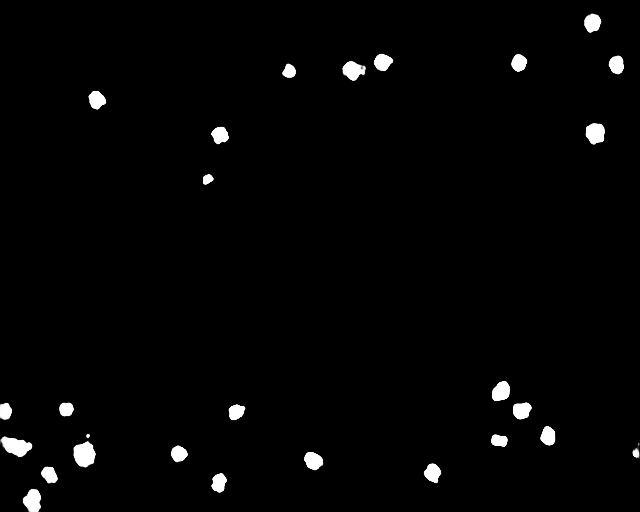

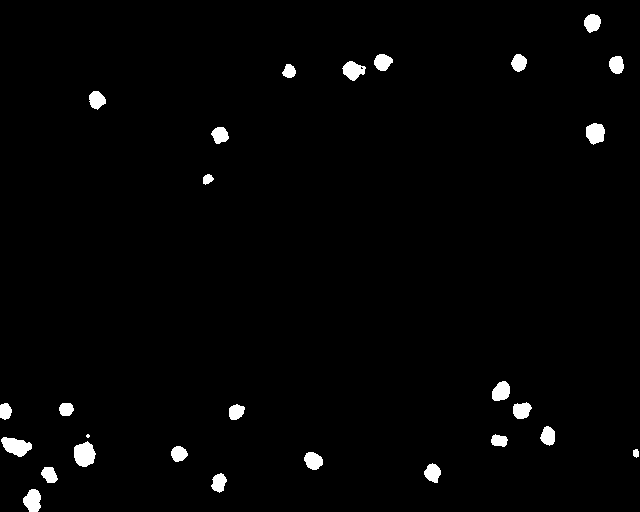

(2, 1, 512, 640)
(1, 512, 640)


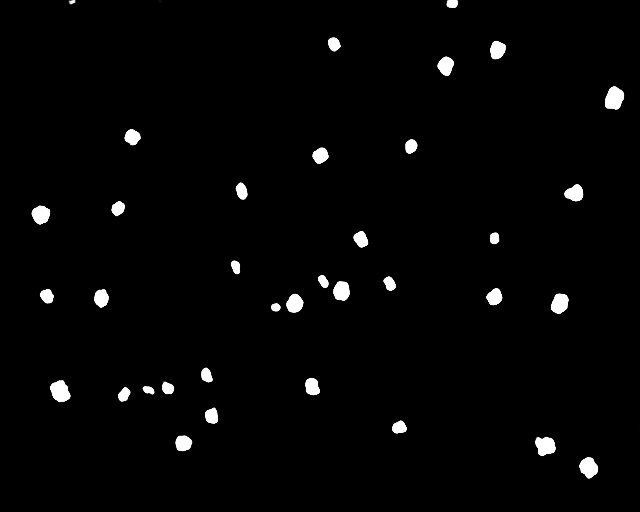

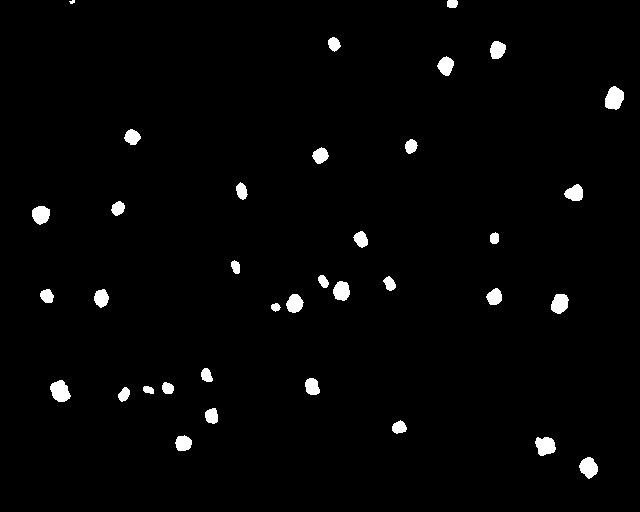

(2, 1, 512, 640)
(1, 512, 640)


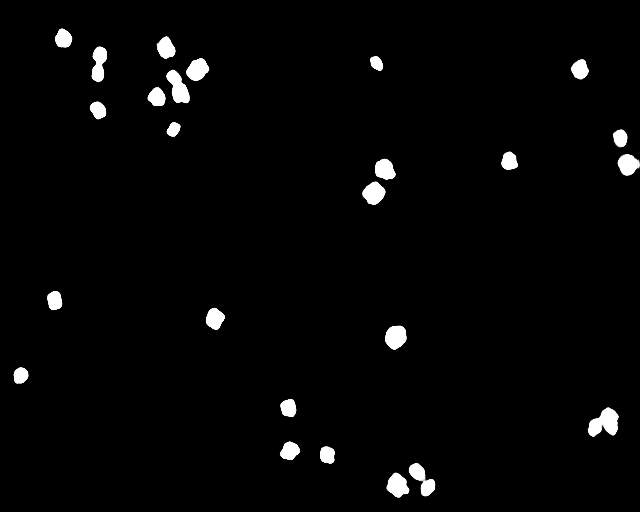

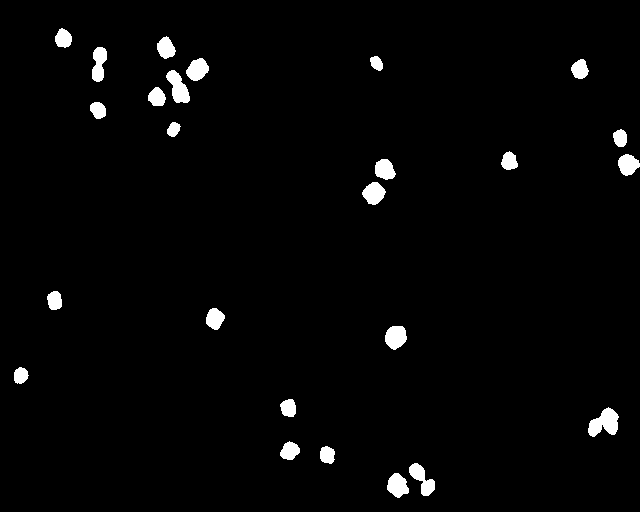

(2, 1, 512, 640)
(1, 512, 640)


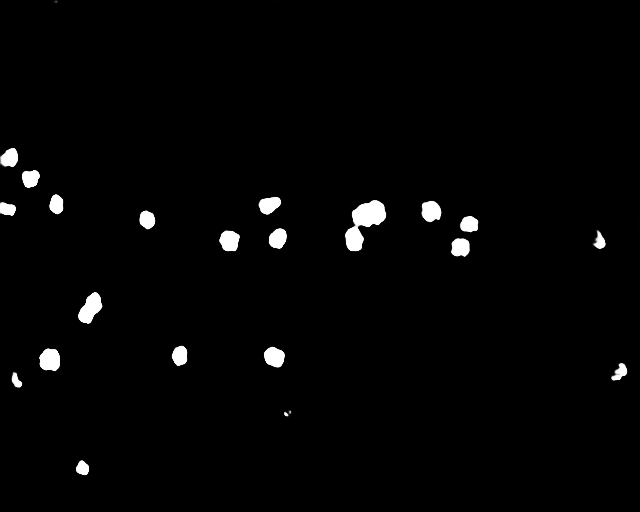

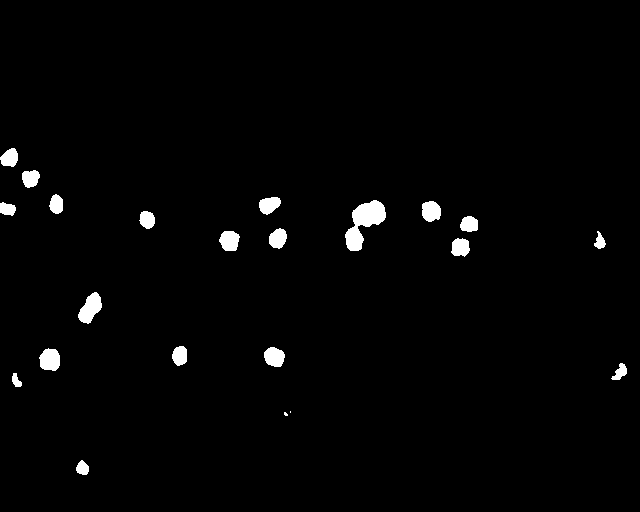

(2, 1, 512, 640)
(1, 512, 640)


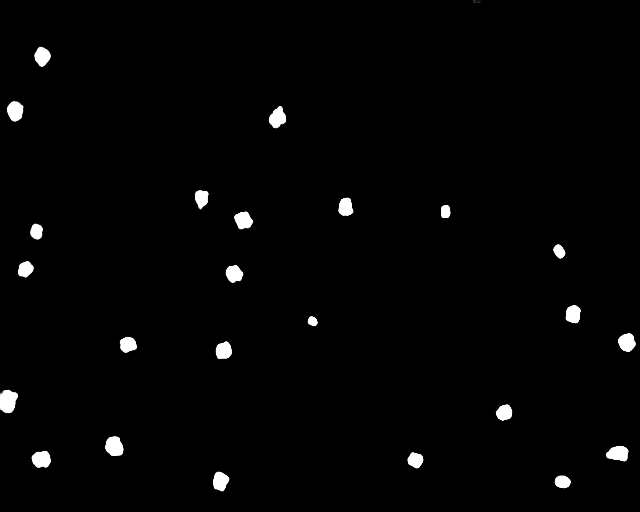

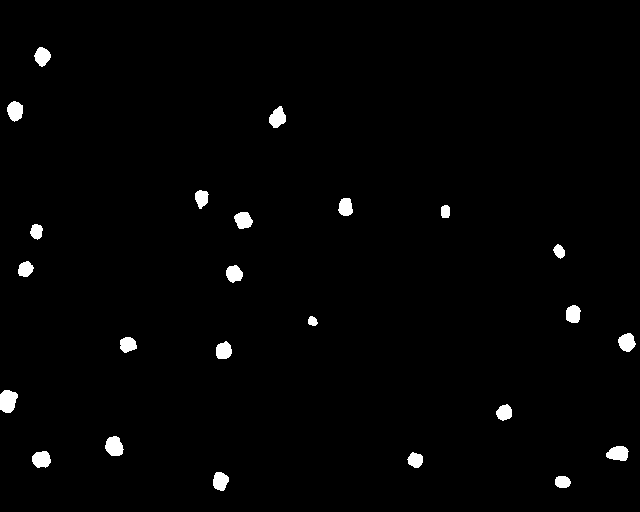

(2, 1, 512, 640)
(1, 512, 640)


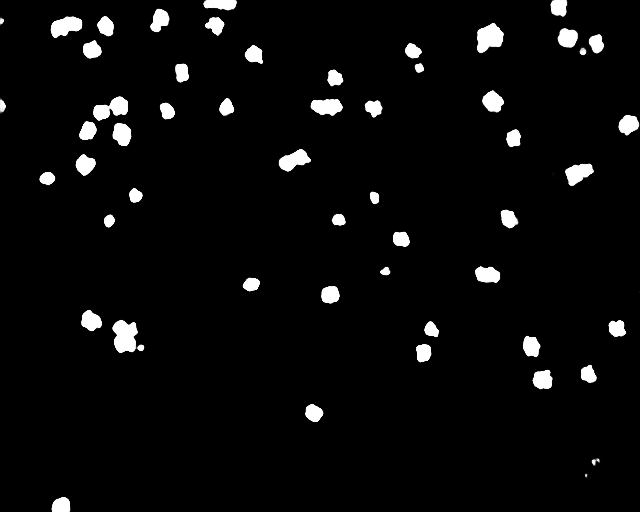

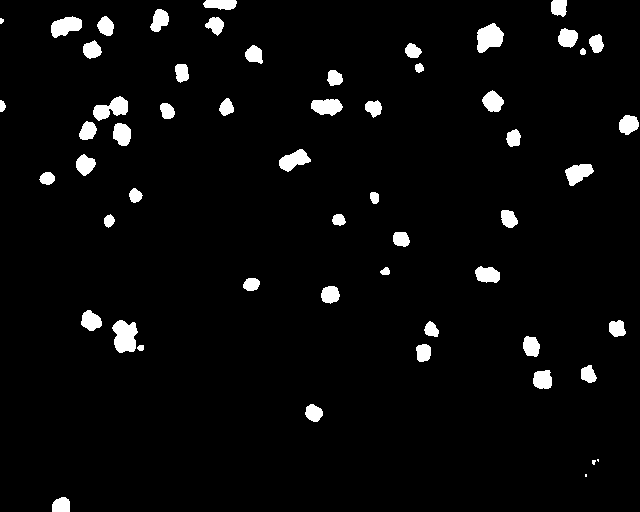

(2, 1, 512, 640)
(1, 512, 640)


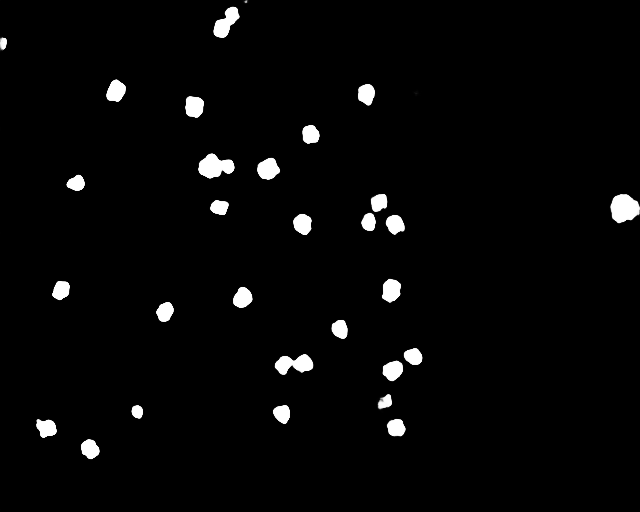

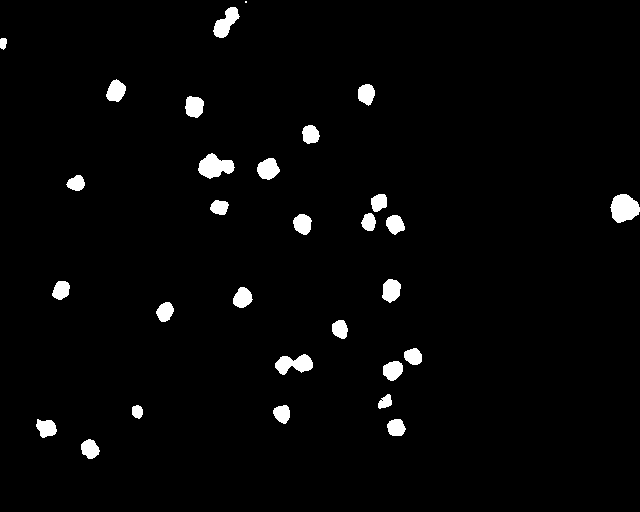

(2, 1, 512, 640)
(1, 512, 640)


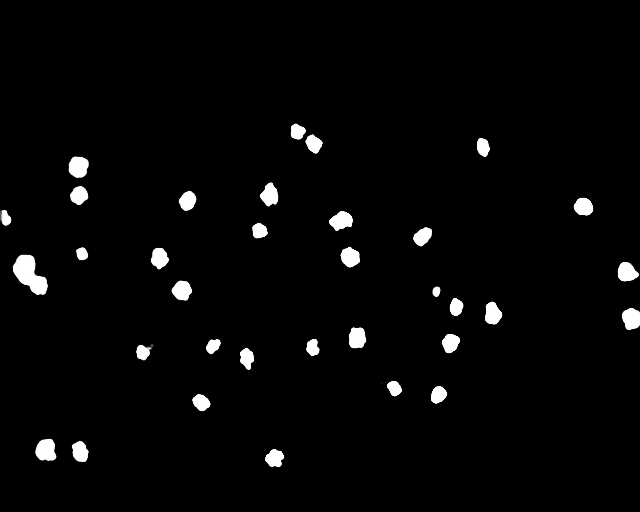

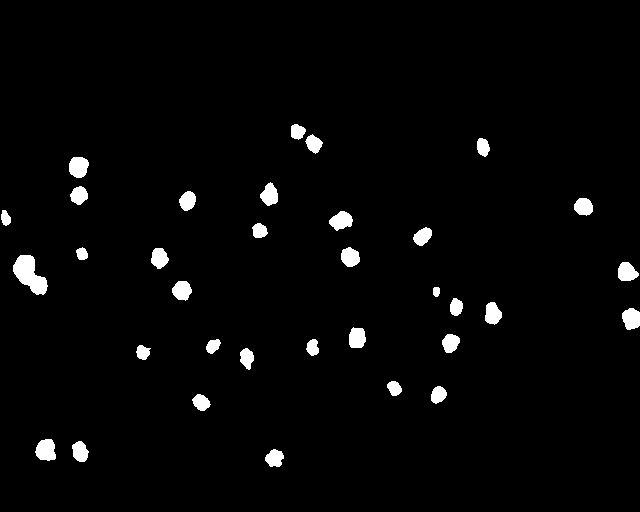

(2, 1, 512, 640)
(1, 512, 640)


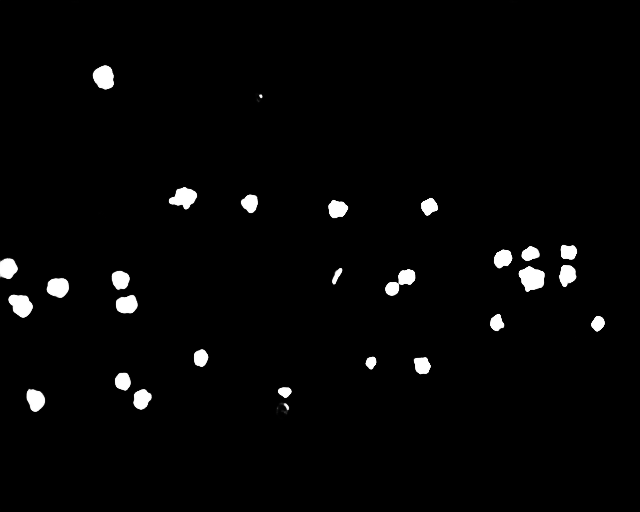

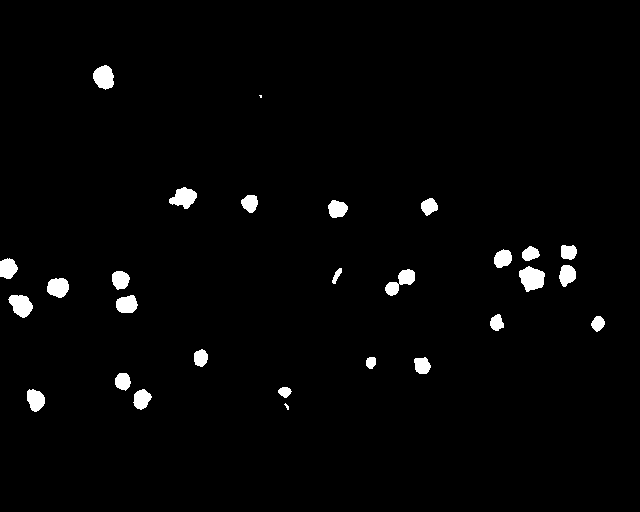

(2, 1, 512, 640)
(1, 512, 640)


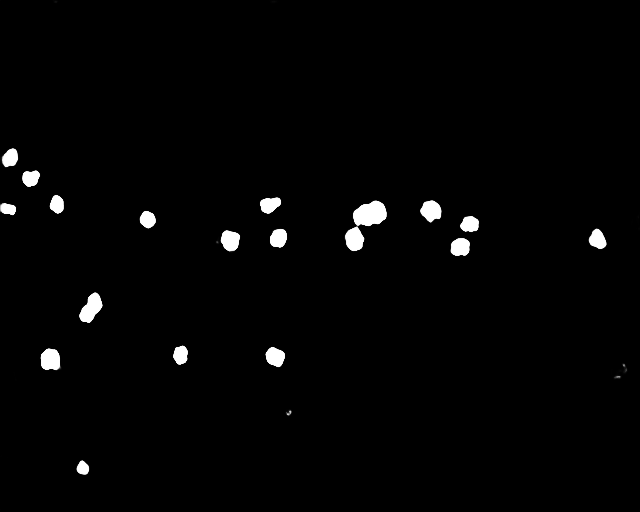

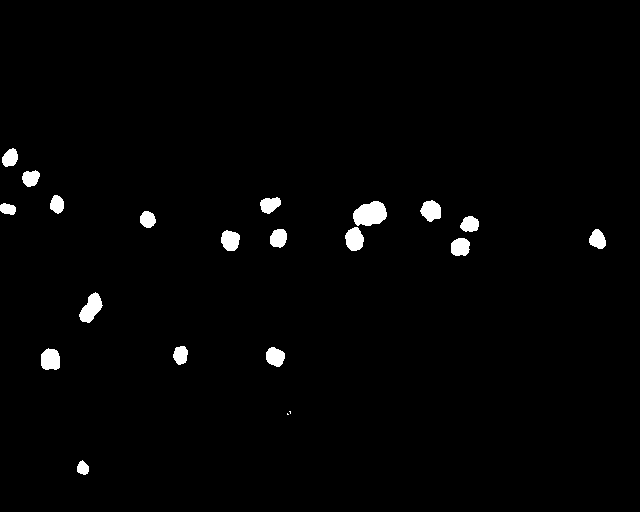

(2, 1, 512, 640)
(1, 512, 640)


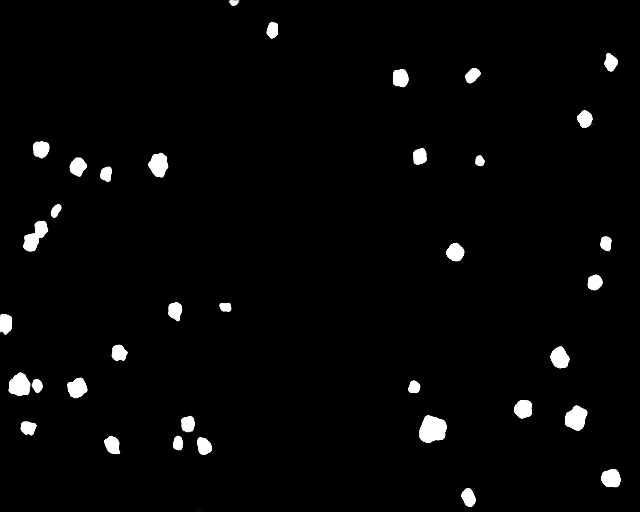

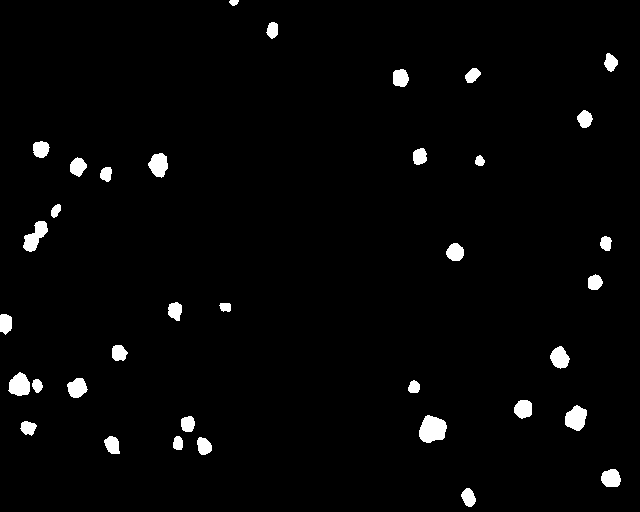

(2, 1, 512, 640)
(1, 512, 640)


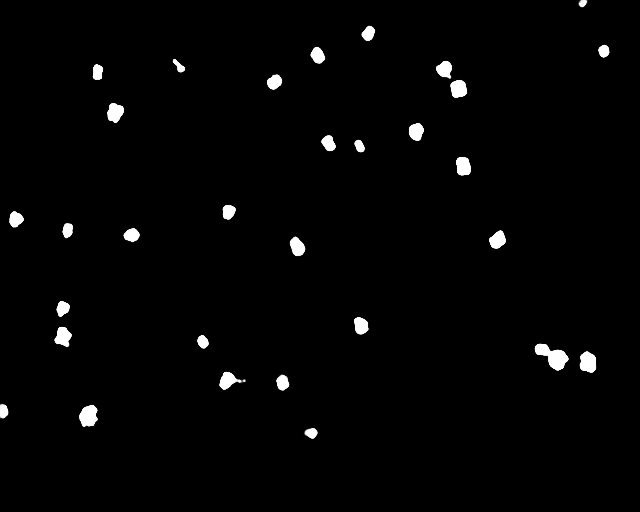

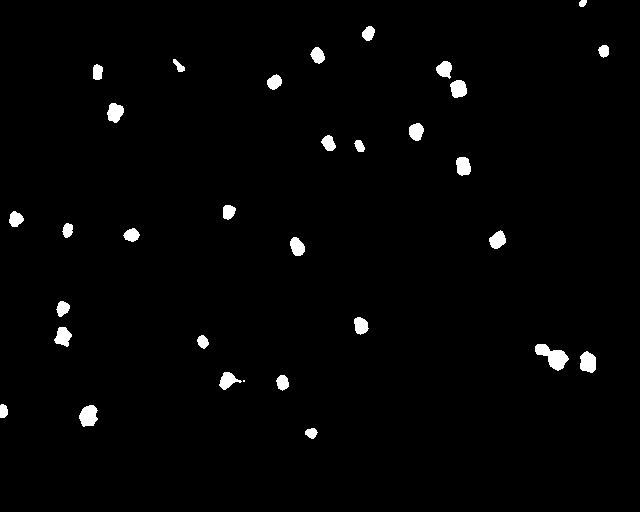

(2, 1, 512, 640)
(1, 512, 640)


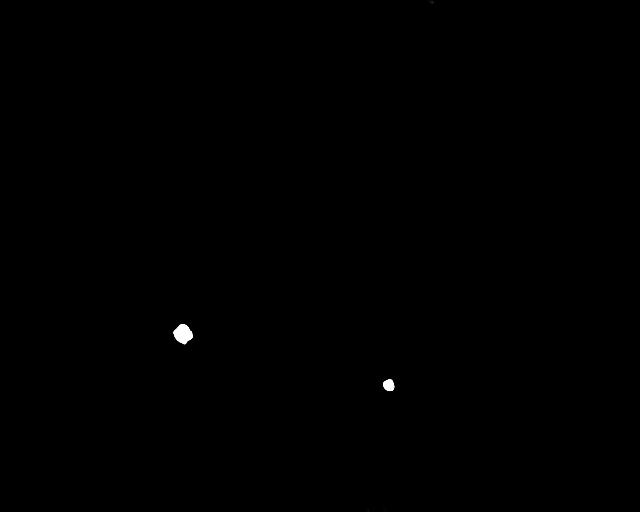

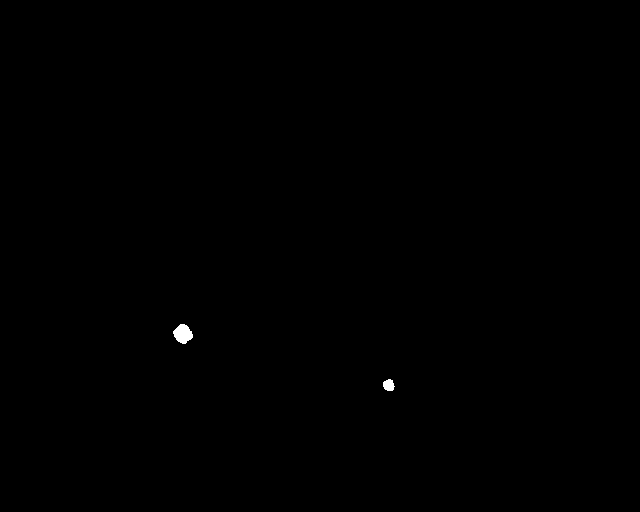

(2, 1, 512, 640)
(1, 512, 640)


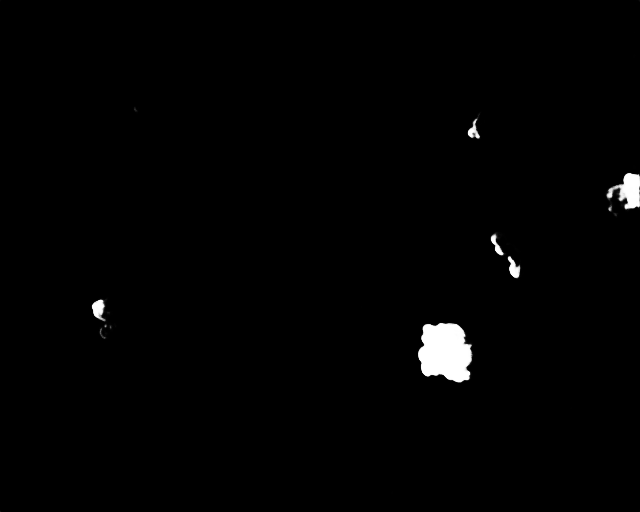

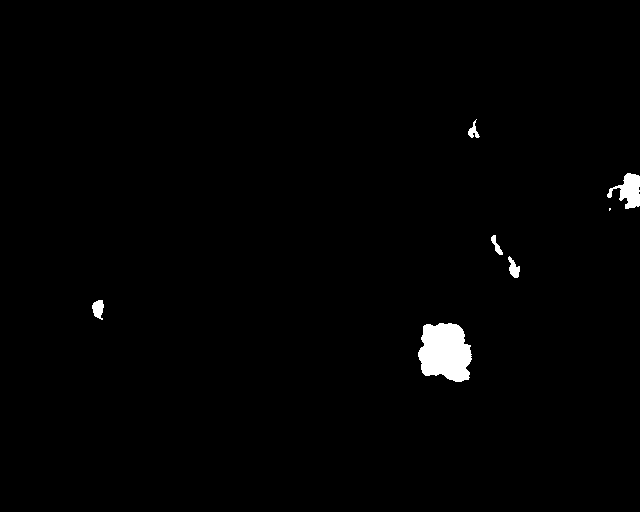

(2, 1, 512, 640)
(1, 512, 640)


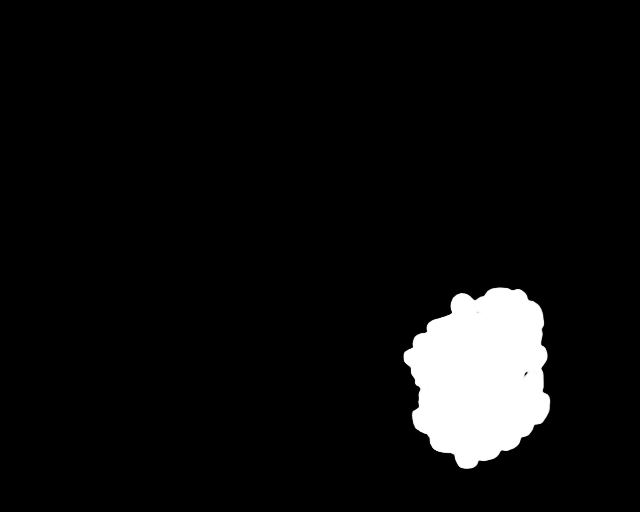

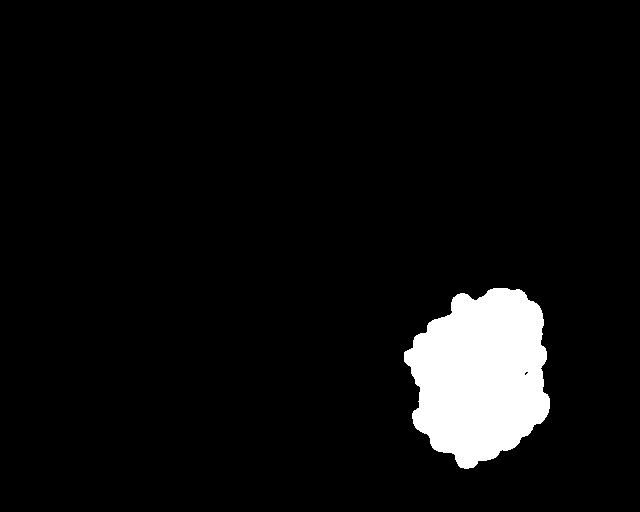

(2, 1, 512, 640)
(1, 512, 640)


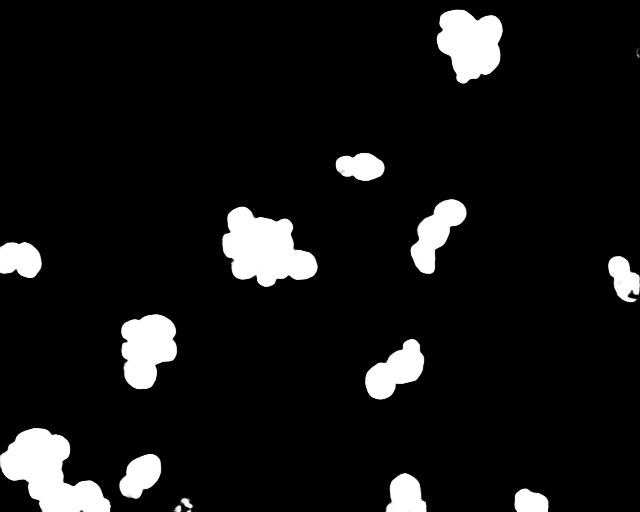

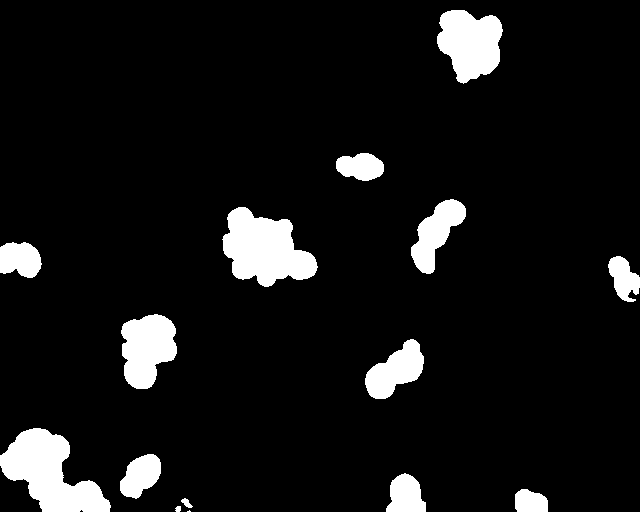

(2, 1, 512, 640)
(1, 512, 640)


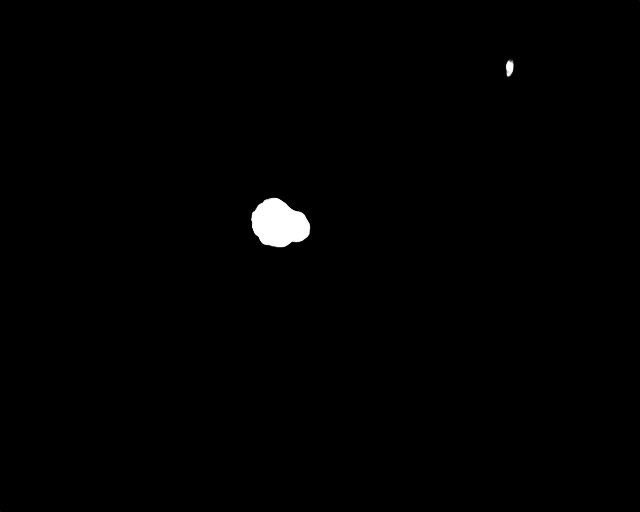

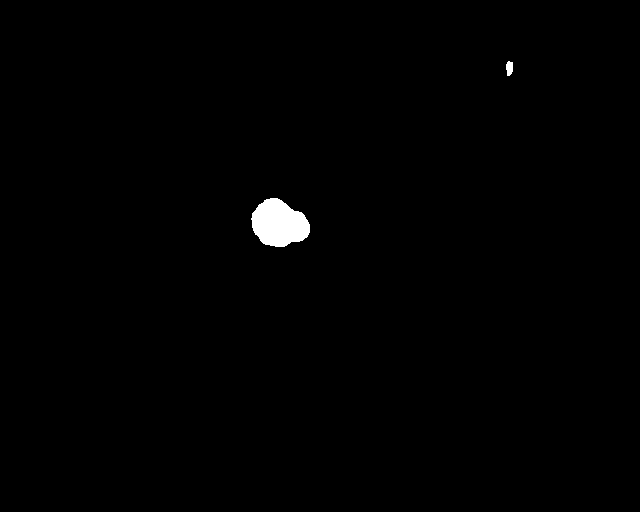

(2, 1, 512, 640)
(1, 512, 640)


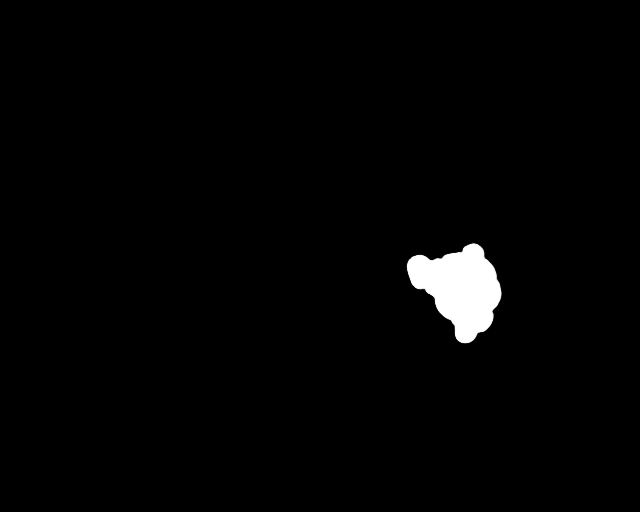

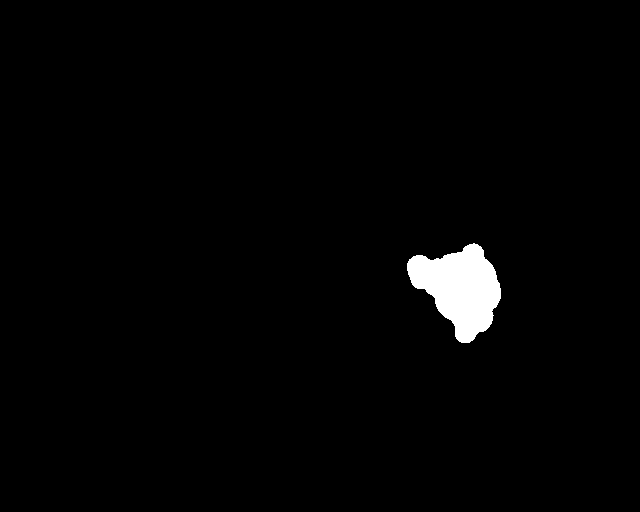

(2, 1, 512, 640)
(1, 512, 640)


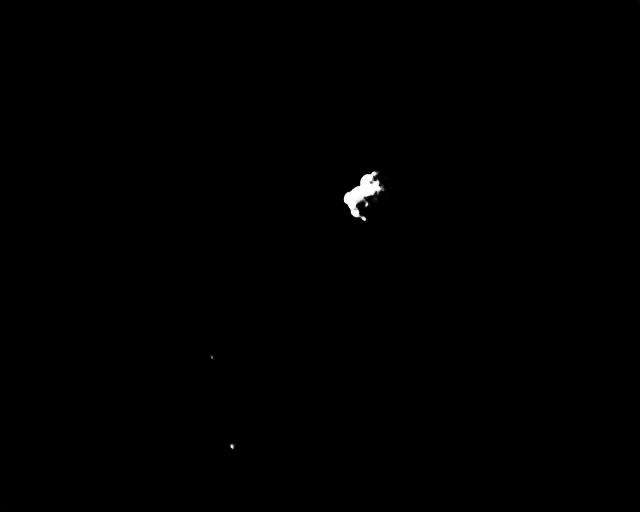

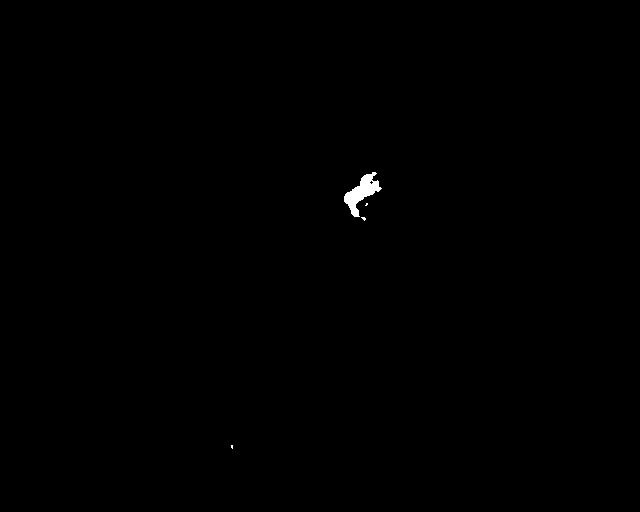

(2, 1, 512, 640)
(1, 512, 640)


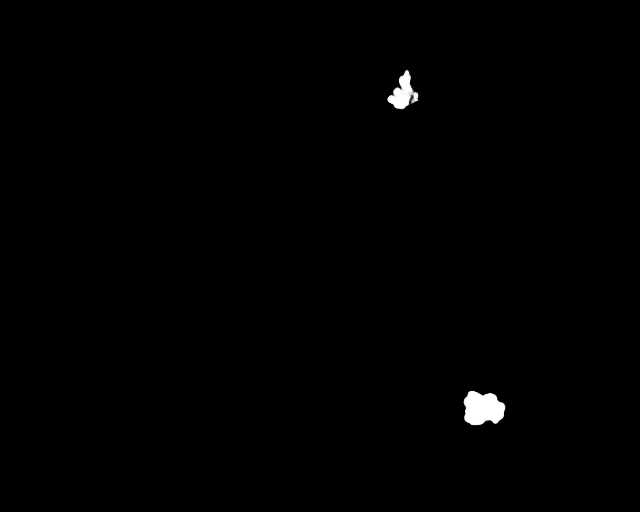

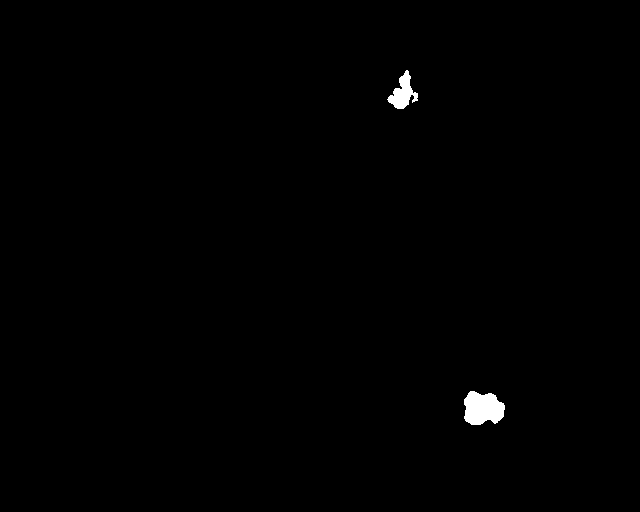

(2, 1, 512, 640)
(1, 512, 640)


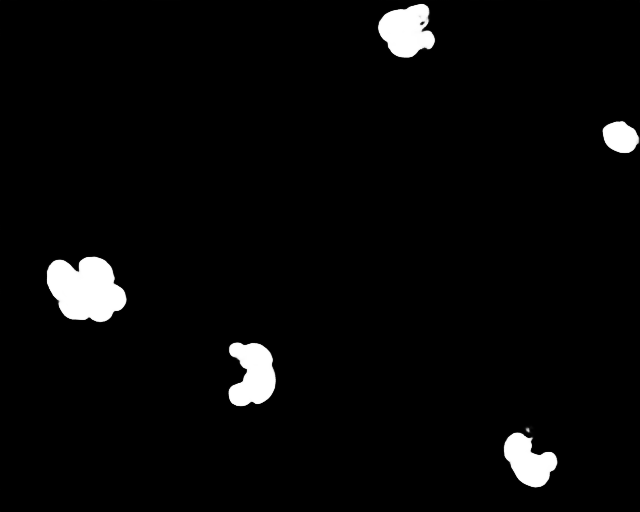

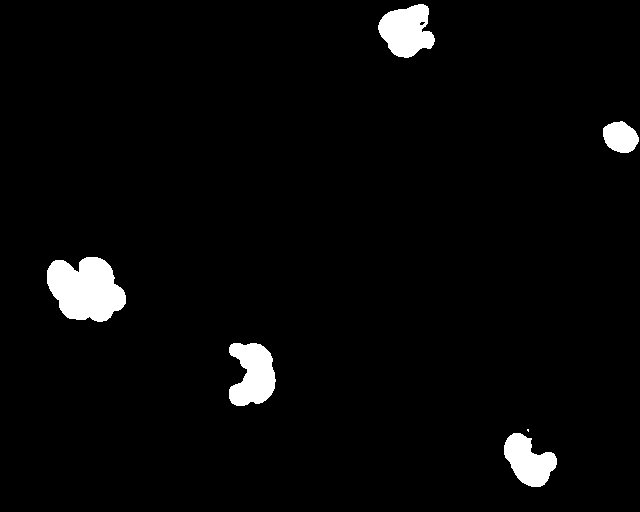

(2, 1, 512, 640)
(1, 512, 640)


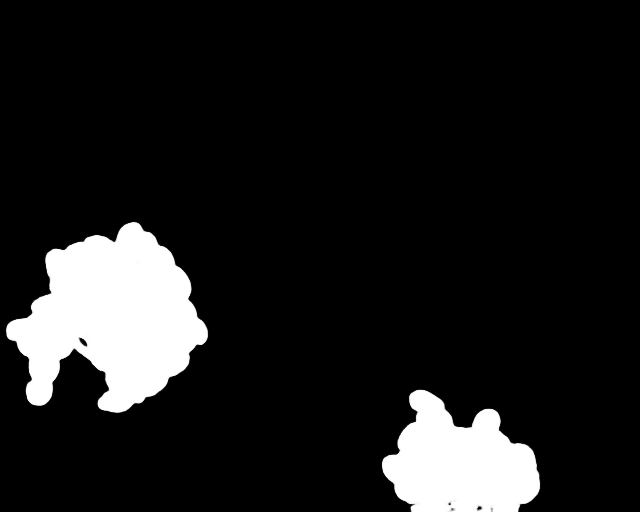

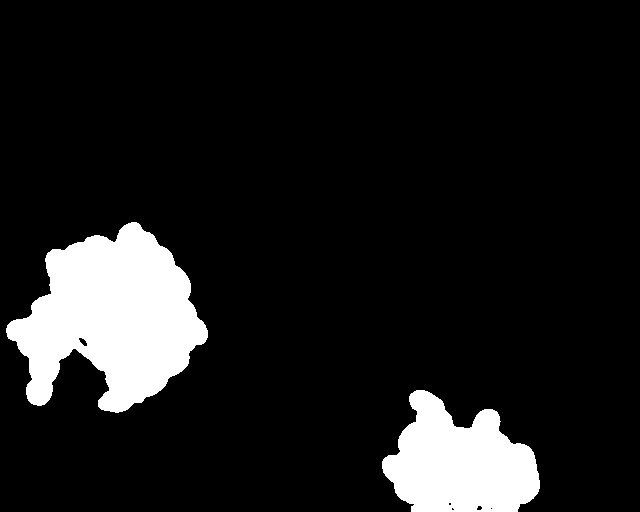

(2, 1, 512, 640)
(1, 512, 640)


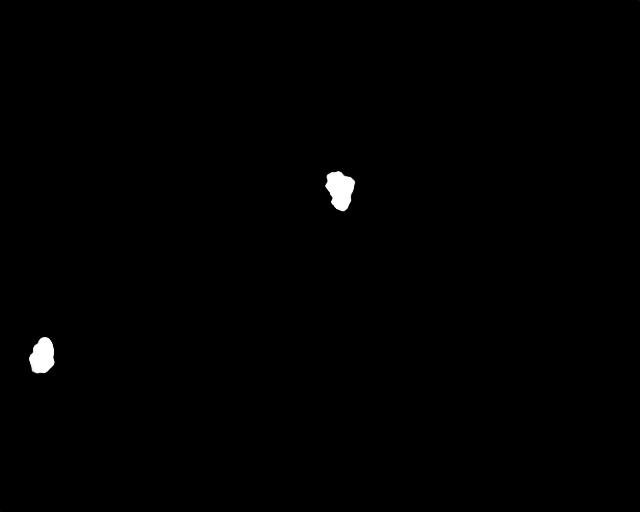

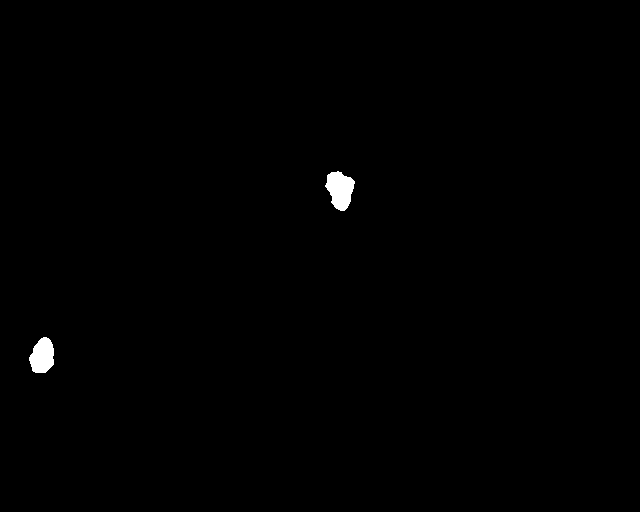

(2, 1, 512, 640)
(1, 512, 640)


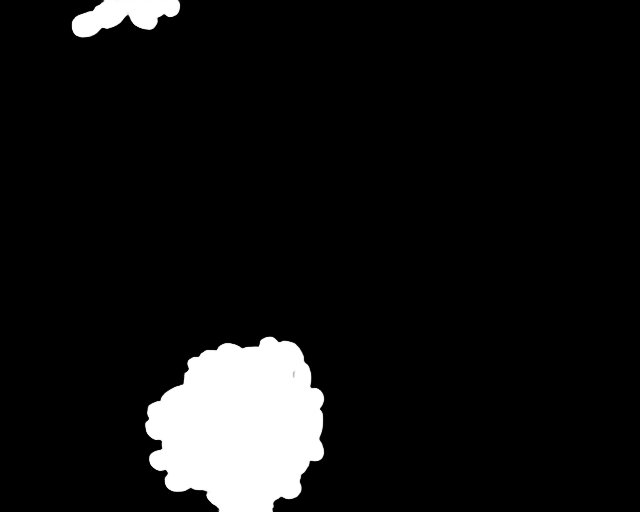

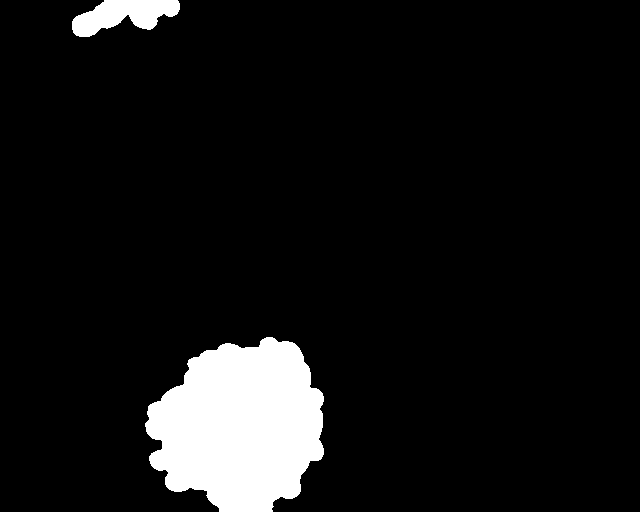

(2, 1, 512, 640)
(1, 512, 640)


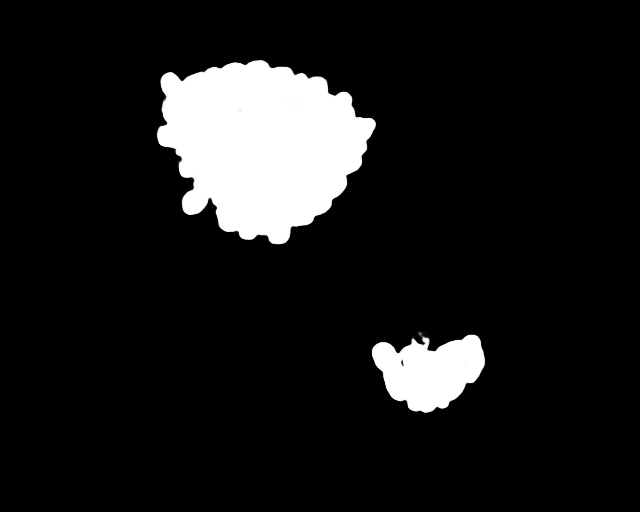

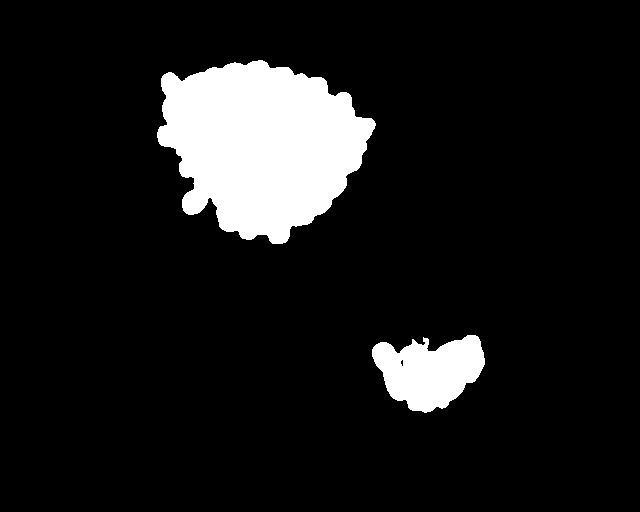

(2, 1, 512, 640)
(1, 512, 640)


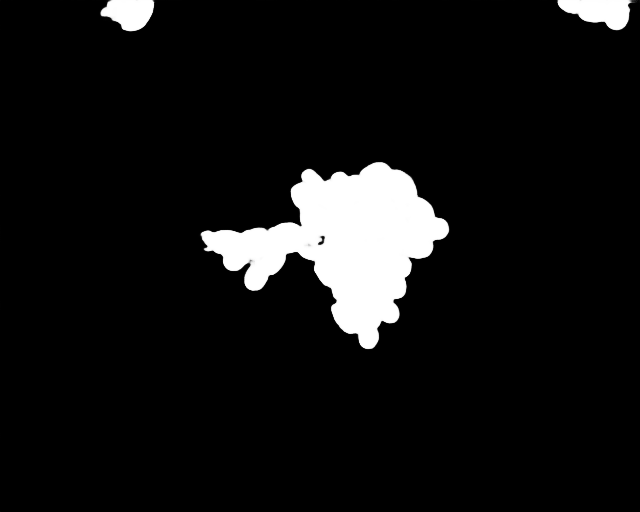

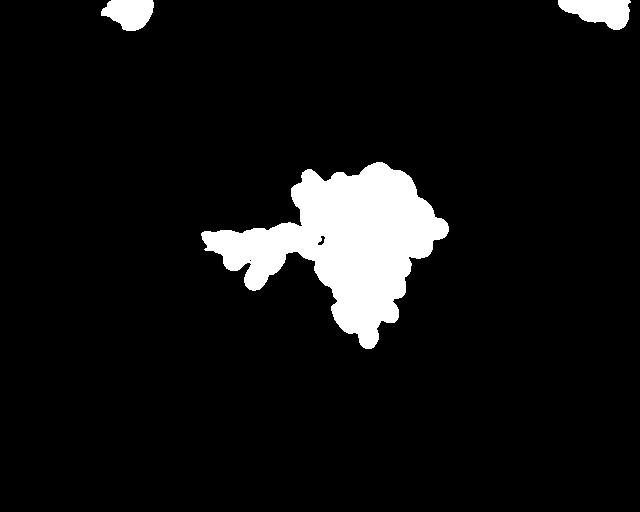

(2, 1, 512, 640)
(1, 512, 640)


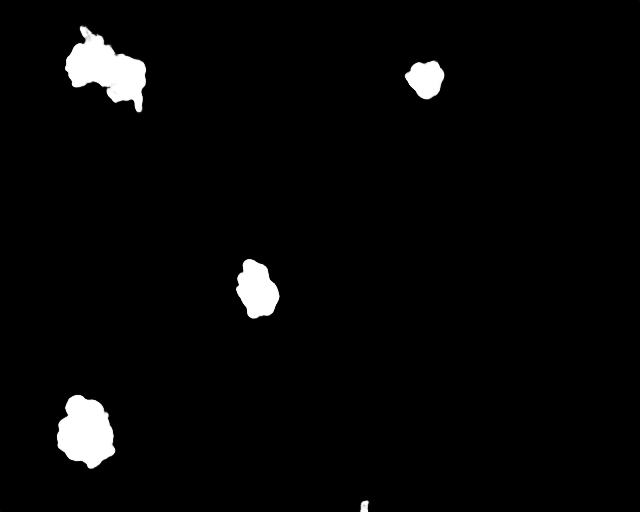

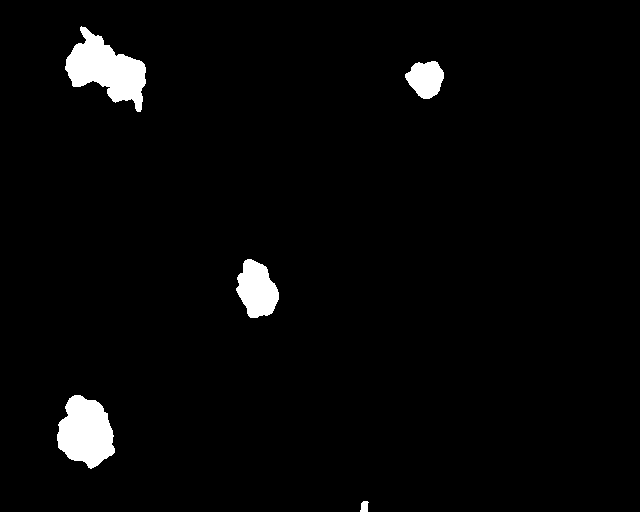

(2, 1, 512, 640)
(1, 512, 640)


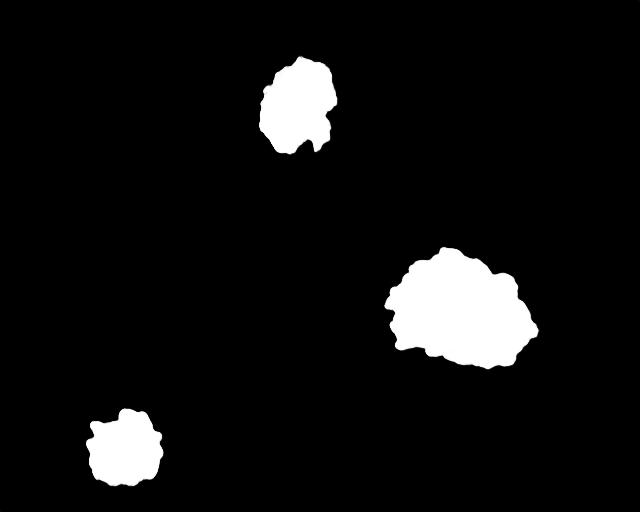

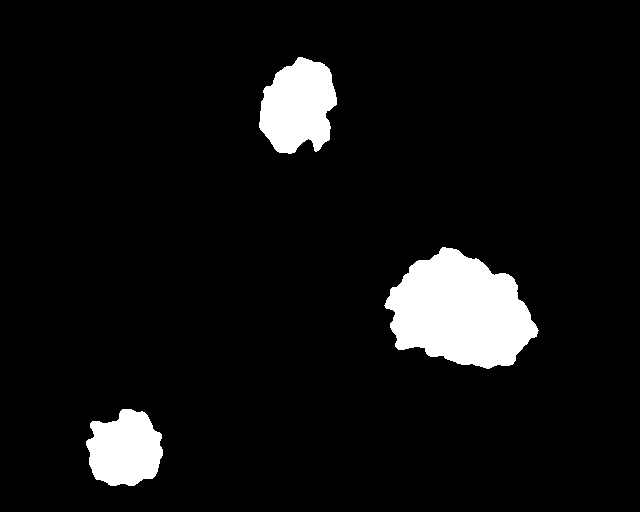

(2, 1, 512, 640)
(1, 512, 640)


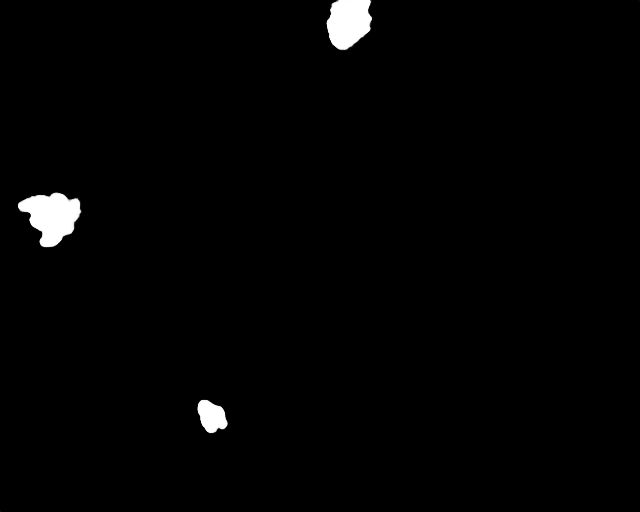

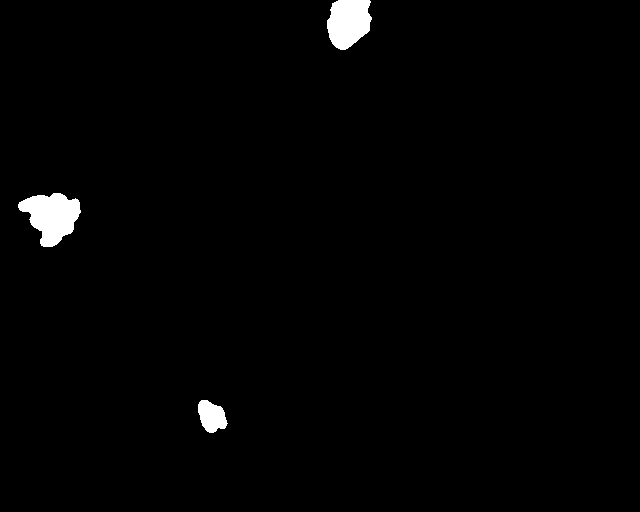

(2, 1, 512, 640)
(1, 512, 640)


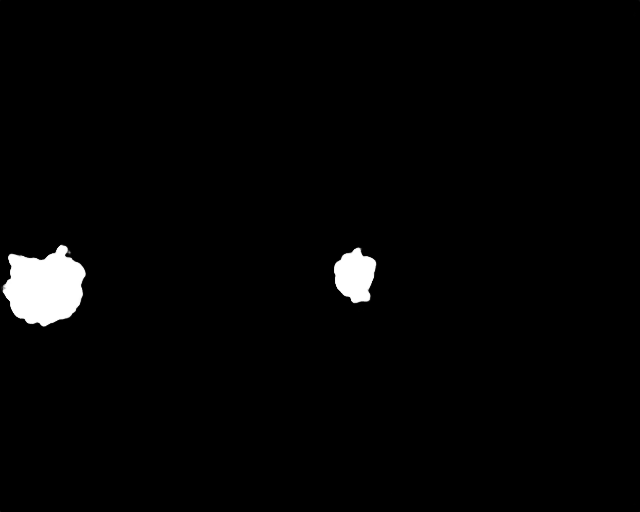

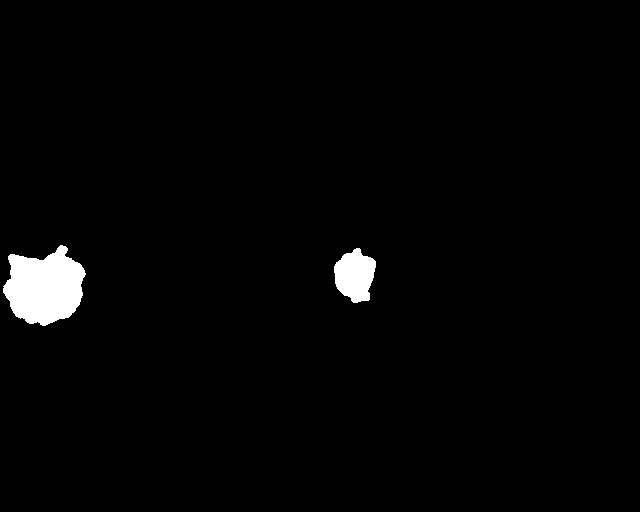

(2, 1, 512, 640)
(1, 512, 640)


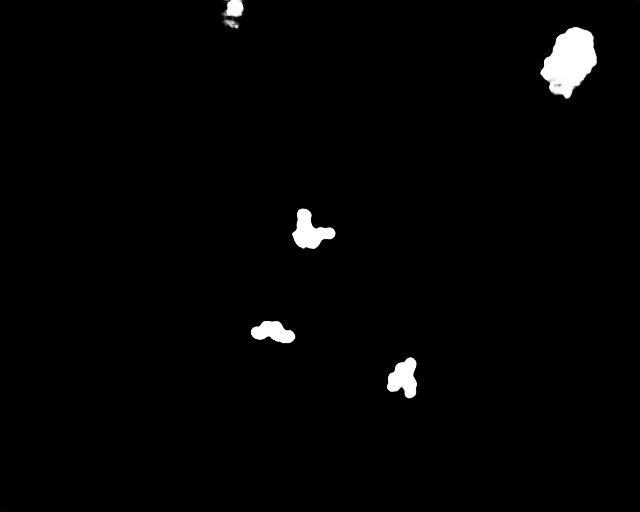

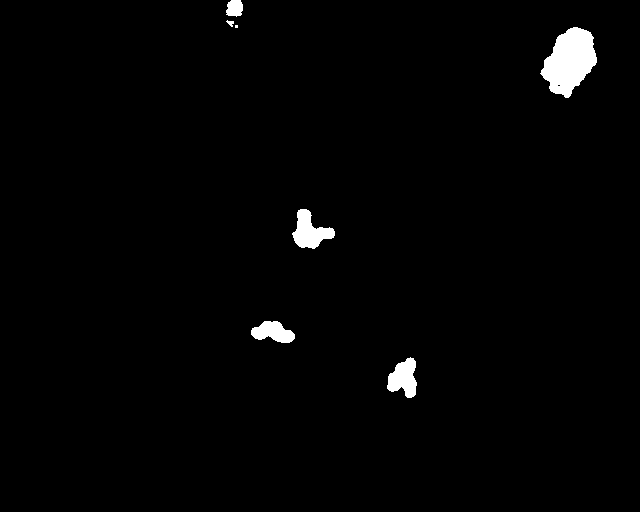

(2, 1, 512, 640)
(1, 512, 640)


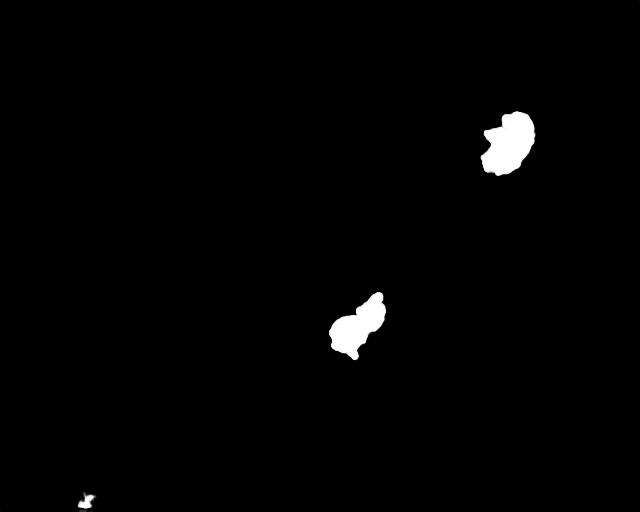

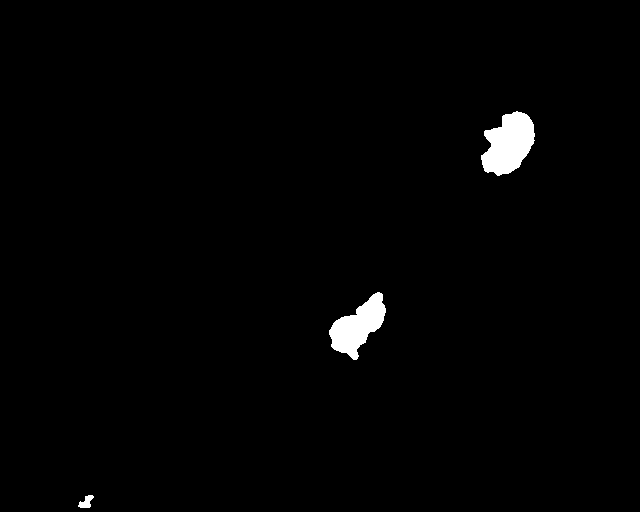

(2, 1, 512, 640)
(1, 512, 640)


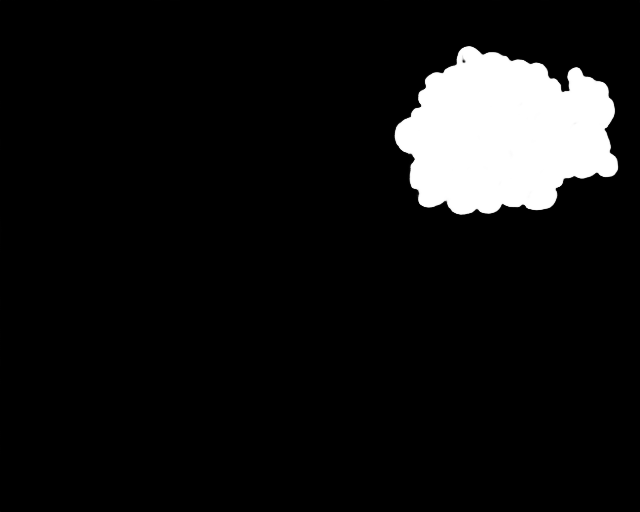

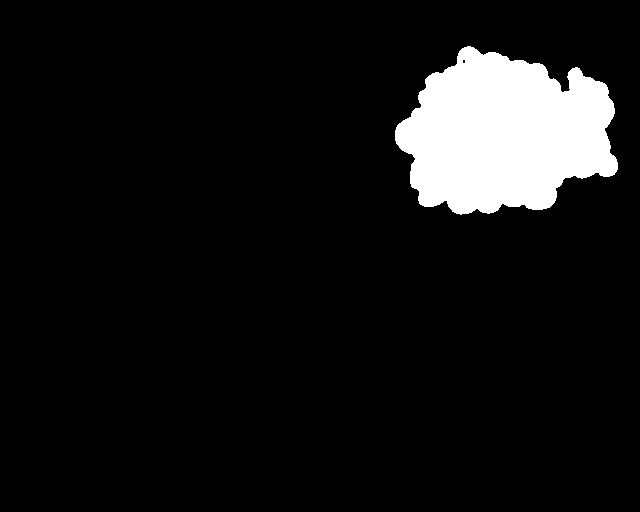

(2, 1, 512, 640)
(1, 512, 640)


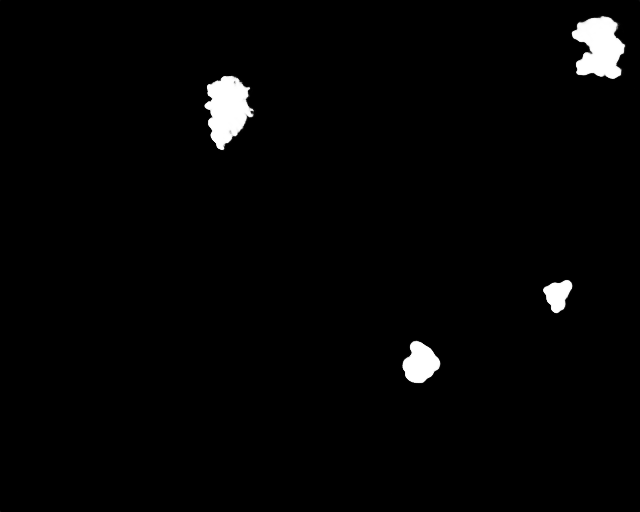

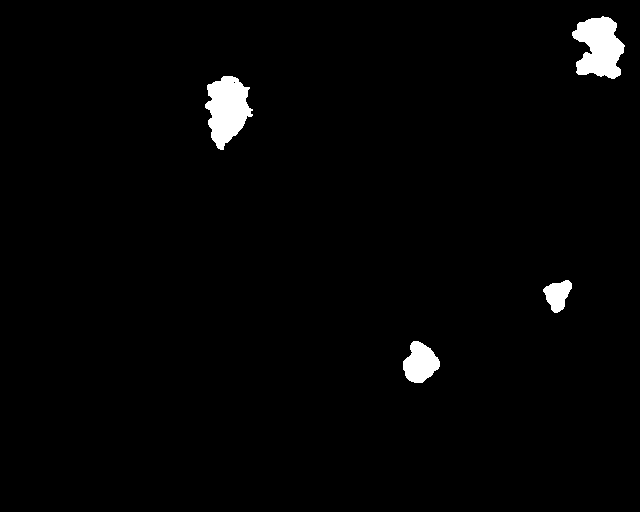

(2, 1, 512, 640)
(1, 512, 640)


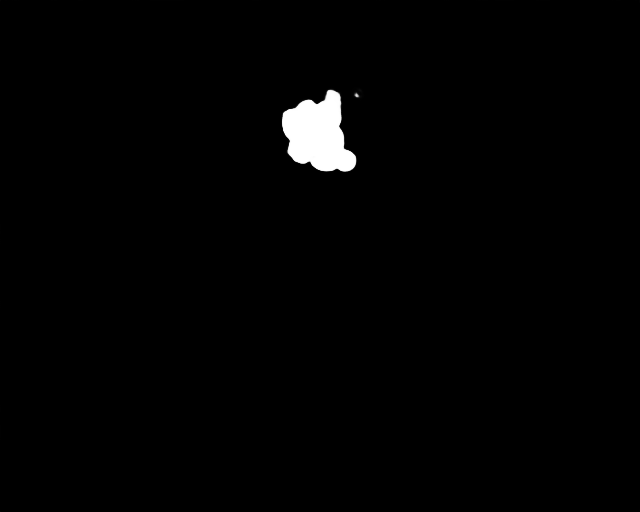

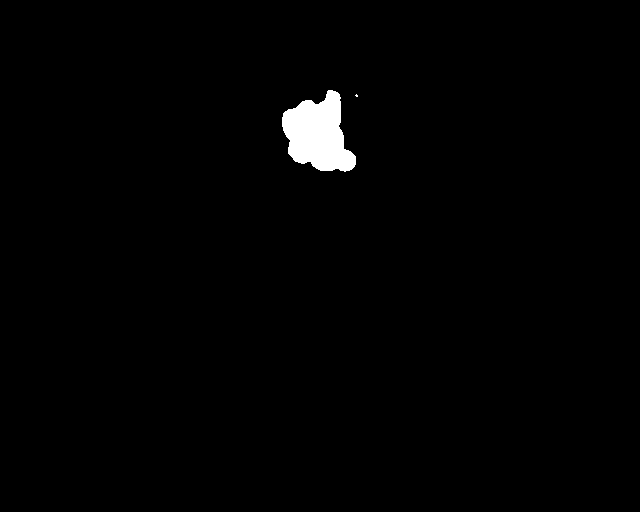

(2, 1, 512, 640)
(1, 512, 640)


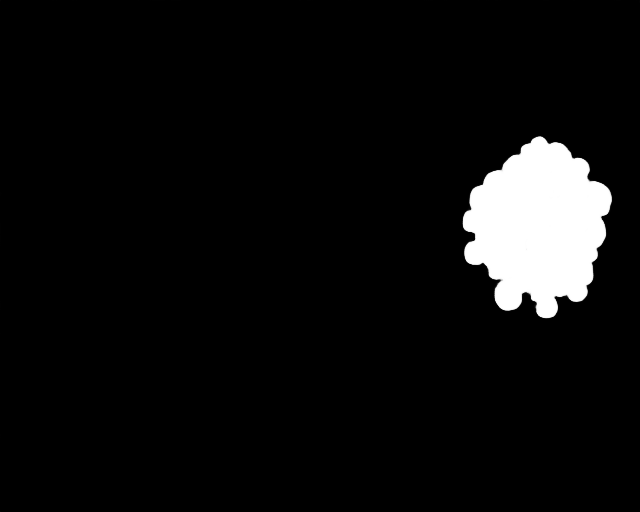

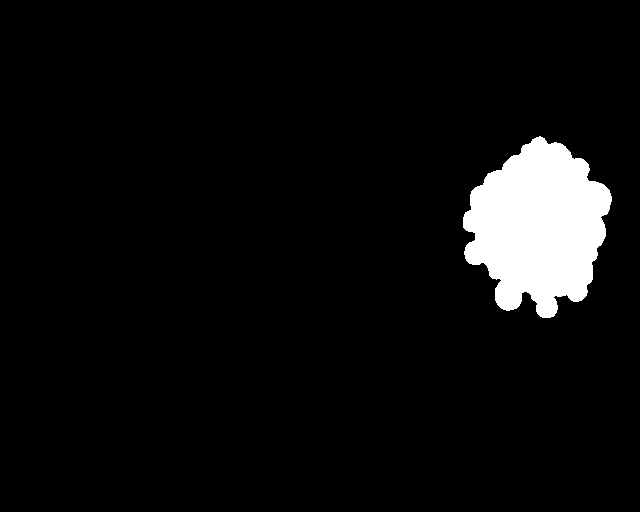

(2, 1, 512, 640)
(1, 512, 640)


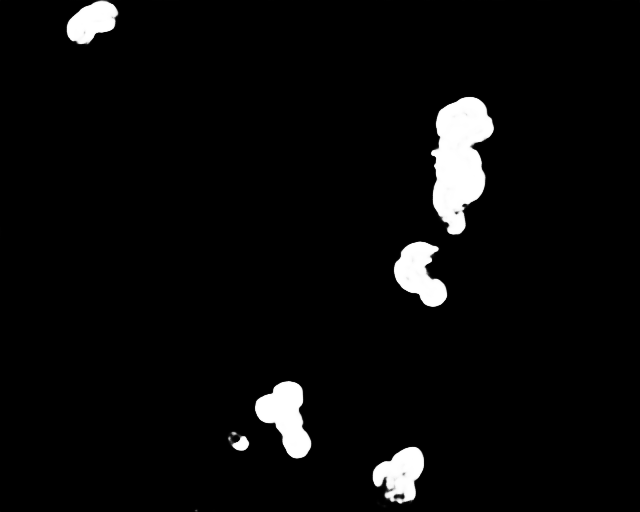

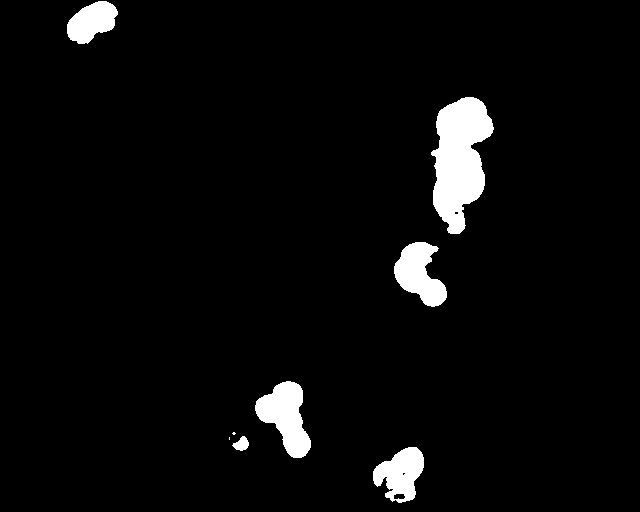

(2, 1, 512, 640)
(1, 512, 640)


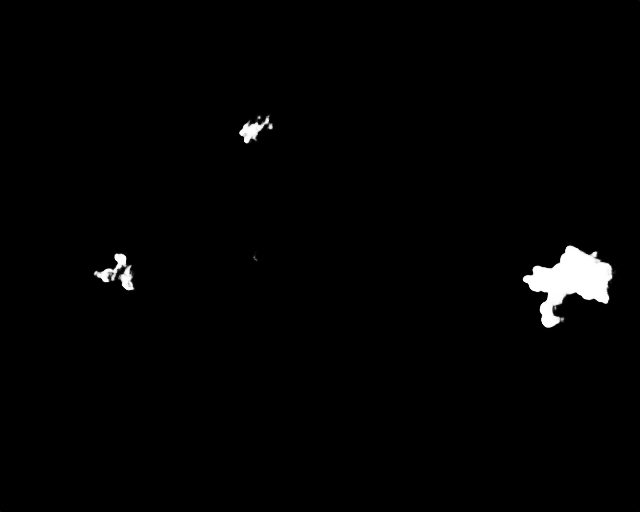

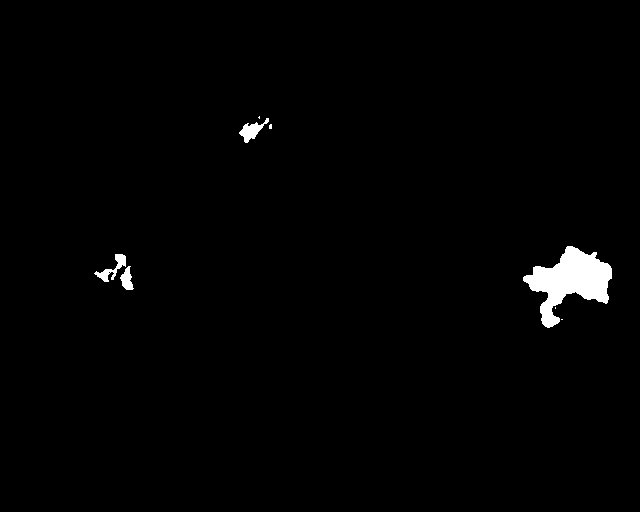

(2, 1, 512, 640)
(1, 512, 640)


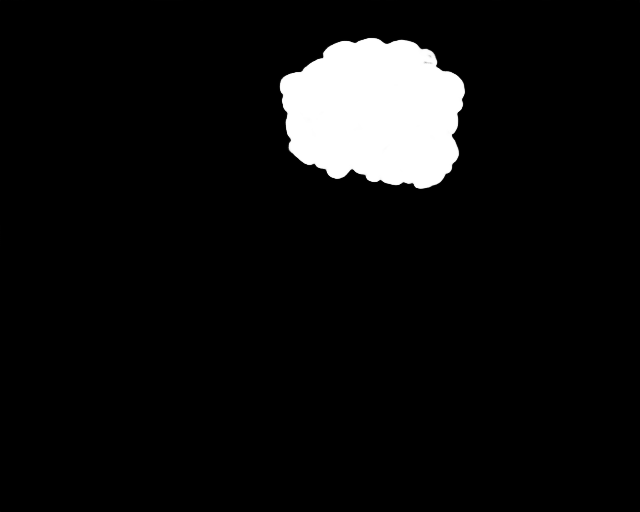

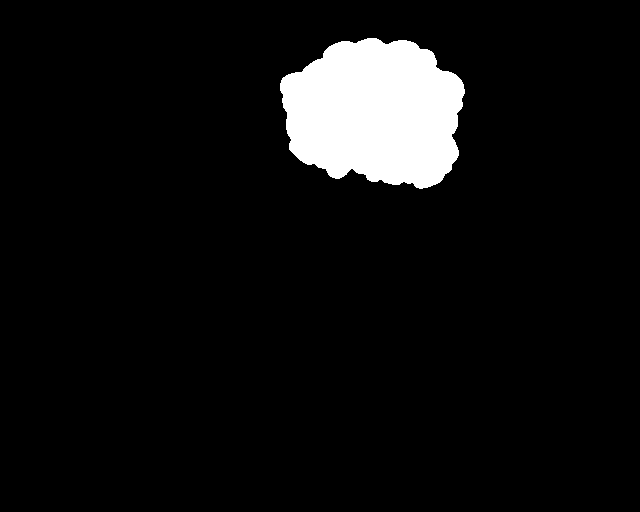

(2, 1, 512, 640)
(1, 512, 640)


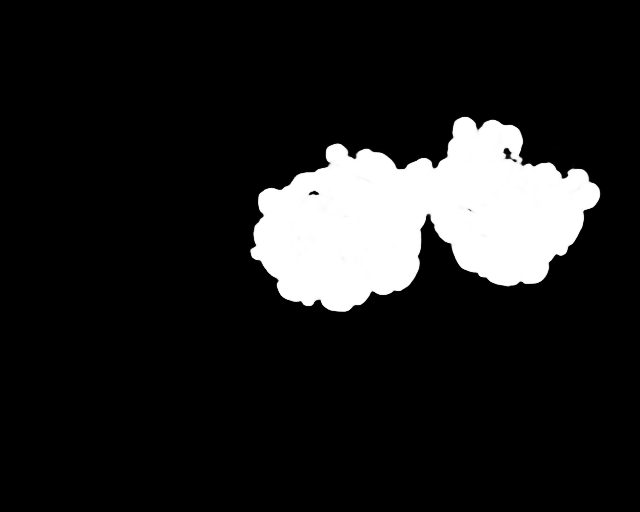

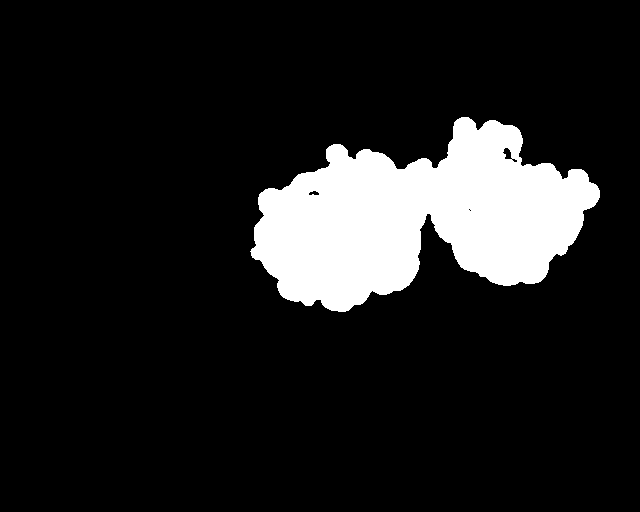

(2, 1, 512, 640)
(1, 512, 640)


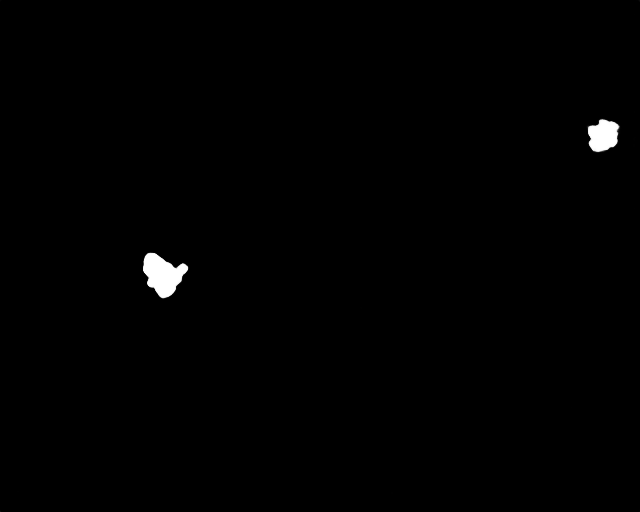

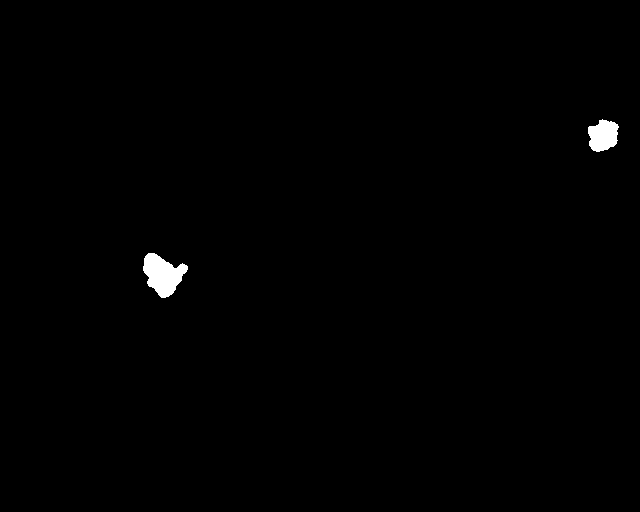

(2, 1, 512, 640)
(1, 512, 640)


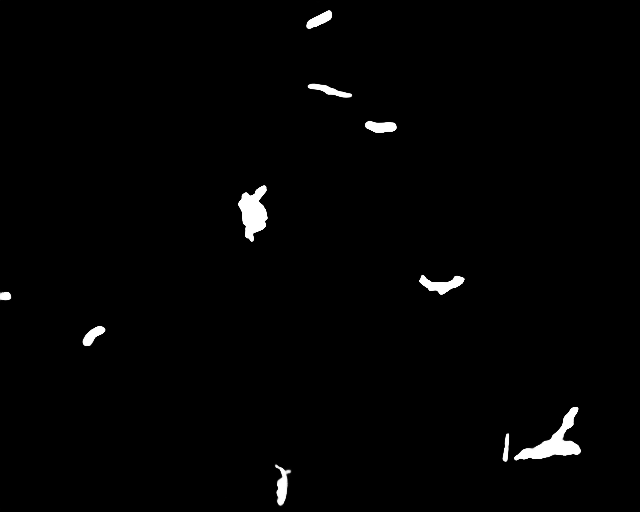

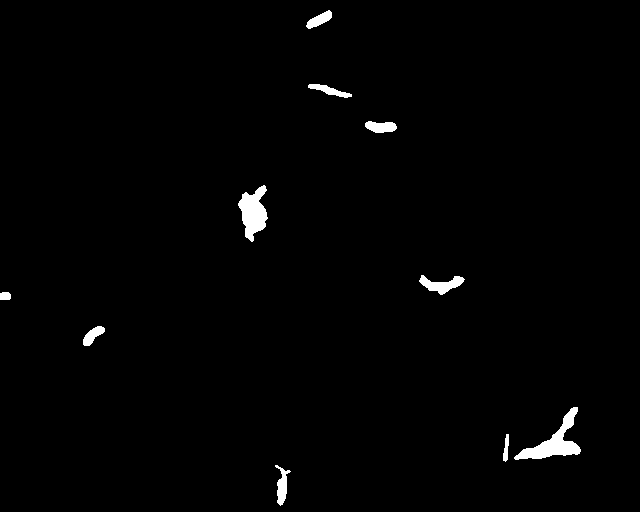

(2, 1, 512, 640)
(1, 512, 640)


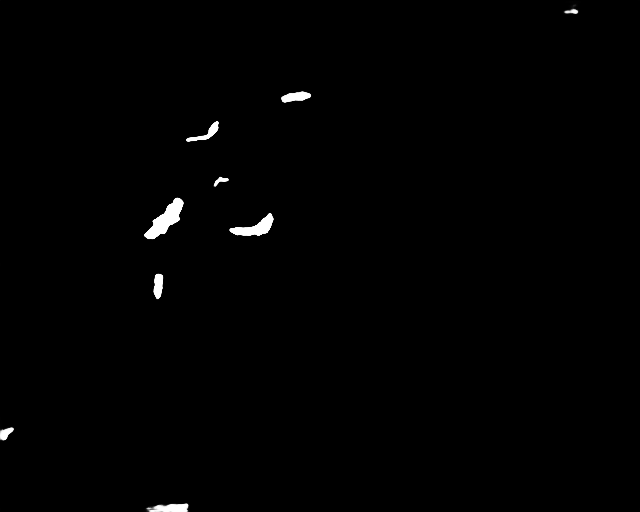

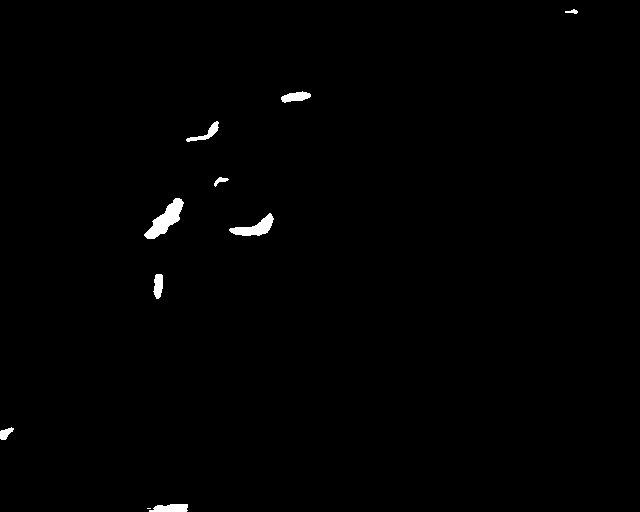

(2, 1, 512, 640)
(1, 512, 640)


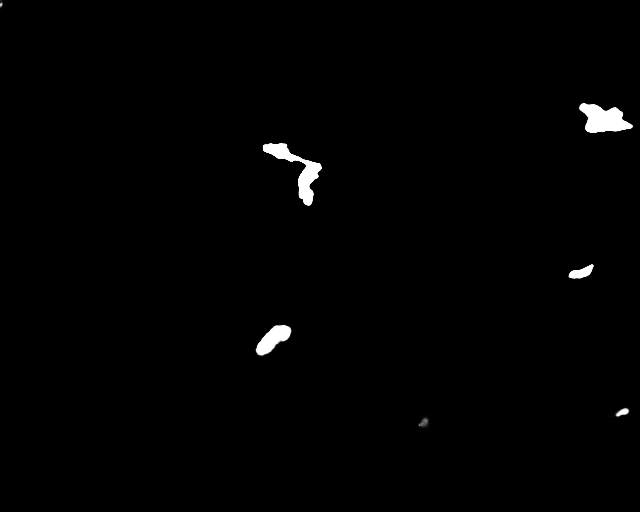

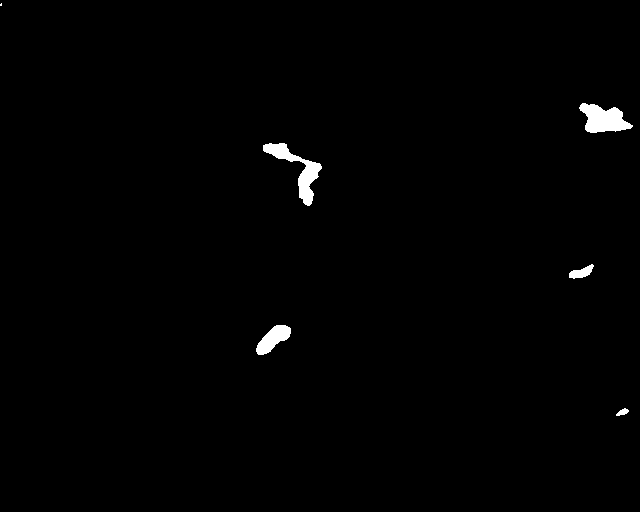

(2, 1, 512, 640)
(1, 512, 640)


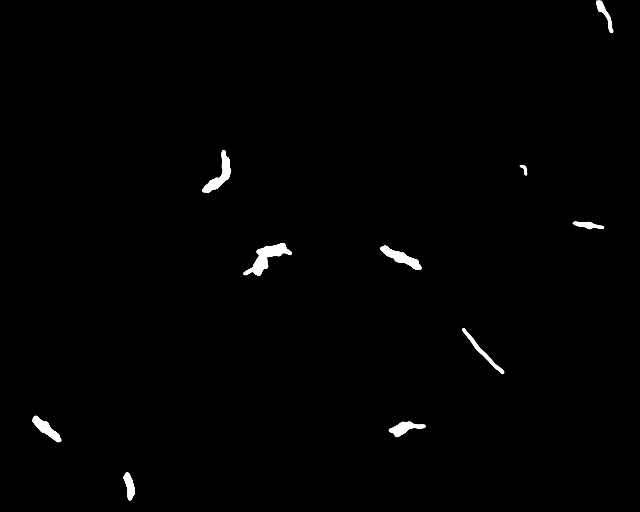

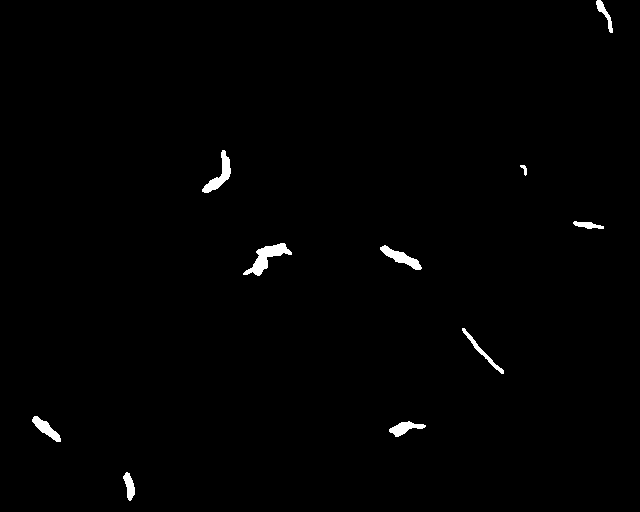

(2, 1, 512, 640)
(1, 512, 640)


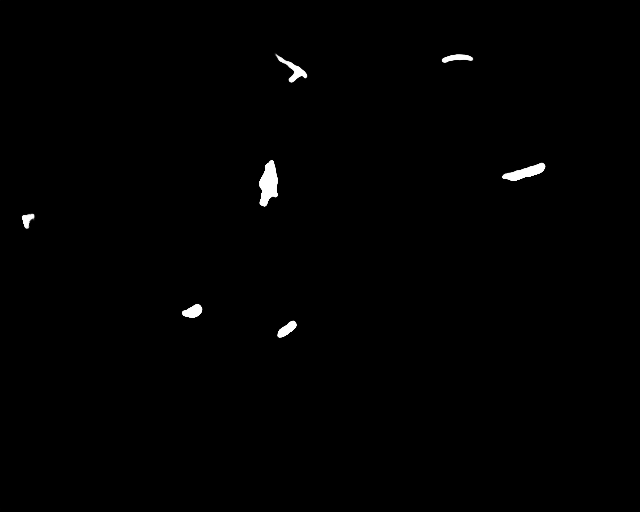

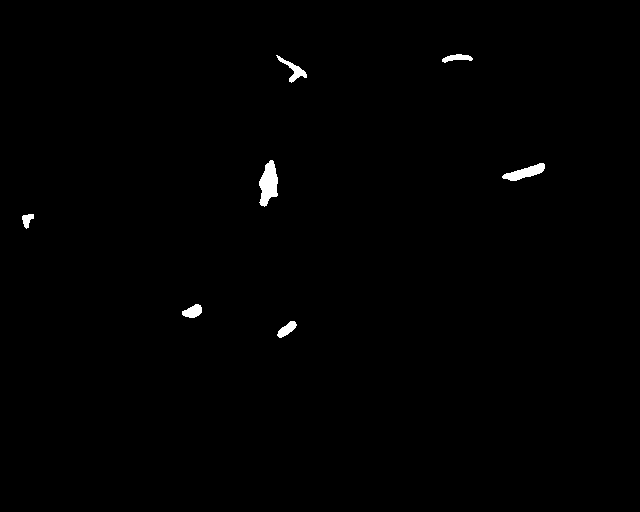

(2, 1, 512, 640)
(1, 512, 640)


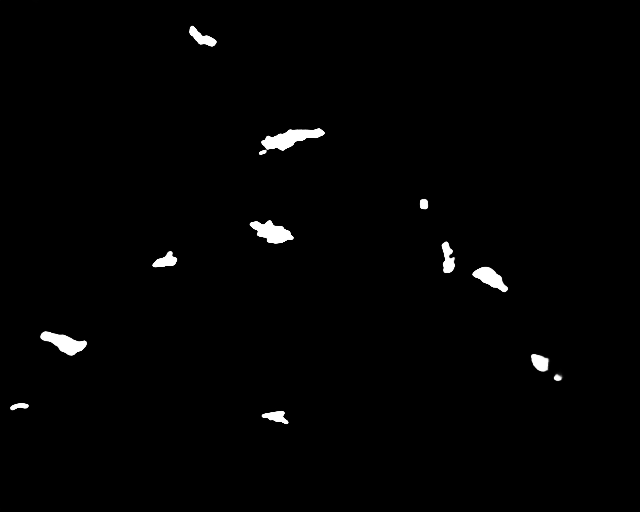

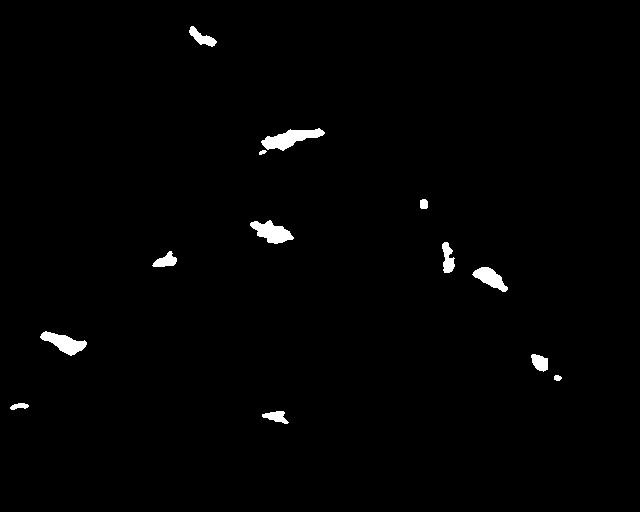

(2, 1, 512, 640)
(1, 512, 640)


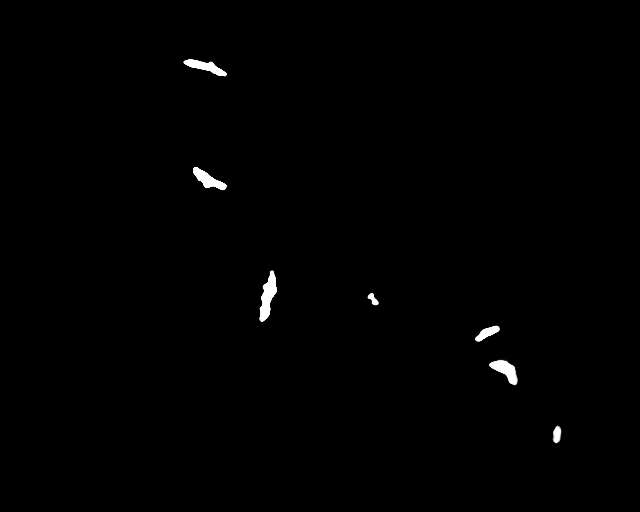

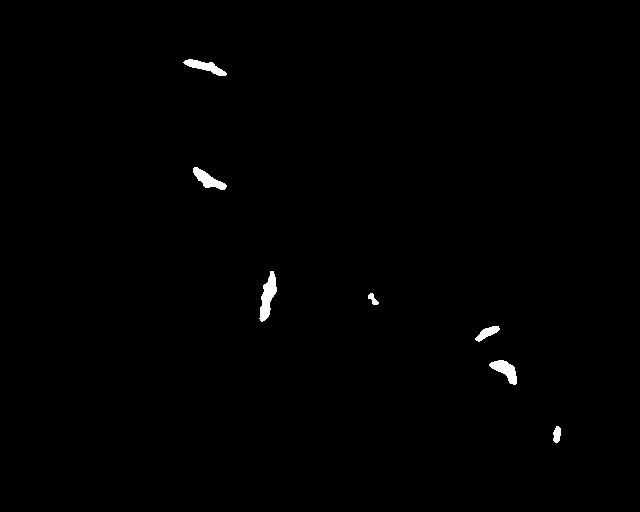

(2, 1, 512, 640)
(1, 512, 640)


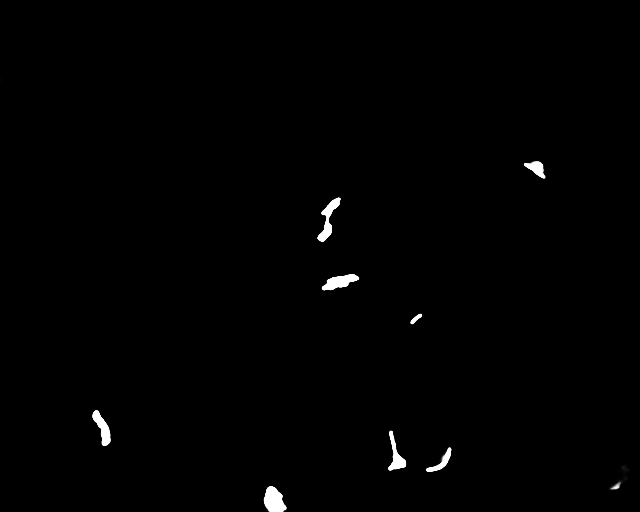

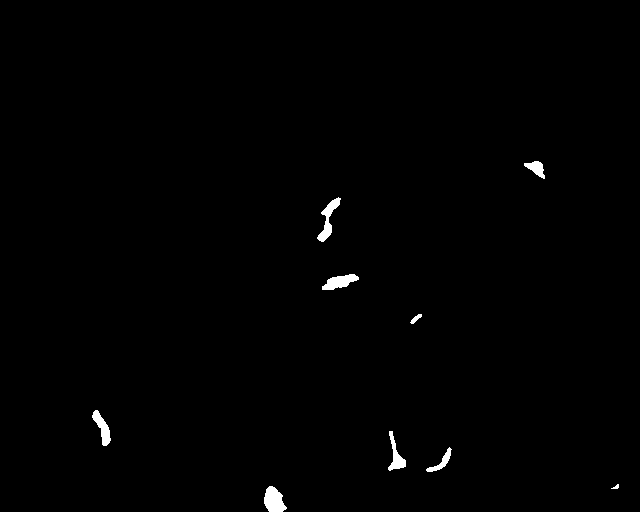

(2, 1, 512, 640)
(1, 512, 640)


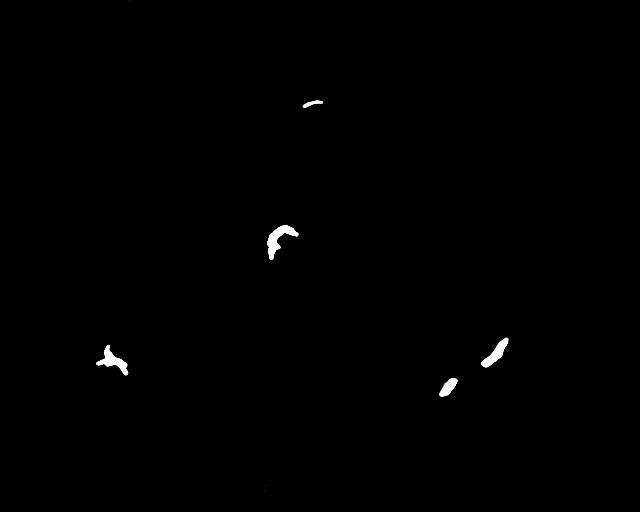

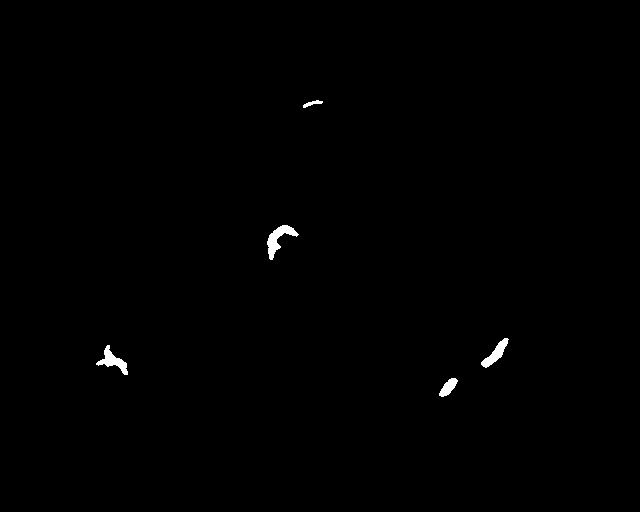

(2, 1, 512, 640)
(1, 512, 640)


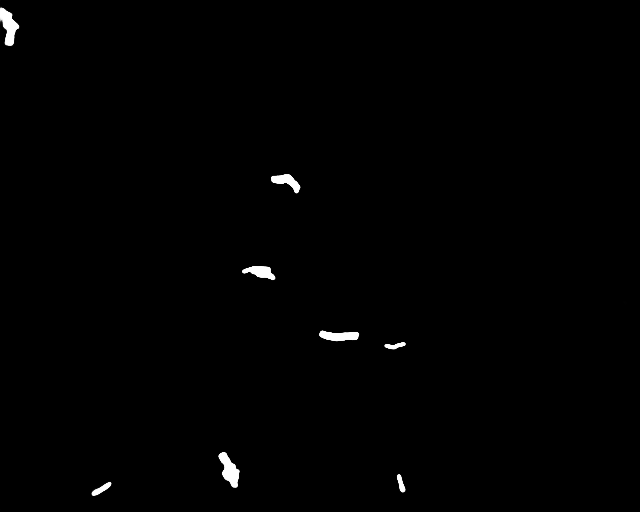

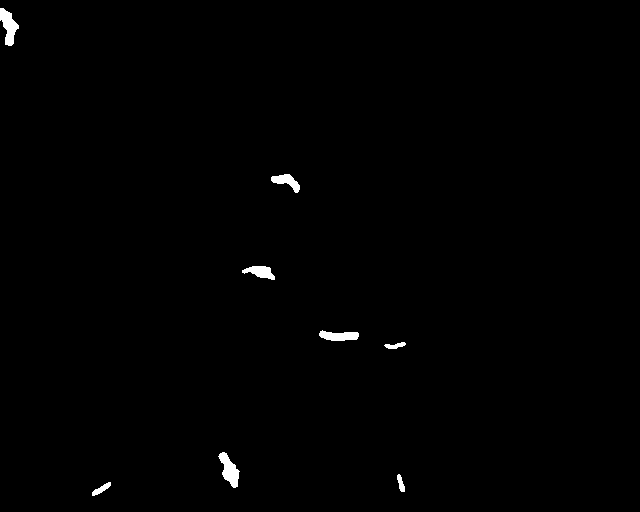

(2, 1, 512, 640)
(1, 512, 640)


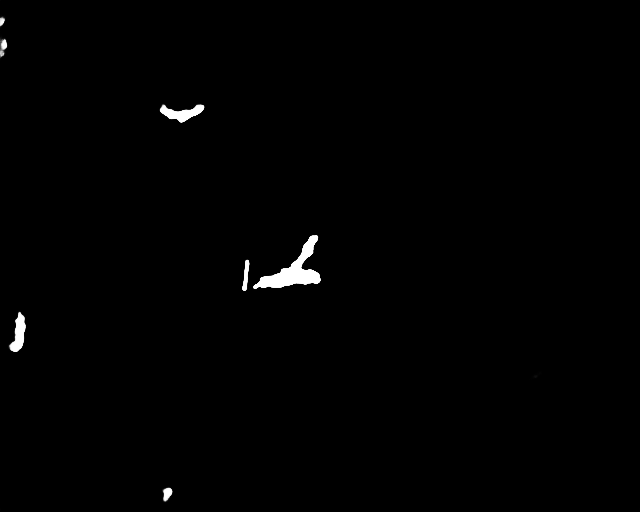

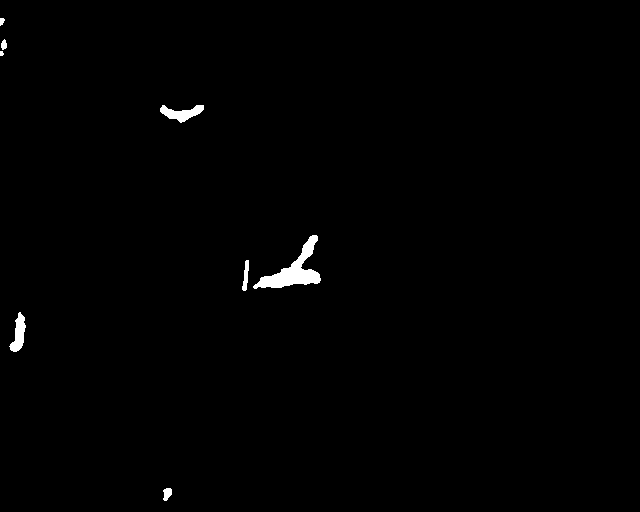

(2, 1, 512, 640)
(1, 512, 640)


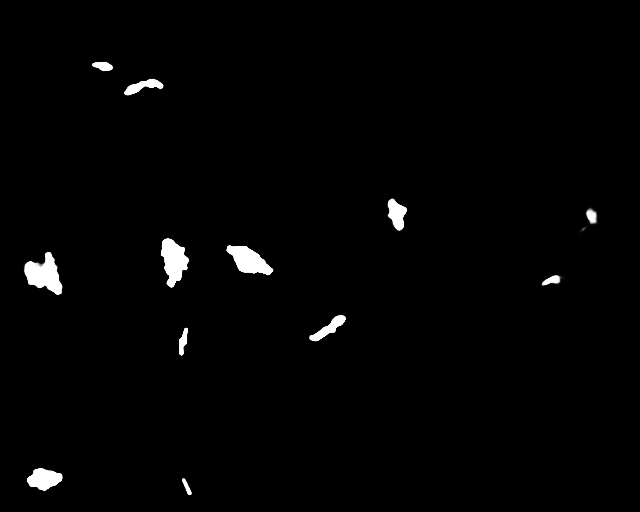

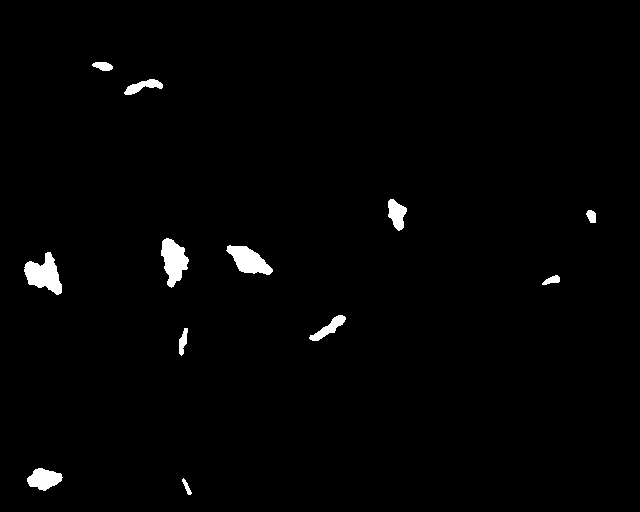

(2, 1, 512, 640)
(1, 512, 640)


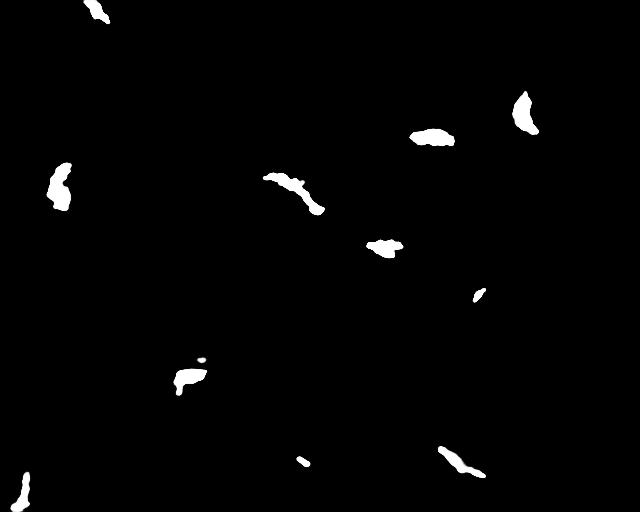

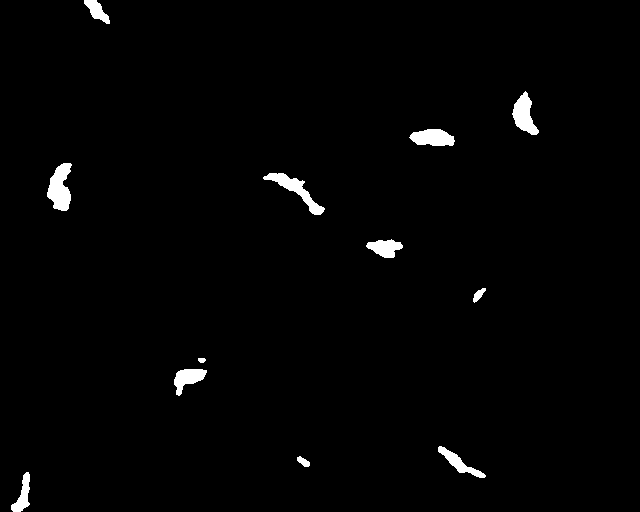

(2, 1, 512, 640)
(1, 512, 640)


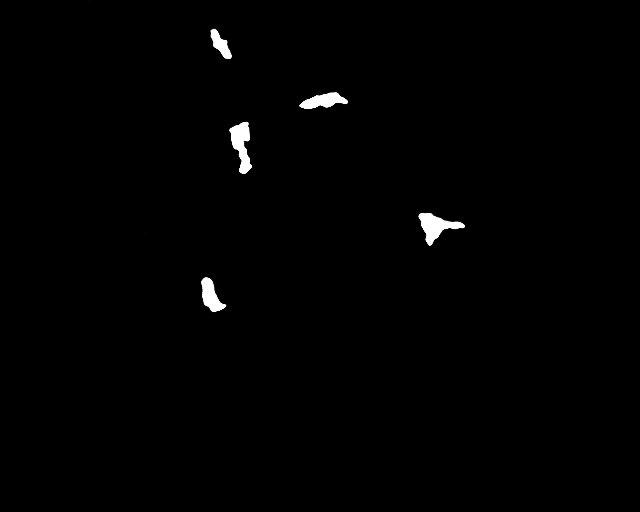

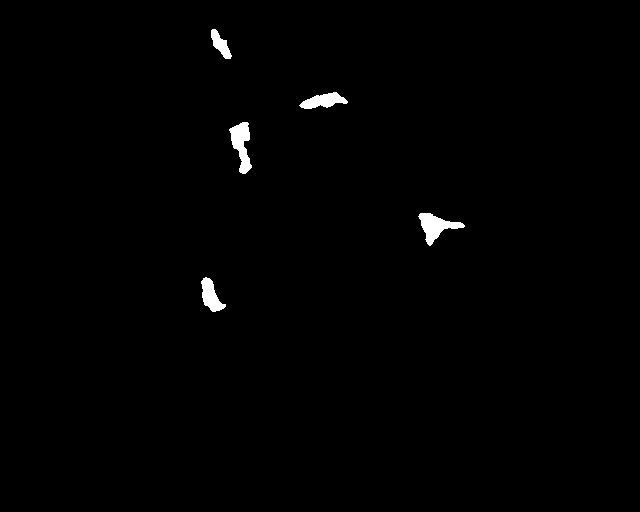

(2, 1, 512, 640)
(1, 512, 640)


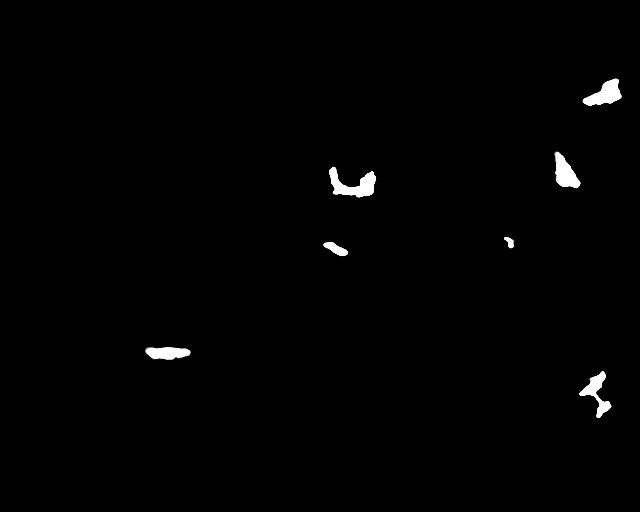

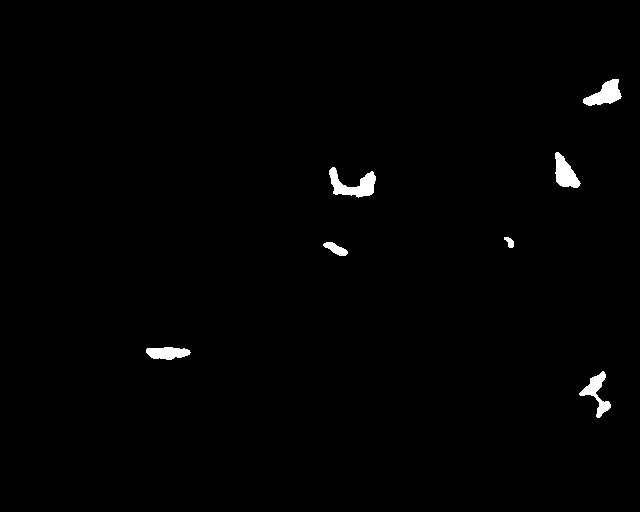

(2, 1, 512, 640)
(1, 512, 640)


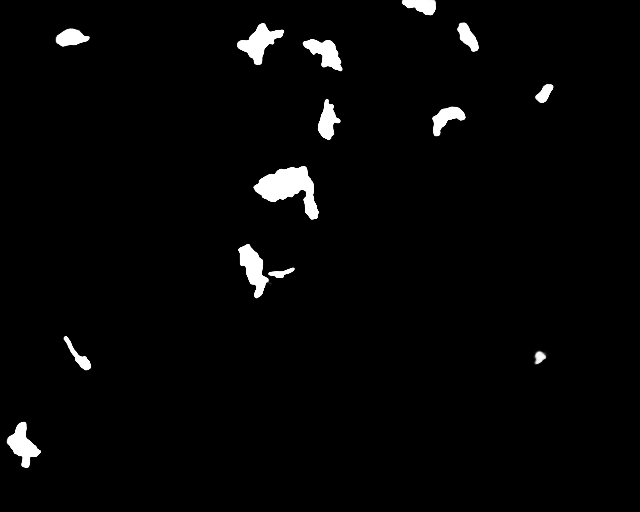

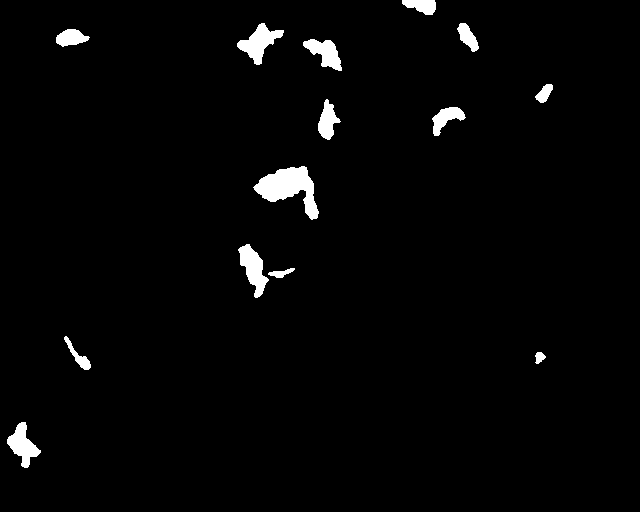

(2, 1, 512, 640)
(1, 512, 640)


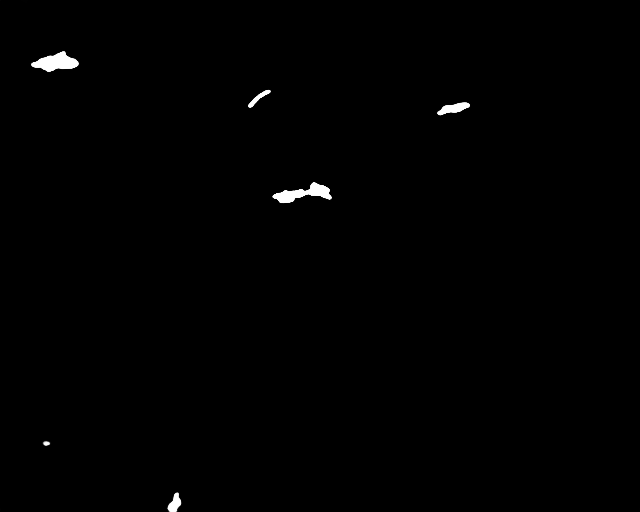

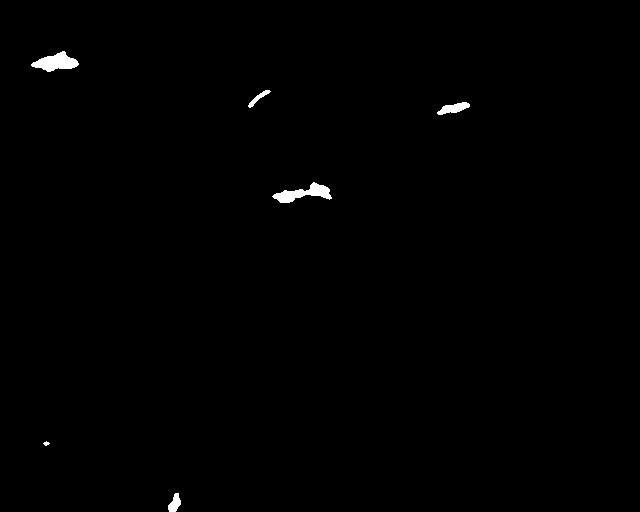

(2, 1, 512, 640)
(1, 512, 640)


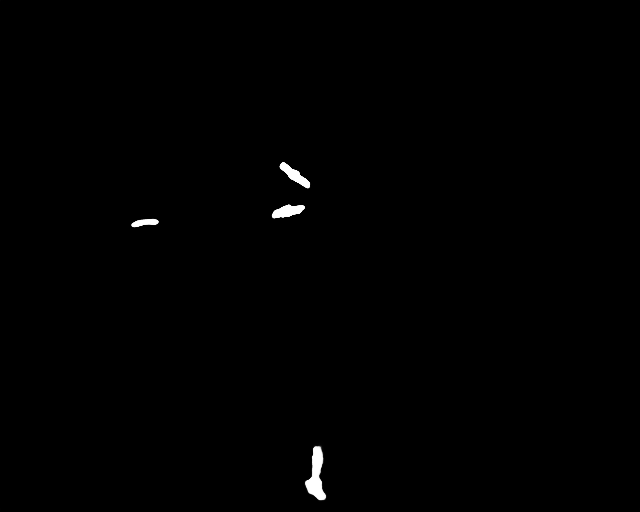

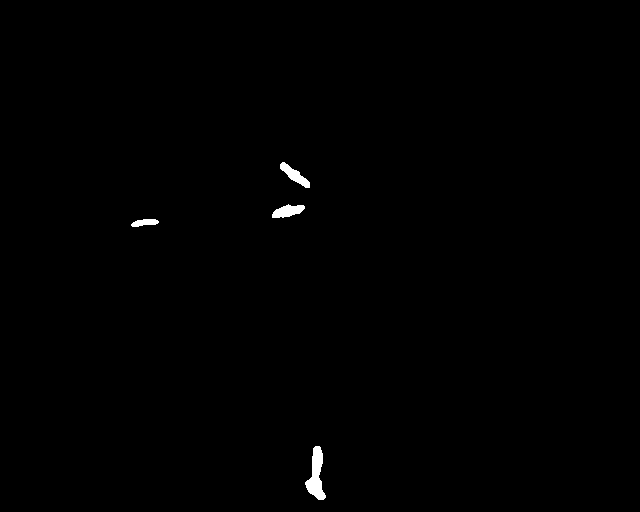

(2, 1, 512, 640)
(1, 512, 640)


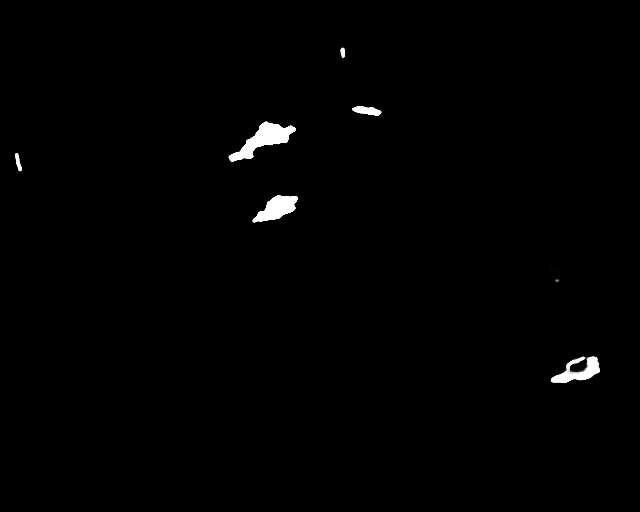

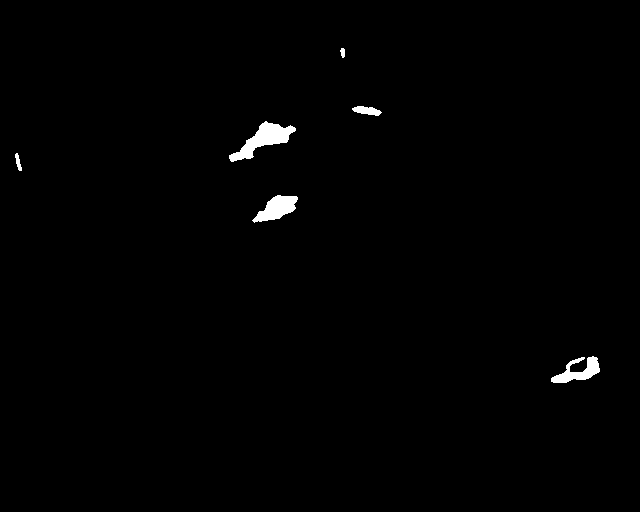

(2, 1, 512, 640)
(1, 512, 640)


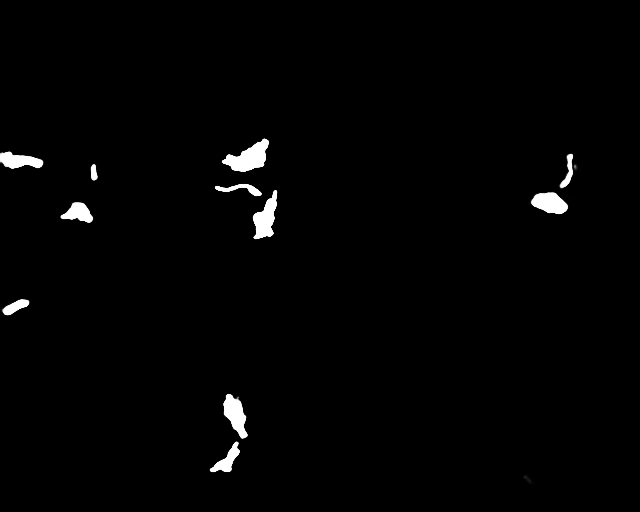

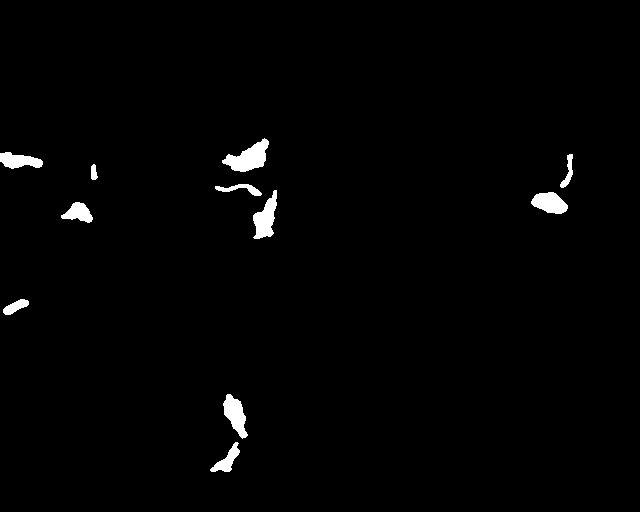

(2, 1, 512, 640)
(1, 512, 640)


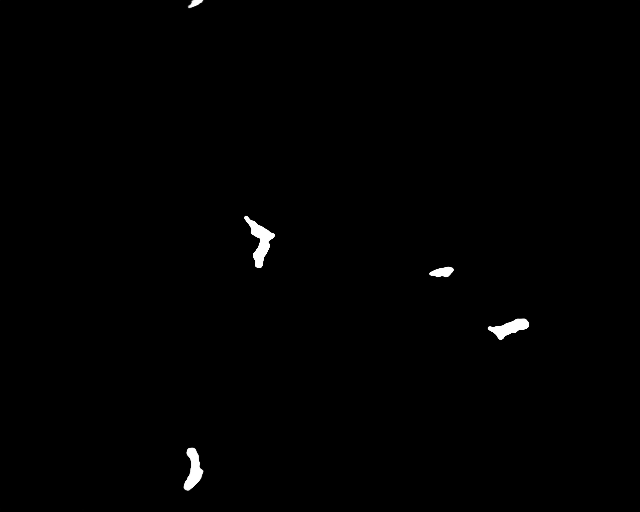

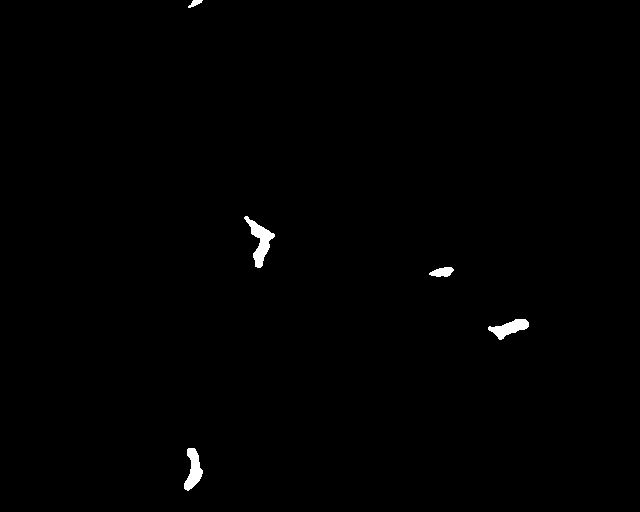

(2, 1, 512, 640)
(1, 512, 640)


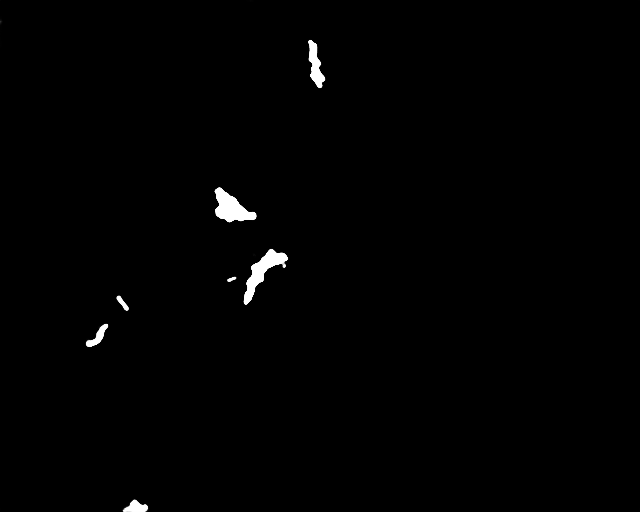

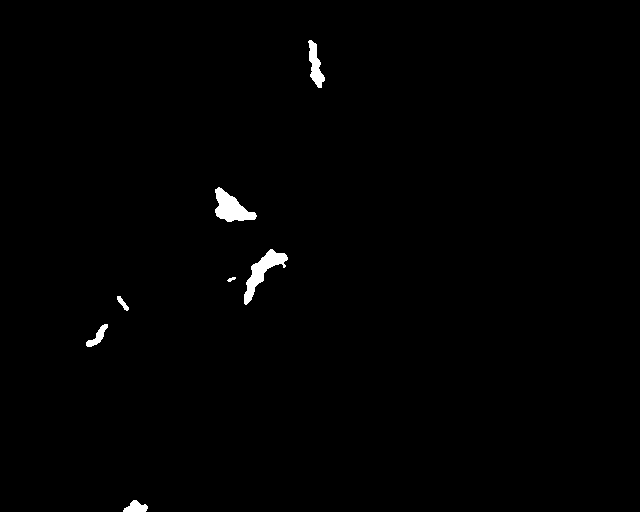

(2, 1, 512, 640)
(1, 512, 640)


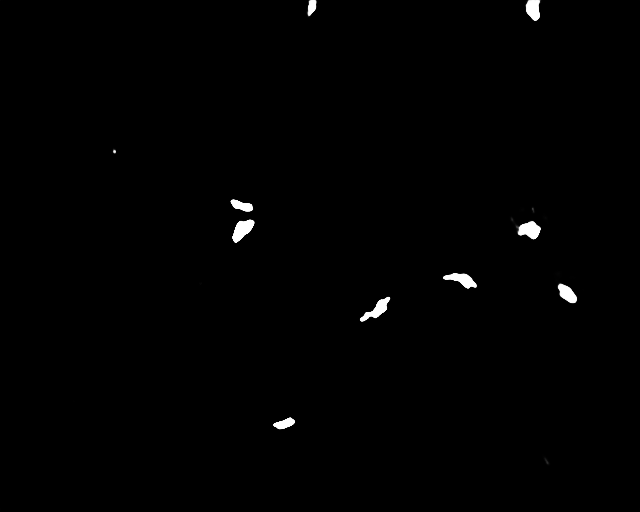

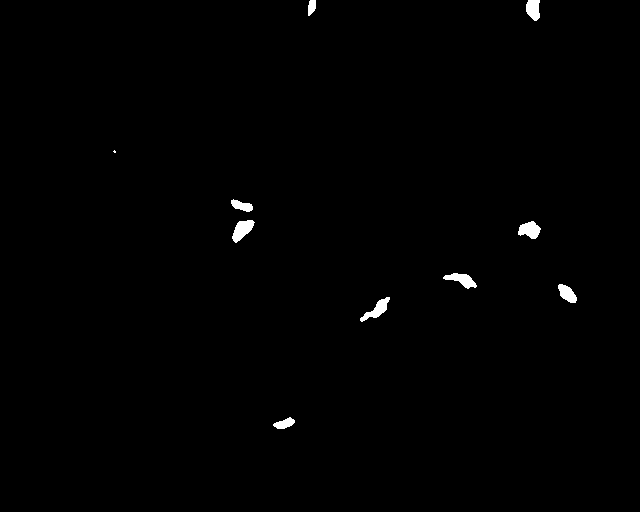

(2, 1, 512, 640)
(1, 512, 640)


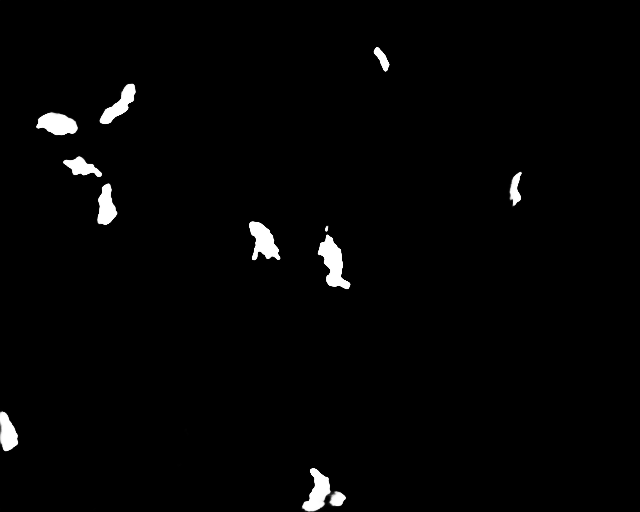

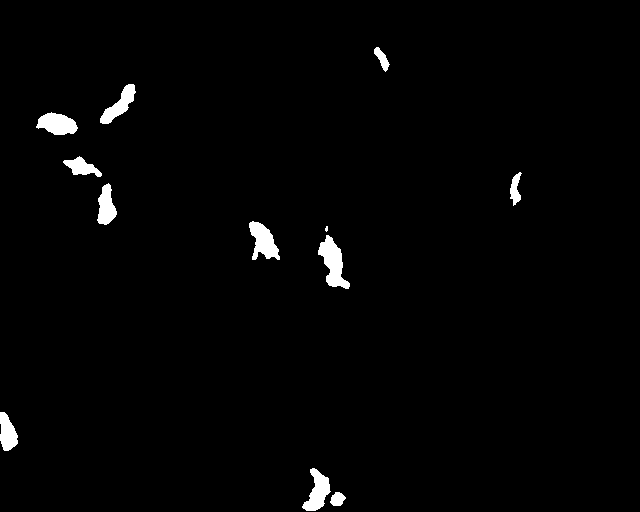

(2, 1, 512, 640)
(1, 512, 640)


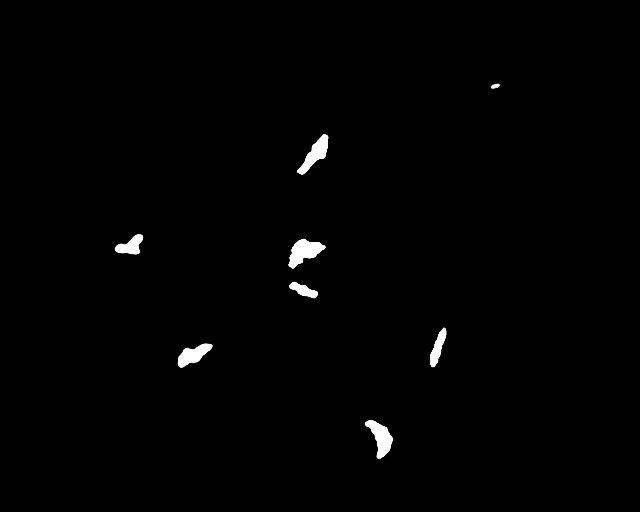

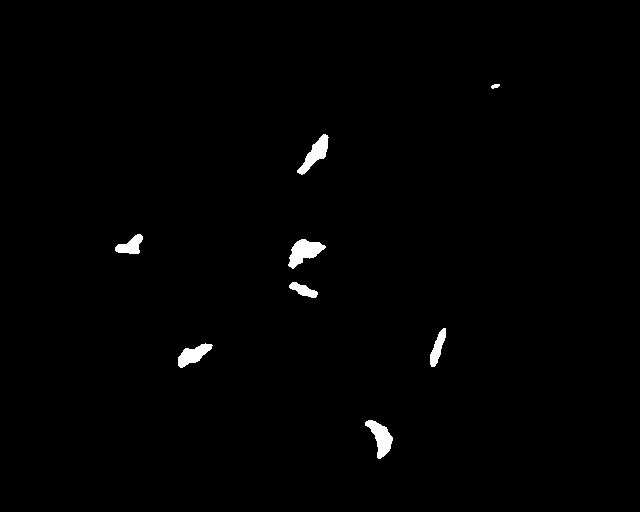

(2, 1, 512, 640)
(1, 512, 640)


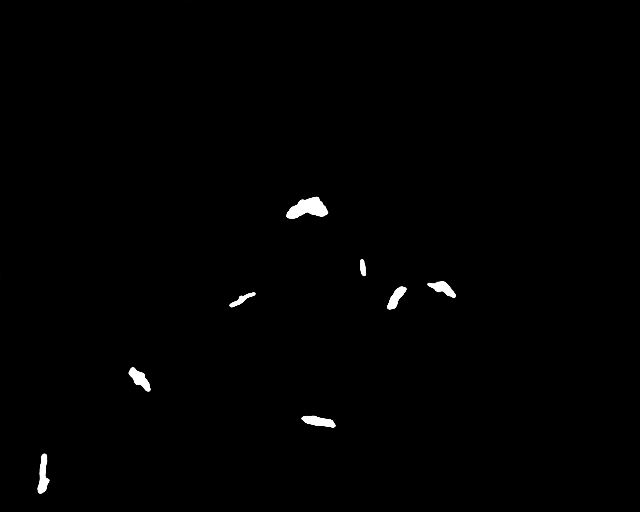

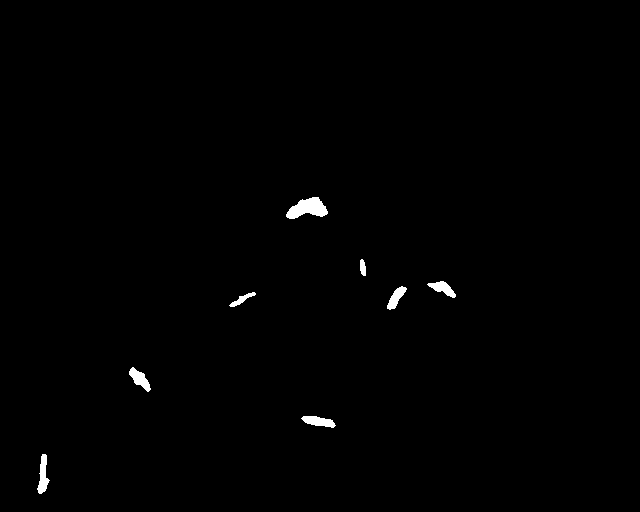

(2, 1, 512, 640)
(1, 512, 640)


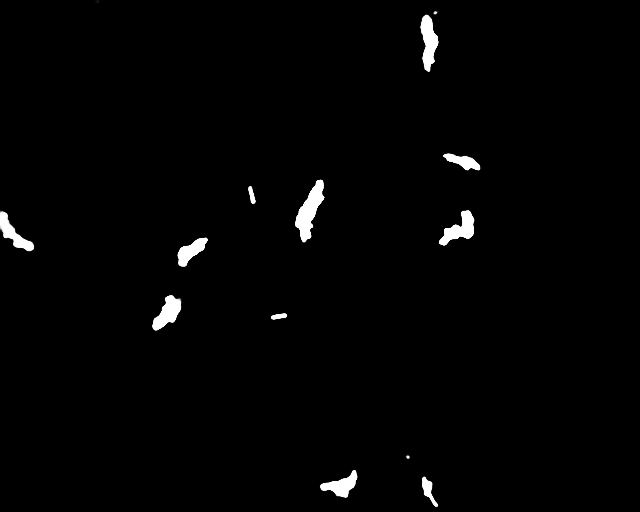

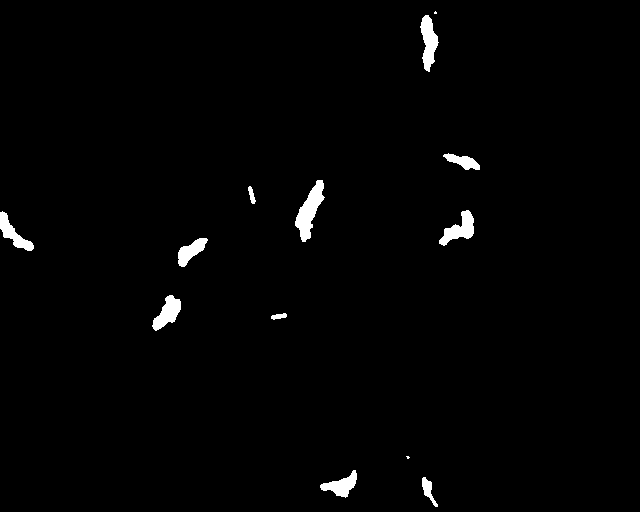

(2, 1, 512, 640)
(1, 512, 640)


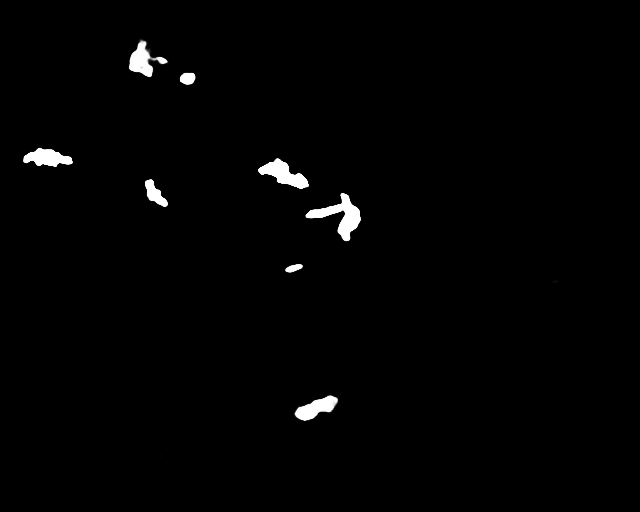

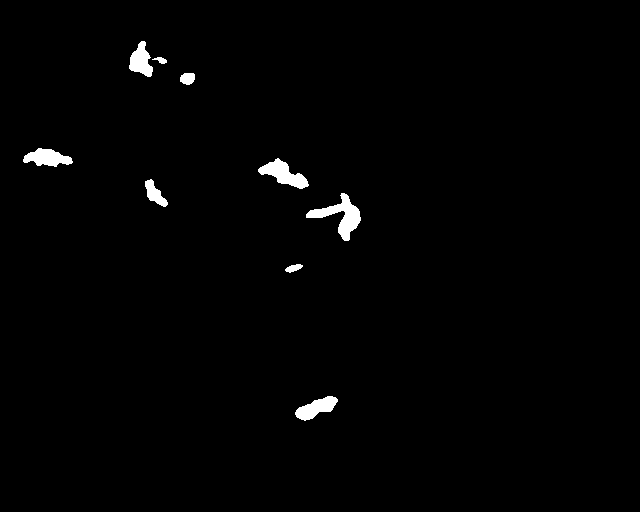

(2, 1, 512, 640)
(1, 512, 640)


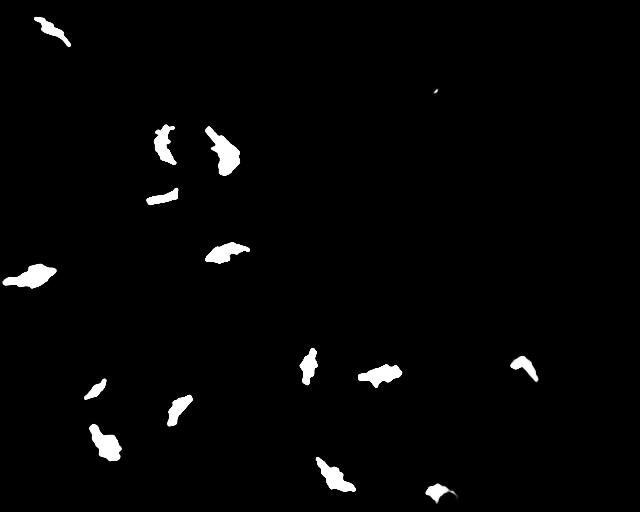

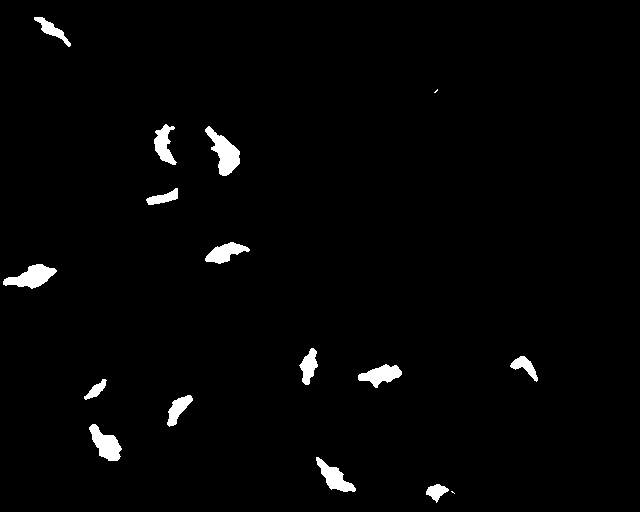

(2, 1, 512, 640)
(1, 512, 640)


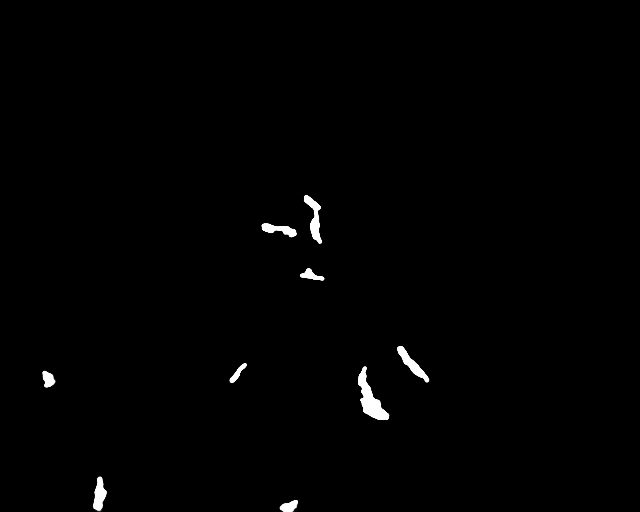

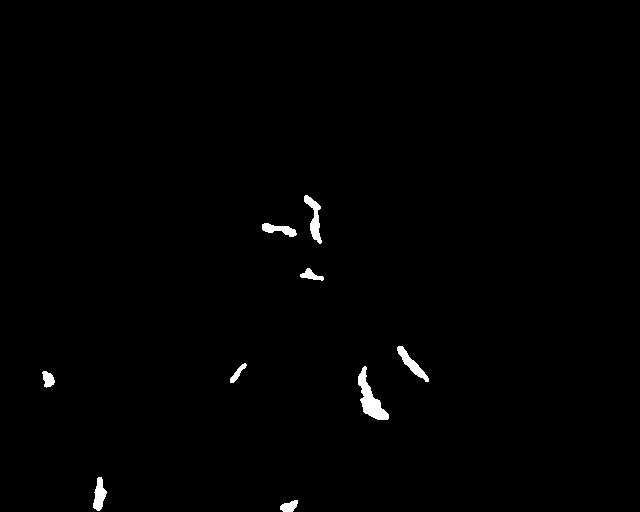

(2, 1, 512, 640)
(1, 512, 640)


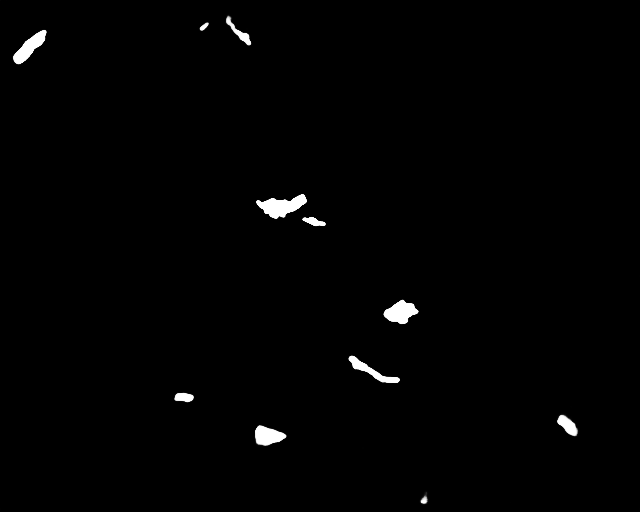

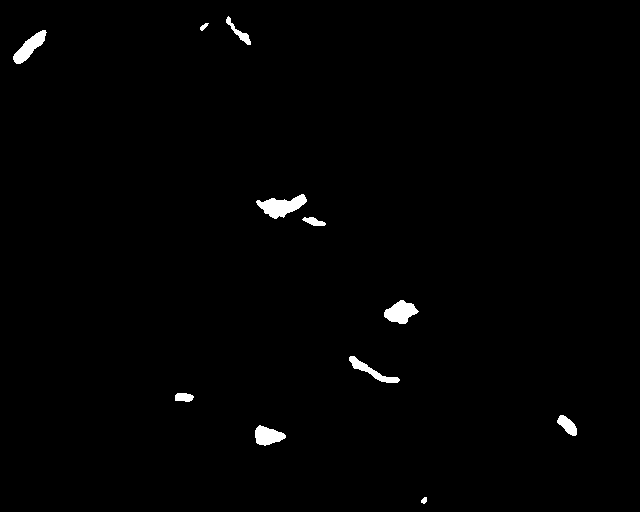

(2, 1, 512, 640)
(1, 512, 640)


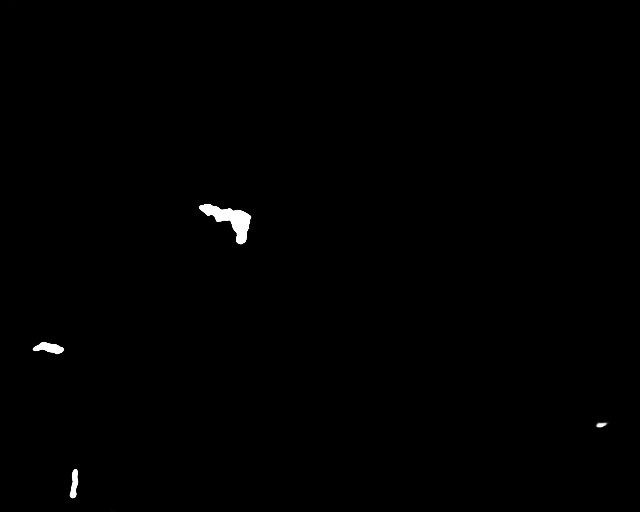

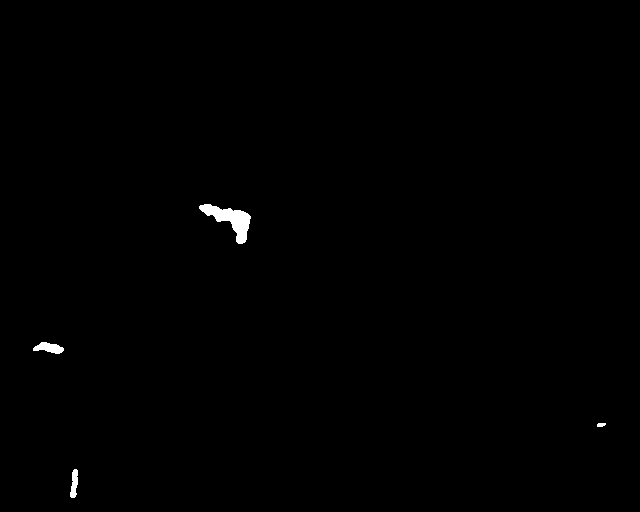

(2, 1, 512, 640)
(1, 512, 640)


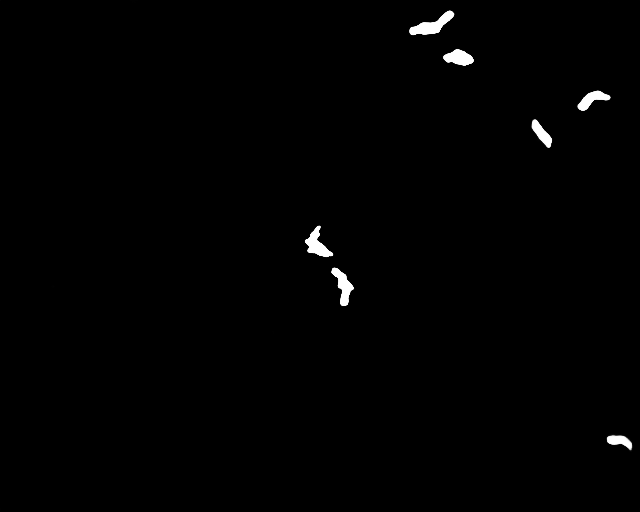

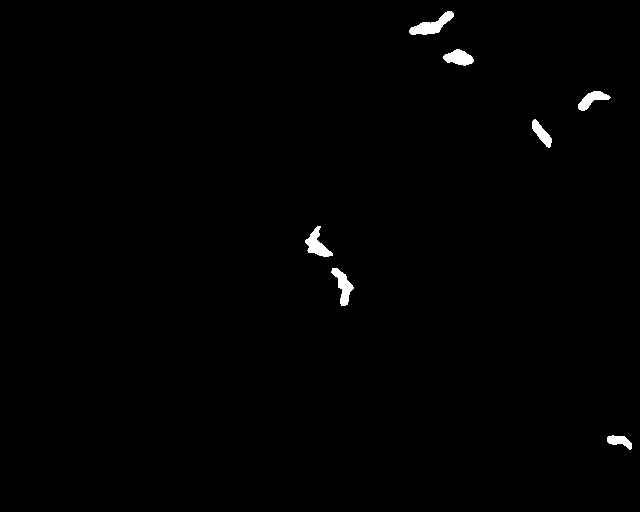

(1, 1, 512, 640)
(1, 512, 640)


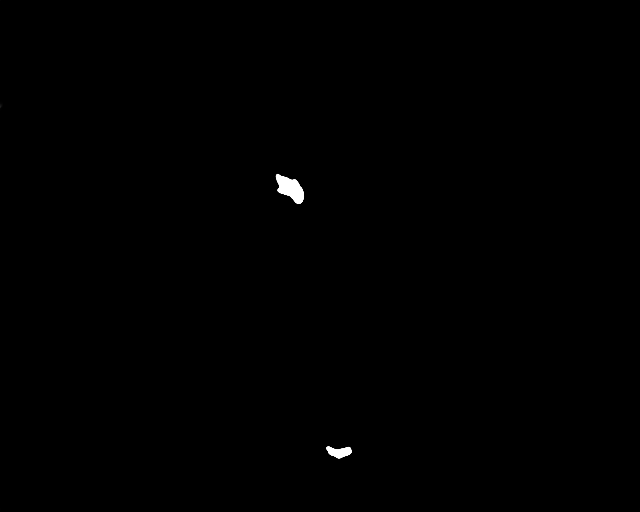

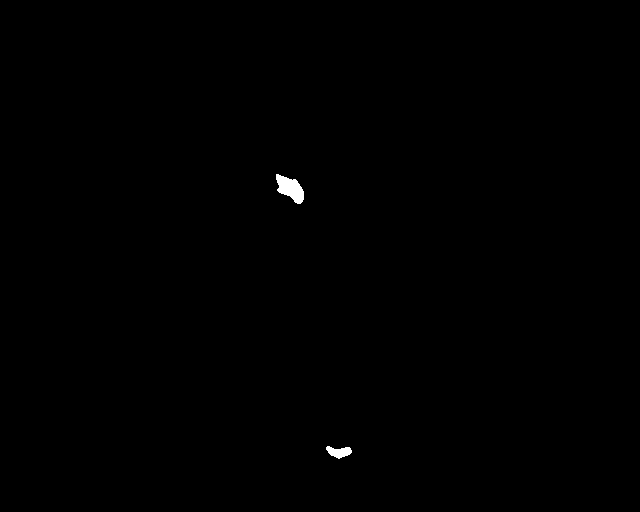

In [ ]:
test_img_paths = []
# for inputs , labels in dataloaders['train']:
#     print(type(inputs))
#     inputs = inputs.to(device)
#     labels = labels.to(device)
iter=0
test_val_dataloaders=[test_dataloader,val_dataloader]
flag_test_val=test_val_dataloaders[0]
mask_base64_array=[]
for inputs in flag_test_val:
    inputs = inputs.to(device)
    outputs = model(inputs)
    outputs = F.sigmoid(outputs)
    outputs = outputs.data.cpu().numpy()
    for output in outputs:
      print(outputs.shape)
      print(outputs[0].shape)
      output = np.transpose(output, (1,2,0))
      # print(outputs.shape)
      # outputs=np.squeeze(outputs, axis = 0) 
      # print(outputs.shape)
      output = ((output - output.min()) * (1/(output.max() - output.min()) * 255)).astype('uint8')
      # outputs.save('my_f.png')
      # print(outputs)
      # Change channel-order and make 3 channels for matplot
      # input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]
      # cv2_imshow(input_images_rgb[0])
      ret,mask = cv2.threshold(output,150,255,cv2.THRESH_BINARY)
      cv2_imshow(output)
      cv2_imshow(mask)
      cv2.imwrite('/content/current.png', mask)
      with open("/content/current.png", "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
        new_encoded_string=encoded_string.decode('utf-8')
        mask_base64_array.append(new_encoded_string)
    # print(outputs)
    # img = Image.fromarray(outputs, 'RGB')
    # img.save('my.png')
    # test_predictions.append(
    #     torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    # test_predictions_arg.append(preds.argmax(dim=1).data.cpu().numpy())
    # test_img_paths.extend(paths)

In [ ]:
if flag_test_val==test_dataloader:
  test_submission = pd.DataFrame.from_dict({'base64 encoded PNG (mask)':mask_base64_array})
  test_submission.to_csv('test_submission.csv')

else:
  val_submission=pd.read_csv('/content/val_submission.csv')
  val_submission['base64 encoded PNG (mask)']=mask_base64_array
  val_submission.to_csv('val_submission.csv')
  print(val_submission.head())
# base64_submission_df = pd.DataFrame.from_dict({'base64 encoded PNG (mask)':mask_base64_array})
# print(base64_submission_df.head(n=20))


In [ ]:
# метрика
LABELS = ['c_kefir', 'ent_cloacae', 'klebsiella_pneumoniae', 'moraxella_catarrhalis',
          'staphylococcus_aureus', 'staphylococcus_epidermidis']
DATASET_PATH = '/content/val_json'
label_metrics = np.zeros((len(LABELS), len(LABELS)), int)
seg_metrics = []
df = pd.read_csv('val_submission.csv')
def set_metrics(filename):
      global label_metrics, seg_metrics, df

      with open(os.path.join(DATASET_PATH, filename), 'r') as f:
          layout = json.load(f)

      h, w = layout['imageHeight'], layout['imageWidth']
      true_mask = np.zeros((h, w), np.uint8)
      label = layout['shapes'][0]['label']

      for shape in layout['shapes']:
          polygon = np.array([point[::-1] for point in shape['points']])
          cv2.fillPoly(true_mask, [polygon[:, [1, 0]]], 255)

      ind = int((int(filename[:-len(FILE_FILTER[1])])-1)/val_part)
      new_label = df.at[ind, 'class']
      label_metrics[LABELS.index(new_label)][LABELS.index(label)] += 1

      with open('tmp_bacteria.png', 'wb') as fp:
          fp.write(base64.b64decode(df.at[ind, 'base64 encoded PNG (mask)'].encode()))
      mask = cv2.imread('tmp_bacteria.png', 0)
      seg_metrics += [np.count_nonzero(np.logical_and(true_mask, mask)) /
                      np.count_nonzero(np.logical_or(true_mask, mask))]
def calculate_metrics():
      # print(seg_metrics)
      mean_iou = np.mean(seg_metrics)
      precisions = dict.fromkeys(LABELS, 0.)
      for label in LABELS:
          i = LABELS.index(label)
          precisions[label] = label_metrics[i][i] / np.sum(label_metrics[i, :])
      mean_precision = np.mean(list(precisions.values()))

      score = mean_iou + np.sum(list(precisions.values()))

      print(f'mean_iou: {mean_iou}')
      for k, v in precisions.items():
          print(f'precision_{k}: {v}')
      print(f'mean_precision: {mean_precision}\nscore: {score}')


def main():
      files = os.listdir(DATASET_PATH)
      for file in sorted(filter(lambda x: x[-len(FILE_FILTER[1]):].lower() == FILE_FILTER[1], files)):
          set_metrics(file)
      calculate_metrics()


main()


mean_iou: 0.8326331907109366
precision_c_kefir: 1.0
precision_ent_cloacae: 1.0
precision_klebsiella_pneumoniae: 1.0
precision_moraxella_catarrhalis: 1.0
precision_staphylococcus_aureus: 1.0
precision_staphylococcus_epidermidis: 1.0
mean_precision: 1.0
score: 6.832633190710936


In [ ]:
kefir=seg_metrics[0:14]
cloacae=seg_metrics[14:31]
kleb=seg_metrics[31:34]
catarr=seg_metrics[34:42]
aur=seg_metrics[42:46]
epid=seg_metrics[46:51]

print('kefir',np.mean(kefir))
print('cloacae',np.mean(cloacae))
print('kleb',np.mean(kleb))
print('catarr',np.mean(catarr))
print('aur',np.mean(aur))
print('epid',np.mean(epid))

kefir 0.8936368753408521
cloacae 0.8354603125848161
kleb 0.8274796841309042
catarr 0.8166908558531782
aur 0.7065223733026691
epid 0.801166967635805
